# Approach

# Task

<--  TODO -->

## Aim

## Questions

# General
## Imports

In [1]:
import math
import os
from pathlib import Path
from time import sleep

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyautogui
import seaborn as sns
import yaml
from bs4 import BeautifulSoup
from countries import get_for_IUCN
from scipy.stats import zscore
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    LeaveOneGroupOut,
    LeaveOneOut,
    LeavePGroupsOut,
    cross_val_score,
    train_test_split,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OneHotEncoder,
    StandardScaler,
)
from sklearn.svm import SVR


ModuleNotFoundError: No module named 'pyautogui'

## Constant Definition

In [174]:
DATA_PATH = Path('./data/')

## Selected countries

Beceause for the main source of our data we use the OECD repository we limit the number of countries we inspect. Countries are listed in a seperate yaml file "countries.yml" and structured by region which is needed for scraping the data from the IUCN webpage. This further provides a single method to filter our data and make sure all datasets have information on the same countries. We initally chose 65 countries that are present in all datasets available from the OECD repository and on the IUCN webpage.

In [175]:
COUNTRIES_YAML = Path('./countries.yml')

# get names of selected countries from YAML file
def get_country_list():
    countries = []
    with open(COUNTRIES_YAML, 'r') as cfg_file:
        cfg = yaml.safe_load(cfg_file)
    for region in cfg['countries']:
        countries += cfg['countries'][region]
    return countries

# get names of selected countries from YAML file
# names of countries slightly differ for the IUCN webpage
def get_countries_for_IUCN():
    region_country_list = []
    with open(COUNTRIES_YAML, 'r') as cfg_file:
        cfg = yaml.safe_load(cfg_file)
    for region_name in cfg['countries']:
        for country_name in cfg['countries'][region_name]:
            country_dict = {}
            country_dict['region_name'] = region_name
            country_dict['country_name'] = country_name
            if country_name in list(cfg['IUCN_name_transform'].keys()):
                country_dict['country_iucn'] = cfg['IUCN_name_transform'][country_name]
            else:
                country_dict['country_iucn'] = country_name
            region_country_list.append(country_dict)

    return region_country_list

SELECTED_COUNTRIES = get_country_list()

In [152]:
# todo: move to modeling part when all code is structured

def extract_from_cv_results(cv_results, row_name=None):
    cv_results = pd.DataFrame(cv_results)
    best_scores = {}
    best_params = {}

    scores = [col.replace('mean_test_', '') for col in cv_results.columns if col.startswith('mean_test_')]
    params = [col for col in cv_results.columns if col.startswith('param_')]

    for score in scores:
        best_params[score] = {}
        # rank is 1 for multiple models if score is equal
        best_model_by_score = cv_results[cv_results[f'rank_test_{score}'] == 1].iloc[0]
        best_scores[f'mean_{score}'] = best_model_by_score[f'mean_test_{score}']
        best_scores[f'std_{score}'] = best_model_by_score[f'std_test_{score}']
        for param in params:
            p = param.split('__')[-1]
            best_params[score][p] = best_model_by_score[param]
    
    best_params = pd.DataFrame(best_params)
    if row_name is None:
        best_scores = pd.DataFrame(best_scores, index=['value'])
    else:
        best_scores = pd.DataFrame(best_scores, index=[row_name])
        best_params['target'] = row_name
        best_params = best_params.reset_index().set_index(['target', 'index'])
    return best_scores, best_params

def results_by_target(data, cv_results_by_target):
    target_columns = [col for col in data.columns if col.endswith('threatened') or col.endswith('trend')]
    best_scores = []
    best_params = []
    for target in target_columns:
        scores, params = extract_from_cv_results(cv_results_by_target[target], target)
        best_scores.append(scores)
        best_params.append(params)

    best_scores = pd.concat(best_scores)
    best_scores = best_scores.rename(columns={
        'mean_neg_root_mean_squared_error': 'RMSE',
        'std_neg_root_mean_squared_error': 'RMSE_var',
        'mean_neg_mean_absolute_error': 'MAE',
        'std_neg_mean_absolute_error': 'MAE_var'
    })
    best_scores[['RMSE', 'MAE']] = best_scores[['RMSE', 'MAE']].apply(lambda x: -x)
    best_scores[['RMSE_var', 'MAE_var']] = best_scores[['RMSE_var', 'MAE_var']].apply(lambda x: x**2)

    best_params = pd.concat(best_params)
    best_params = best_params.rename(columns={
        'mean_neg_root_mean_squared_error': 'RMSE',
        'mean_neg_mean_absolute_error': 'MAE',
    })

    return best_scores, best_params

def extract_cv_scores(data, cv_results, score):
    target_columns = [col for col in data.columns if col.endswith('threatened') or col.endswith('trend')]
    results_by_target = {}
    for target in target_columns:
        results = pd.DataFrame(cv_results[target])
        best_results = results[results[f'rank_test_{score}'] == 1].iloc[0]
        cv_scores = [best_results[f'split{i}_test_{score}'] for i in range(data.shape[0])]
        cv_scores = [-val for val in cv_scores]
        results_by_target[target] = cv_scores
    return pd.DataFrame(results_by_target)

# Data

Todo:
- shortly describe our approach for getting all the data
    

## IUCN Redlist Data
Our main data source is the International Union For Conservation of Nature (IUCN). This is an international organization working on the field of nature conservation. They provide the most relevant and detaild data on threatened and extinct species.

### Getting the Data

We encountered several difficulties for utilizing the data provided by the IUCN.
First, summery statistics. The provided data is mostly in a format that is not machine readable (PDFs) or when machine readable files (CSVs) are provided the data is not in sufficent detail per country. 
Second, spatial data. This type of data provides detaild information per group of species. The data is provided as polygons but as our goal is to compare different characteristics of countries we would have to map the polygons to countries which is not a trivial task as the IUCNs process to define which species is resident in which country is very sophisticated and not easy to reproduce.
Third, there is no "historical" data on threatened species. Only some PDFs document the changes in status per species and year but the IUCN specifically states that "This table (Table 7) should not be used to calculate a Red List Index (RLI); for this it is necessary to analyse the underlying Red List data to identify genuine status changes between specific years for specific taxonomic groups."

The approach we therefore took was to scrape the needed data from the IUCN webpage using the advanced search at: https://www.iucnredlist.org/search/list. 
We use **selenium** and **beautifulsoup4** as they let us navigate the IUCN Webpage and extract the species on a per country level.

Todo Markus:
- describe scraping process

As stated by the IUCN on 
### Why filter country legends ?
https://www.iucnredlist.org/resources/summary-statistics

Important note: the figures presented in Tables 5 and 6 differ from the default setting for country searches on the website. The default search includes ALL occurrences within each country (i.e., including introduced species, vagrant records, etc.). To modify country searches on the website to match the tables below, use the Country Legends filters on the Advanced Search page to show species tagged as 'Extant', 'Extant & Reintroduced', 'Extinct', 'Extinct & Reintroduced', 'Possibly Extinct', and 'Possibly Extinct & Reintroduced'.




### Load IUCN Data

In this step we load the raw scraped data as provided on the IUCN webpage.

ToDo Markus:
- describe and comment
- why this countries

In [4]:
def load_IUCN_data():
    all_countries = []
    DATA_PATH = Path('./data/IUCN/scraped/')
    file_paths = DATA_PATH.glob('*.csv')

    for file_path in file_paths:
        df = pd.read_csv(file_path)
        df['country'] = file_path.stem
        all_countries.append(df)
    return pd.concat(all_countries, ignore_index=True)
IUCN_raw_data = load_IUCN_data()
IUCN_raw_data.shape

(136624, 7)

### Clean IUCN Data

In this step we inspect the raw data and handle major difficulties in the scraped data. The data is then preprocessed to transform it to the desired form.

The major difficulties we ecnountered are the following:
- The kingdom in the kingdom_class column is the same for all values as we filtered for animals only during scraping.
- The common name for species is missing alot.
- The trend is missing for a lot of species.
- The region is not usable because most of the time it includes "Global" and we are interested on a per country level.
- The threat_level includes data for 41 species that was missing on the IUCN webpage wher some HTML was saved

In [5]:
# kingdom the same for all values
IUCN_raw_data['kingdom_class'].unique()

array(['animalia — gastropoda', 'animalia — mammalia',
       'animalia — insecta', 'animalia — amphibia', 'animalia — aves',
       'animalia — actinopterygii', 'animalia — reptilia',
       'animalia — bivalvia', 'animalia — chondrichthyes',
       'animalia — malacostraca', 'animalia — holothuroidea',
       'animalia — cephalopoda', 'animalia — cephalaspidomorphi',
       'animalia — arachnida', 'animalia — clitellata',
       'animalia — myxini', 'animalia — anthozoa',
       'animalia — maxillopoda', 'animalia — hydrozoa',
       'animalia — merostomata', 'animalia — echinoidea',
       'animalia — branchiopoda', 'animalia — enopla',
       'animalia — onychophora', 'animalia — asteroidea',
       'animalia — ostracoda', 'animalia — monoplacophora',
       'animalia — diplopoda', 'animalia — entognatha',
       'animalia — sarcopterygii', 'animalia — turbellaria',
       'animalia — polychaeta'], dtype=object)

In [6]:
# check for missing numbers
IUCN_raw_data.isna().sum()

kingdom_class          0
common_name        43403
scientific_name        0
trend               2986
region                 0
threat_level           0
country                0
dtype: int64

In [7]:
# region values not usable
IUCN_raw_data['region'].unique()

array(['Global, Europe', 'Global', 'Global, Europe, Mediterranean',
       'Global, Mediterranean', 'Global, Arabian Sea',
       'Global, Caribbean', 'Global, Caribbean, Gulf of Mexico',
       'Global, Gulf of Mexico', 'Global, Persian Gulf',
       'Global, Northern Africa, Pan-Africa', 'Global, Pan-Africa',
       'Global, Pan-Africa, S. Africa FW',
       'Global, Eastern Africa, Pan-Africa'], dtype=object)

In [8]:
# missing data on webpage "[missing "en.shared.categories.cd" translation]"
IUCN_raw_data[IUCN_raw_data.threat_level == '[missing "en.shared.categories.cd" translation]'].shape

(41, 7)

#### Preparing the data

Several steps are taken to clean the raw IUCN data:
- The common name for each species is dropped as we can use the scientific name which is never missing.
- The observations where the threat_level is "missing" is renamed to the existing group "Data Deficient".
    - We checked the species directly on the webpage and saw that they were not categorized for any threat level.
- The missing trend values are filled with the exisitng group "Unknown".
- The class is extrected from each kingdom_class column.
    - We chose "group" for the new feature name as python would enclounter problems with the name "class".
- The groups include species which are of no interest for our analysis. So all sea species are excluded.
    - Mammals, Insects, Amphibians, Birds and Reptiels are kept
    - we renamed these as the scientific name is harder to recognize
- The threat_level is renamed to its short form.

#### Translate classes of animals

- mammalia: mammals
- actinopterygii: ray-finned fishes
- insecta: insects
- amphibia: amphibians
- aves: birds
- bivalvia: clams, oysters, cockles, mussels, scallops
- gastropoda: snails and slugs
- cephalaspidomorphi: jawless fishes
- clitellata: worms
- reptilia: reptiles
- chondrichthyes: cartilaginous fishes
- malacostraca: crustaceans
- hydrozoa: individually very small, predatory animals, most living in salt water
- turbellaria: flatworms

In [9]:
def IUCN_clean_data(data, filter_terrestrial=True):
    # remove column common name and region
    data = data.drop(columns=['common_name', 'region'])

    # categorize missing scraped data for trend to existing Data Deficient category
    data.threat_level.replace({
        '[missing "en.shared.categories.cd" translation]': 'Data Deficient'},
        inplace=True)

    # fill nan vlaues in trend with existing Unknown category
    data.trend.fillna('Unknown', inplace=True)

    # extract only class as kingdom is always animalia
    data['kingdom_class'] = data.apply(lambda row: row['kingdom_class'].split()[-1], axis=1)
    data = data.rename(columns={'kingdom_class': 'group'})

    # only select none sea animals
    if filter_terrestrial:
        none_sea_animals = ['mammalia', 'insecta', 'amphibia', 'aves', 'reptilia']
        data = data[data.group.isin(none_sea_animals)]

    # rename classes 
    data.group.replace({
        'mammalia': 'mammals',
        'insecta': 'insects',
        'amphibia': 'amphibians',
        'aves': 'birds',
        'reptilia': 'reptiles',
        },
        inplace=True)

    # rename threat levels 
    data.threat_level.replace({
        'Extinct': 'EX',
        'Extinct in the Wild': 'EW',
        'Critically Endangered': 'CR',
        'Endangered': 'EN',
        'Vulnerable': 'VU',
        'Near Threatened': 'NT',
        'Least Concern': 'LC',
        'Data Deficient': 'DD',
        },
        inplace=True)

    return data
IUCN_cleaned_data = IUCN_clean_data(IUCN_raw_data)
IUCN_cleaned_data.shape

(66669, 5)

In [10]:
# have a look at the cleand data
IUCN_cleaned_data.head()

group        scientific_name       trend threat_level country
2  mammals  Pipistrellus nathusii     Unknown           LC  Latvia
3  insects       Bombus bohemicus  Decreasing           DD  Latvia
4  insects   Cucujus cinnaberinus  Increasing           NT  Latvia
5  insects  Coenagrion pulchellum      Stable           LC  Latvia
6  insects       Ischnura pumilio      Stable           LC  Latvia

### Check if scraped data is complete

As the web scraping process is error prone we need to check if the number of species by country we extracted from the IUCN web page make sense. 
For this we use Table 6a of the IUCN Summary Statistics: https://www.iucnredlist.org/resources/summary-statistics

First we load our scraped data for all species and bring it in the same format as Table 6a. Then we compare the difference in number of species by our selected countries.

Here is a short description of the threat levels contained in Table 6a.
IUCN Red List Categories: EX - Extinct, EW - Extinct in the Wild, CR - Critically Endangered (includes CR(PE) and CR(PEW)), EN - Endangered, VU - Vulnerable, LR/cd - Lower Risk/conservation dependent, NT - Near Threatened (includes LR/nt - Lower Risk/near threatened), DD - Data Deficient, LC - Least Concern (includes LR/lc - Lower Risk/least concern).

In [11]:
# load all species by country
IUCN_cleaned_all = IUCN_clean_data(IUCN_raw_data, filter_terrestrial=False)
# bring data In same format as Table 6a
grouped = IUCN_cleaned_all.groupby(['country', 'threat_level'])['scientific_name'].count().reset_index(name='count')
species_tl = grouped.pivot_table(index='country', columns='threat_level', values='count')
species_tl = species_tl.fillna(0.0)
species_tl['Total'] = species_tl.sum(axis=1)
species_tl = species_tl.convert_dtypes(convert_integer=True)
# show number of species by threat level
species_tl.head()

CR   DD   EN  EW  EX    LC   NT   VU  Total
country                                                 
Argentina    40  178   69   3   3  2210  127  118   2748
Armenia       7   18    8   0   0   471   38   26    568
Australia   137  664  255   0  42  5867  442  613   8020
Austria      24   66   29   0   3   851   81   52   1106
Azerbaijan   13   45   10   1   0   583   41   31    724

In [12]:
def IUCN_load_table6a(threat_levels, country_rename_mapper, country_list):
    # load data
    DATA_PATH = Path('./data/IUCN')
    data = pd.read_csv(DATA_PATH / 'Table 6a Animal species (kingdom Animalia) by country - show all.csv', thousands=',')
    # rename columns
    data = data.rename(columns={
        'Name': 'country',
        'NT or LR/nt': 'NT',
        'LC or LR/lc': 'LC',
    })
    # add LR/cd (Lower Risk/conservation dependent) to Least Concern
    data['LC'] = data['LC'] + data['LR/cd']
    # only select needed threat_levels
    data = data[['country'] + threat_levels]
    # rename countries
    data.country.replace(country_rename_mapper, inplace=True)
    # only select needed countries
    data = data[data.country.isin(country_list)]
    data = data.sort_values('country')
    data = data.set_index('country')

    return data

# get only the threat levels we are interested in (others are sub or super groups)
threat_levels = list(species_tl.columns)
# countries need to be renamed
country_dict = get_countries_for_IUCN()
country_rename_mapper = {d['country_iucn']: d['country_name'] for d in country_dict}
country_list = get_country_list()
table6a = IUCN_load_table6a(threat_levels, country_rename_mapper, country_list)
# check if all countries the same
assert len(country_list) == table6a.shape[0]

In [13]:
# compare difference in total species per country
species_tl_total = species_tl[['Total']].rename(columns={'Total': 'Total_scraped'})
species_tl_total = species_tl_total.reset_index()
evaluate_difference = table6a.merge(species_tl_total, how='left', on='country').set_index('country')
evaluate_difference['diff'] = evaluate_difference['Total'] - evaluate_difference['Total_scraped']
evaluate_difference[evaluate_difference['diff'] != 0]

CR    DD   EN  EW   EX    LC   NT   VU  Total  \
country                                                                    
Argentina                  41   178   69   3    3  2211  127  118   2750   
Australia                 138   661  255   0   42  5871  442  613   8022   
Brazil                    105   700  144   2   11  4777  230  287   6256   
Canada                     18    87   32   0    9  1902   64   84   2196   
Chile                      25   201   62   0    1  1302   84   81   1756   
Colombia                  126   586  227   0    1  5285  259  361   6845   
Costa Rica                 35   235   82   0    4  3392  107  154   4009   
Greenland                   2    20    5   0    1   217    8   20    273   
India                      94   868  230   0    0  4334  331  398   6255   
Indonesia                 185  1392  323   0    3  6311  640  654   9508   
Japan                      46   508  149   1   14  3375  267  256   4616   
Mexico                    202   585  343   9   21  4931  217  362   6670   
New Caledonia              41   182   56   0    5  2190  163  159   2796   
New Zealand                45   210   77   0   23  1066   66  109   1596   
Northern Mariana Islands    9    70   24   0    2  1296   91   72   1564   
Peru                       58   474  155   0    1  3893  204  209   4994   
Russia                     28   233   49   1    3  1735  118  111   2278   
South Africa               85   340  178   0    6  3722  189  213   4733   
United States             224   609  298   4  237  5724  336  566   7998   

                          Total_scraped  diff  
country                                        
Argentina                          2748     2  
Australia                          8020     2  
Brazil                             6249     7  
Canada                             2195     1  
Chile                              1754     2  
Colombia                           6840     5  
Costa Rica                         4008     1  
Greenland                           272     1  
India                              6253     2  
Indonesia                          9502     6  
Japan                              4615     1  
Mexico                             6669     1  
New Caledonia                      2795     1  
New Zealand                        1594     2  
Northern Mariana Islands           1562     2  
Peru                               4991     3  
Russia                             2277     1  
South Africa                       4732     1  
United States                      7994     4

We see that for 19 countries we have different numbers of total species but the differences are not large. We can attribute these differences due to the fact that the Table 6a of the summary statistics is not up to date. Further the process how species are attributed to a country could be different in the 
summery statisitc compared to the data on the web.
As we can see there is no major difference in species for any country and we can therefore assume that the web scraping process did not encounter any major problems or missed some data.

## Feature preperation

### Create relative numbers per group

As we want to know the Relative numbers of species in each group we transform our current data.

Threatened species are listed in any of the three categories Critically Endangered (CR), Endangered (EN) or Vulnerable (VU).

*Reptiles, fishes, molluscs, other invertebrates, plants, fungi and chromists: please note that for these groups, there are still many species that have not yet been assessed for the IUCN Red List and therefore their status is not known (i.e., these groups have not yet been completely assessed). Therefore the figures presented below for these groups should be interpreted as the number of species known to be threatened within those species that have been assessed to date, and not as the overall total number of threatened species for each group.

Todo Markus
- descibe

In [14]:
def IUCN_threatened_by_group(species_by_country):
    relative_threatened = []
    # iterate all groups of animals and the total relative value
    groups = ['total'] + list(species_by_country.group.unique())
    for group in groups:
        filtered = species_by_country
        if group != 'total':
            filtered = species_by_country[species_by_country.group == group]
        # count the number of species for each threat level
        grouped = filtered.groupby(['country', 'threat_level'])['scientific_name']
        grouped = grouped.count().reset_index(name='count')
        # transform data so we have the value counts per threat level in the DataFrame
        current_group = grouped.pivot_table(index='country', columns='threat_level', values='count')
        # fill nan values because if there are no species by one threat level we have NaNs
        current_group = current_group.fillna(0.0)
        # calculate relative numbers
        relative = current_group[['CR', 'EN', 'VU']].sum(axis=1) / current_group.sum(axis=1)
        # rename the column
        relative = relative.to_frame(f'{group}_threatened').round(4)
        relative_threatened.append(relative)

    combined_data = pd.concat(relative_threatened, axis=1)
    # as some countries don't have species in each group we create features 
    # to define if a group of species is resident in a given country
    species_resident = combined_data.notna()
    column_names = [f'{group}_resident' for group in groups]
    species_resident.columns = column_names
    species_resident = species_resident.drop(columns='total_resident')

    # fill NaNs for relative threatened if there is no species in this country and group
    combined_data = combined_data.fillna(0.0)

    return combined_data.join(species_resident)

threatened_by_group = IUCN_threatened_by_group(IUCN_cleaned_data)

# save data 
# todo: remove
ds_threatened_by_group = threatened_by_group.reset_index(drop=False).rename(columns={'index':'Country'}).copy()

### Create relative numbers per trend

Todo Markus
- decribe

In [15]:
def IUCN_trend_by_group(species_by_country):

    grouped = IUCN_cleaned_data.groupby(['country', 'trend'])['scientific_name'].count().reset_index(name='count')
    species_trend_country = grouped.pivot_table(index='country', columns='trend', values='count')
    species_trend_country = species_trend_country.fillna(0.0)
    species_trend_country['Total'] = species_trend_country.sum(axis=1)
    
    trends = list(IUCN_cleaned_data.trend.unique())


    relative_trends = []
    # iterate all groups of animals and the total relative value
    trends = list(species_by_country.trend.unique())
    for trend in trends:
        species_trend_country[trend] = species_trend_country[trend] / species_trend_country['Total']
    species_trend_country = species_trend_country.drop(columns='Total')

    # drop unknown trends
    species_trend_country = species_trend_country.drop(columns='Unknown')

    # rename column headings
    species_trend_country = species_trend_country.rename(columns=lambda x: f'{x.lower()}_trend')

    return species_trend_country

trend_by_group = IUCN_trend_by_group(IUCN_cleaned_data)

## Data Exploration

Next we explore the data in general.
The major analysisi will take place when all datasets are merged.

Todo Markus:
- describe

In [16]:
# number of unique animal species in all countrys
species = IUCN_cleaned_data.drop(columns=['country']).drop_duplicates()
species.shape

(28080, 4)

In [17]:
species.group.value_counts()

birds         8410
insects       6826
reptiles      4934
amphibians    3986
mammals       3924
Name: group, dtype: int64

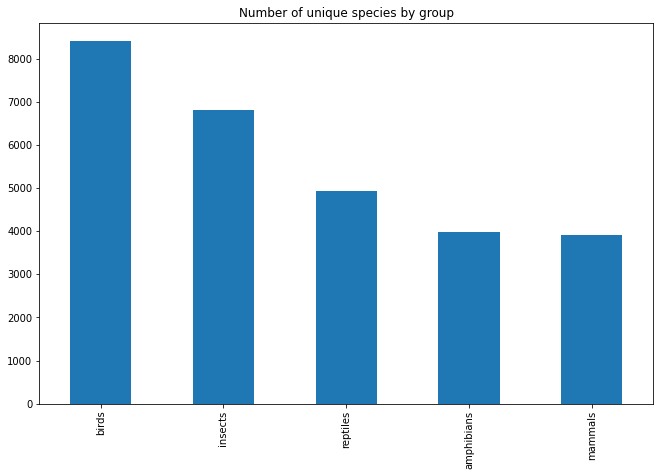

In [18]:
fig, ax = plt.subplots(figsize=(11, 7))
ax.set_title('Number of unique species by group')
species.group.value_counts().plot(kind='bar')
plt.show()

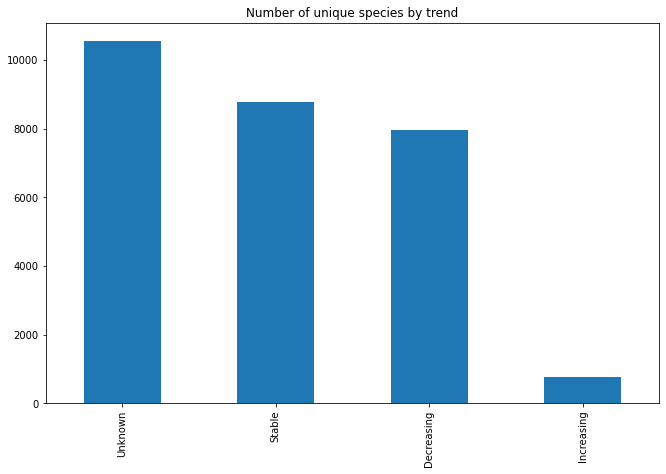

In [19]:
fig, ax = plt.subplots(figsize=(11, 7))
ax.set_title('Number of unique species by trend')
species.trend.value_counts().plot(kind='bar')
plt.show()

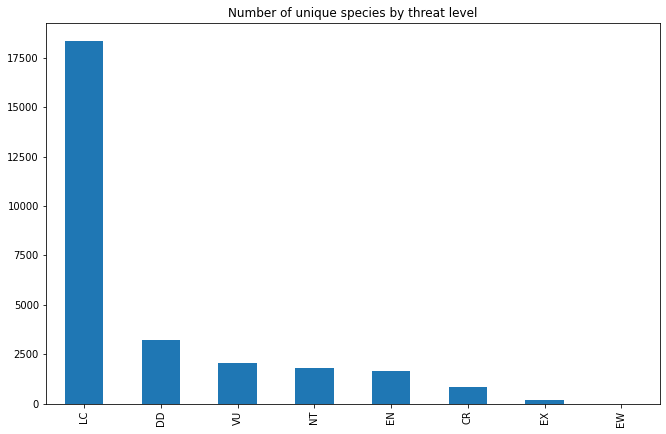

In [20]:
fig, ax = plt.subplots(figsize=(11, 7))
ax.set_title('Number of unique species by threat level')
species.threat_level.value_counts().plot(kind='bar')
plt.show()

## Evaluate reason for missing trends

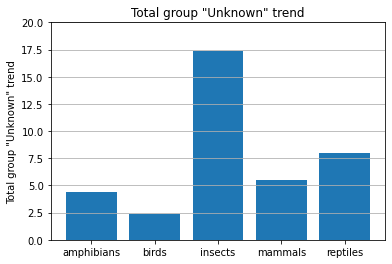

In [21]:
miss_trend = species[species.trend == 'Unknown'].sort_values('group')

miss_trend_group = miss_trend.drop(['threat_level'], axis=1)

miss_trend_group = miss_trend_group.groupby(['trend', 'group']).count().scientific_name
total_group = species.sort_values('group').groupby(['group']).count().scientific_name

plt.bar(species.sort_values('group').group.unique(), miss_trend_group / sum(total_group) * 100)
plt.title('Total group "Unknown" trend')
plt.ylabel('Total group "Unknown" trend')
plt.ylim(0,20)
plt.grid(axis='y')
plt.show()

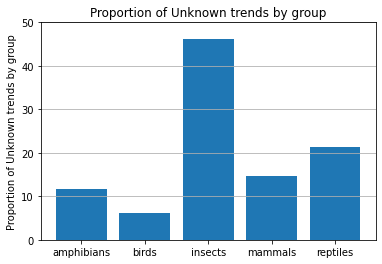

In [22]:
plt.bar(species.sort_values('group').group.unique(), miss_trend_group / sum(miss_trend_group) * 100)
plt.title('Proportion of Unknown trends by group')
plt.ylabel('Proportion of Unknown trends by group')
plt.ylim(0,50)
plt.grid(axis='y')

plt.show()

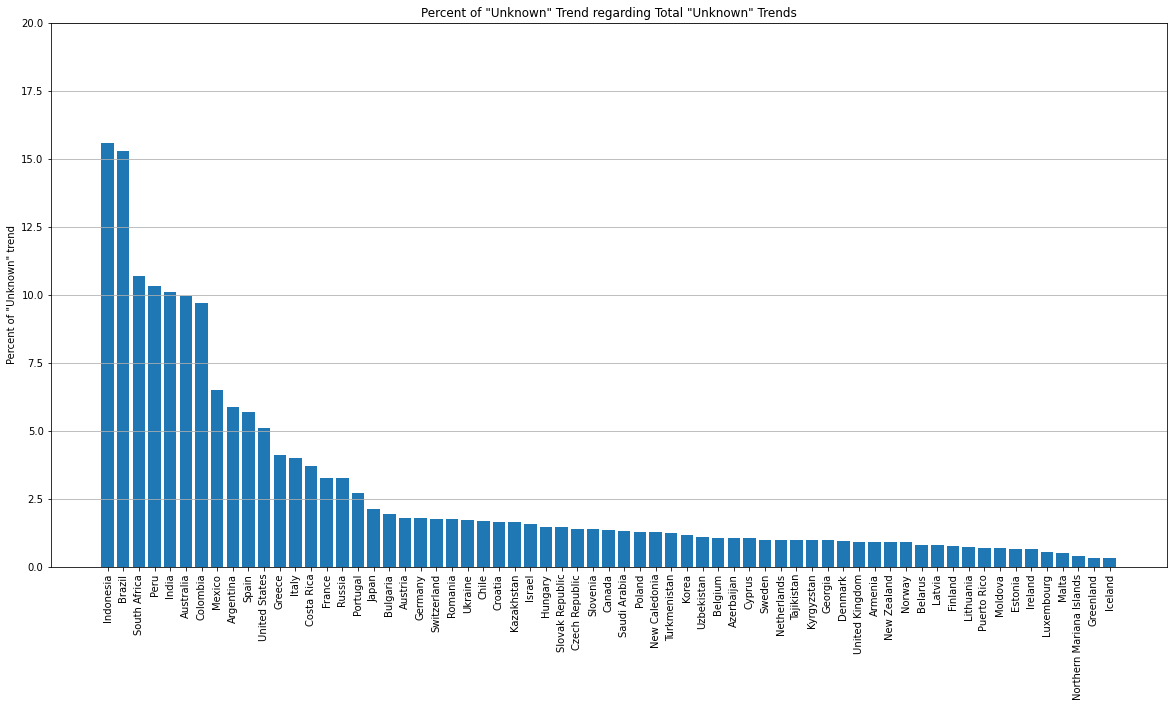

In [23]:
# transform data
grouped = IUCN_cleaned_data.groupby(['country', 'trend'])['scientific_name'].count().reset_index(name='count')
species_trend_country = grouped.pivot_table(index='country', columns='trend', values='count')
species_trend_country = species_trend_country.fillna(0.0)
species_trend_country['Total'] = species_trend_country.sum(axis=1)
species_trend_country.shape

miss_trend_country = species_trend_country.copy()
miss_trend_country['Percent_Unknown'] = miss_trend_country.Unknown / sum(miss_trend_group) * 100
miss_trend_country['Proportion_Unknown'] = miss_trend_country.Unknown / miss_trend_country.Total * 100

plt.figure(figsize=(20,10))
plt.bar(miss_trend_country.reset_index().sort_values('Percent_Unknown', ascending=False)['country'], 
        miss_trend_country.sort_values('Percent_Unknown', ascending=False)['Percent_Unknown']
    )
plt.title('Percent of "Unknown" Trend regarding Total "Unknown" Trends')
plt.ylabel('Percent of "Unknown" trend')
plt.xticks(rotation='vertical')
plt.ylim(0,20)
plt.grid(axis='y')
plt.show()

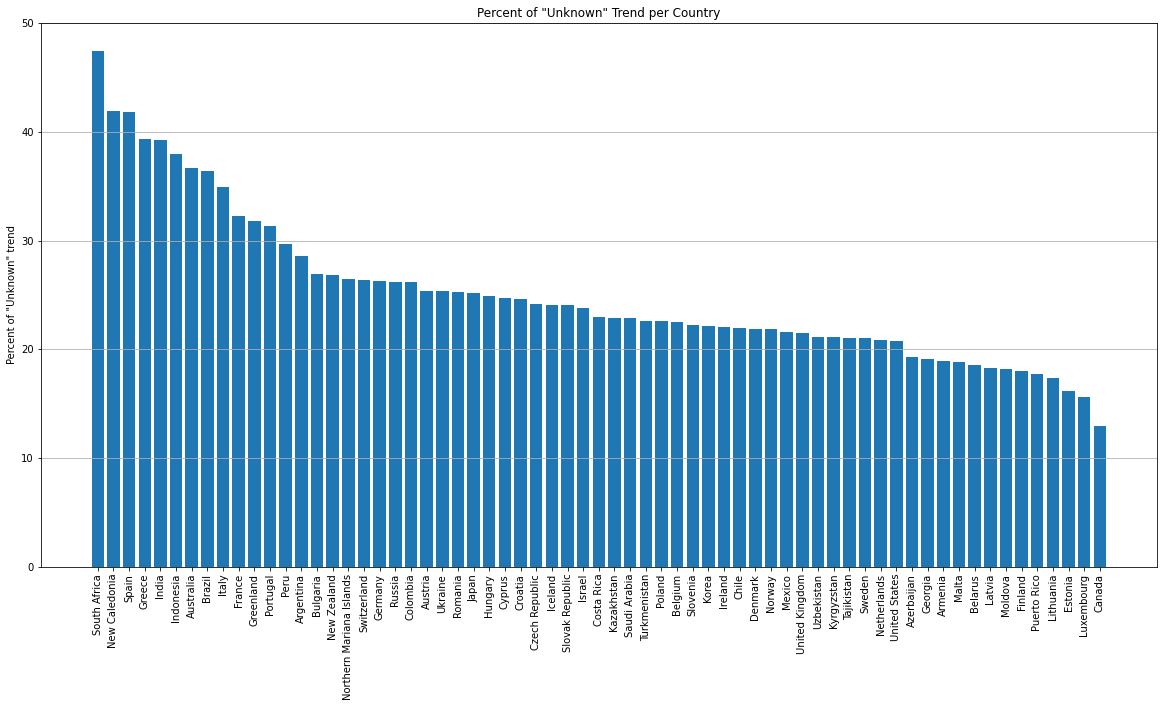

In [24]:
plt.figure(figsize=(20,10))
plt.bar(miss_trend_country.reset_index().sort_values('Proportion_Unknown', ascending=False)['country'], 
        miss_trend_country.sort_values('Proportion_Unknown', ascending=False)['Proportion_Unknown']
    )
plt.title('Percent of "Unknown" Trend per Country')
plt.xticks(rotation='vertical')
plt.ylim(0,50)
plt.ylabel('Percent of "Unknown" trend')
plt.grid(axis='y')
plt.show()

In [25]:
miss_trend_country

trend           Decreasing  Increasing  Stable  Unknown  Total  \
country                                                          
Argentina              594          94     857      618   2163   
Armenia                184          70     162       97    513   
Australia              559          84    1166     1049   2858   
Austria                256          81     221      190    748   
Azerbaijan             207          75     191      113    586   
...                    ...         ...     ...      ...    ...   
Turkmenistan           186          66     199      132    583   
Ukraine                254          82     193      180    709   
United Kingdom         152          68     135       97    452   
United States          560         234    1260      539   2593   
Uzbekistan             177          60     189      114    540   

trend           Percent_Unknown  Proportion_Unknown  
country                                              
Argentina              5.856710           28.571429  
Armenia                0.919257           18.908382  
Australia              9.941243           36.703989  
Austria                1.800607           25.401070  
Azerbaijan             1.070887           19.283276  
...                         ...                 ...  
Turkmenistan           1.250948           22.641509  
Ukraine                1.705838           25.387870  
United Kingdom         0.919257           21.460177  
United States          5.108036           20.786734  
Uzbekistan             1.080364           21.111111  

[65 rows x 7 columns]

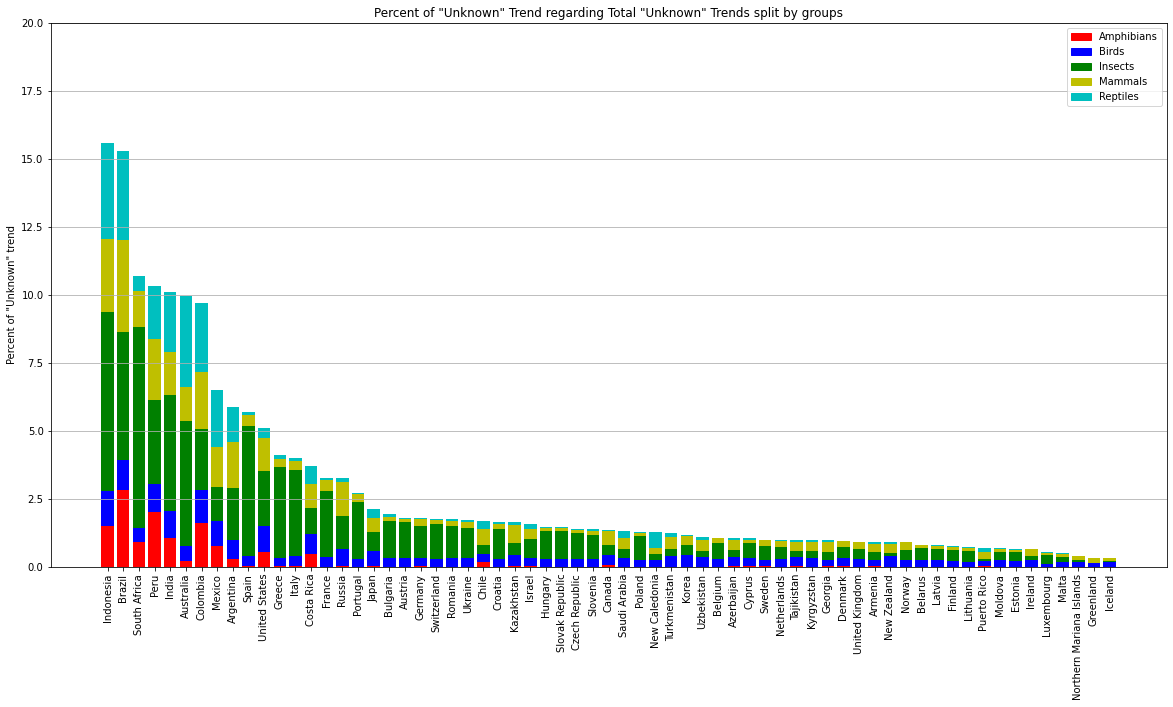

In [26]:
miss_trend_country_group = IUCN_cleaned_data[IUCN_cleaned_data.trend=='Unknown'].groupby(['country', 'group'])['scientific_name'].count().reset_index(name='count')

miss_trend_country_group = miss_trend_country_group.set_index('country')

ind = miss_trend_country.drop(['Decreasing', 'Increasing', 'Stable'], axis=1).sort_values('Percent_Unknown', ascending=False)

miss_tcg_amphibians = miss_trend_country_group[miss_trend_country_group.group == 'amphibians']
miss_tcg_birds = miss_trend_country_group[miss_trend_country_group.group == 'birds']
miss_tcg_insects = miss_trend_country_group[miss_trend_country_group.group == 'insects']
miss_tcg_mammals = miss_trend_country_group[miss_trend_country_group.group == 'mammals']
miss_tcg_reptiles = miss_trend_country_group[miss_trend_country_group.group == 'reptiles']

miss_tcg_amphibians = pd.concat([ind, miss_tcg_amphibians], axis=1).fillna(0).drop(['Unknown', 'group'], axis=1)
miss_tcg_birds = pd.concat([ind, miss_tcg_birds], axis=1).fillna(0).drop(['Unknown', 'group'], axis=1)
miss_tcg_insects = pd.concat([ind, miss_tcg_insects], axis=1).fillna(0).drop(['Unknown', 'group'], axis=1)
miss_tcg_mammals = pd.concat([ind, miss_tcg_mammals], axis=1).fillna(0).drop(['Unknown', 'group'], axis=1)
miss_tcg_reptiles = pd.concat([ind, miss_tcg_reptiles], axis=1).fillna(0).drop(['Unknown', 'group'], axis=1)

miss_tcg_amphibians['Percent_Unknown'] = miss_tcg_amphibians['count'] / sum(miss_trend_group) * 100
miss_tcg_birds['Percent_Unknown'] = miss_tcg_birds['count'] / sum(miss_trend_group) * 100
miss_tcg_insects['Percent_Unknown'] = miss_tcg_insects['count'] / sum(miss_trend_group) * 100
miss_tcg_mammals['Percent_Unknown'] = miss_tcg_mammals['count'] / sum(miss_trend_group) * 100
miss_tcg_reptiles['Percent_Unknown'] = miss_tcg_reptiles['count'] / sum(miss_trend_group) * 100

countries = ind.reset_index()['country']

amphibians = miss_tcg_amphibians['Percent_Unknown'].values
birds = miss_tcg_birds['Percent_Unknown'].values
insects = miss_tcg_insects['Percent_Unknown'].values
mammals = miss_tcg_mammals['Percent_Unknown'].values
reptiles = miss_tcg_reptiles['Percent_Unknown'].values

plt.figure(figsize=(20,10))
plt.bar(countries, amphibians, color='r')
plt.bar(countries, birds, bottom=amphibians, color='b')
plt.bar(countries, insects, bottom=birds + amphibians, color='g')
plt.bar(countries, mammals, bottom=insects + birds + amphibians, color='y')
plt.bar(countries, reptiles, bottom=mammals + insects + birds + amphibians, color='c')

plt.title('Percent of "Unknown" Trend regarding Total "Unknown" Trends split by groups')
plt.xticks(rotation='vertical')
plt.ylim(0,20)
plt.ylabel('Percent of "Unknown" trend')

colors = {'Amphibians':'r', 'Birds':'b', 'Insects':'g', 'Mammals':'y', 'Reptiles':'c'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.grid(axis='y')

plt.show()

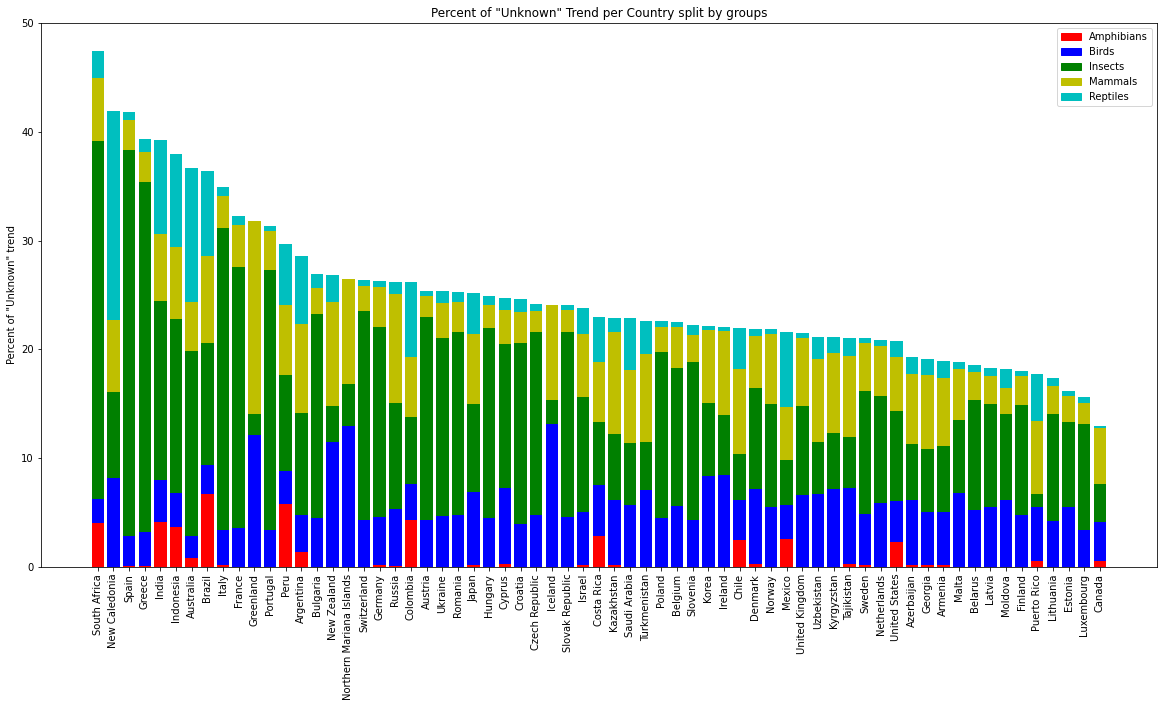

In [27]:
miss_trend_country_group = IUCN_cleaned_data[IUCN_cleaned_data.trend=='Unknown'].groupby(['country', 'group'])['scientific_name'].count().reset_index(name='count')

miss_trend_country_group = miss_trend_country_group.set_index('country')

ind = miss_trend_country.drop(['Decreasing', 'Increasing', 'Stable'], axis=1).sort_values('Proportion_Unknown', ascending=False)

miss_tcg_amphibians = miss_trend_country_group[miss_trend_country_group.group == 'amphibians']
miss_tcg_birds = miss_trend_country_group[miss_trend_country_group.group == 'birds']
miss_tcg_insects = miss_trend_country_group[miss_trend_country_group.group == 'insects']
miss_tcg_mammals = miss_trend_country_group[miss_trend_country_group.group == 'mammals']
miss_tcg_reptiles = miss_trend_country_group[miss_trend_country_group.group == 'reptiles']

miss_tcg_amphibians = pd.concat([ind, miss_tcg_amphibians], axis=1).fillna(0).drop(['Unknown', 'group'], axis=1)
miss_tcg_birds = pd.concat([ind, miss_tcg_birds], axis=1).fillna(0).drop(['Unknown', 'group'], axis=1)
miss_tcg_insects = pd.concat([ind, miss_tcg_insects], axis=1).fillna(0).drop(['Unknown', 'group'], axis=1)
miss_tcg_mammals = pd.concat([ind, miss_tcg_mammals], axis=1).fillna(0).drop(['Unknown', 'group'], axis=1)
miss_tcg_reptiles = pd.concat([ind, miss_tcg_reptiles], axis=1).fillna(0).drop(['Unknown', 'group'], axis=1)

miss_tcg_amphibians['Proportion_Unknown'] = miss_tcg_amphibians['count'] / miss_tcg_amphibians.Total * 100
miss_tcg_birds['Proportion_Unknown'] = miss_tcg_birds['count'] / miss_tcg_birds.Total * 100
miss_tcg_insects['Proportion_Unknown'] = miss_tcg_insects['count'] / miss_tcg_insects.Total * 100
miss_tcg_mammals['Proportion_Unknown'] = miss_tcg_mammals['count'] / miss_tcg_mammals.Total * 100
miss_tcg_reptiles['Proportion_Unknown'] = miss_tcg_reptiles['count'] / miss_tcg_reptiles.Total * 100

countries = ind.reset_index()['country']

amphibians = miss_tcg_amphibians['Proportion_Unknown'].values
birds = miss_tcg_birds['Proportion_Unknown'].values
insects = miss_tcg_insects['Proportion_Unknown'].values
mammals = miss_tcg_mammals['Proportion_Unknown'].values
reptiles = miss_tcg_reptiles['Proportion_Unknown'].values

plt.figure(figsize=(20,10))
plt.bar(countries, amphibians, color='r')
plt.bar(countries, birds, bottom=amphibians, color='b')
plt.bar(countries, insects, bottom=birds + amphibians, color='g')
plt.bar(countries, mammals, bottom=insects + birds + amphibians, color='y')
plt.bar(countries, reptiles, bottom=mammals + insects + birds + amphibians, color='c')

plt.title('Percent of "Unknown" Trend per Country split by groups')
plt.xticks(rotation='vertical')
plt.ylim(0,50)
plt.ylabel('Percent of "Unknown" trend')

colors = {'Amphibians':'r', 'Birds':'b', 'Insects':'g', 'Mammals':'y', 'Reptiles':'c'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
#plt.-

plt.show()

# Support Data Preparation
## Climate
### Constants

In [28]:
TEMP_DATA = 'data/climate/temperature_data_1991_2016.csv'
RAIN_DATA = 'data/climate/rain_data_1991_2016.csv'
OUTPUT_PATH = 'data/climate/climate_features.csv'

### Temperature Data
#### Load and Transform Data

In [29]:
data_temp = pd.read_csv(
    TEMP_DATA,
    sep=',',
    names=['Temperature', 'Year', 'Statistics', 'Country', 'ISO_Country',
           '_']).drop(0)
data_temp['Month'] = data_temp['Statistics'].apply(lambda x: x.split()[0])
data_temp['Country'] = data_temp['Country'].apply(lambda x: x.lstrip())
data_temp['Temperature'] = data_temp['Temperature'].astype(float)
data_temp['Year'] = data_temp['Year'].astype(int)
data_temp = data_temp[['Temperature', 'Year', 'Month', 'Country']]

### Overview

In [30]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61152 entries, 1 to 61152
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  61152 non-null  float64
 1   Year         61152 non-null  int64  
 2   Month        61152 non-null  object 
 3   Country      61152 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 2.3+ MB


#### Temperature

count    61152.000000
mean        19.224302
std         10.136161
min        -30.859000
25%         13.824000
50%         23.322650
75%         26.244025
max         38.566900
Name: Temperature, dtype: float64

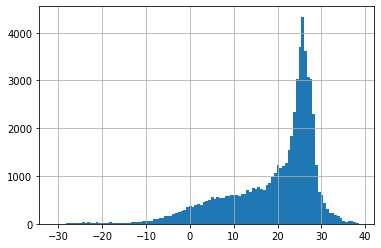

In [31]:
data_temp['Temperature'].hist(bins='auto')
data_temp['Temperature'].describe()

#### Year

In [32]:
display(data_temp['Year'].describe())
data_temp['Year'].value_counts()

count    61152.000000
mean      2003.500000
std          7.500061
min       1991.000000
25%       1997.000000
50%       2003.500000
75%       2010.000000
max       2016.000000
Name: Year, dtype: float64

2016    2352
1991    2352
2014    2352
2013    2352
2012    2352
2011    2352
2010    2352
2009    2352
2008    2352
2007    2352
2006    2352
2005    2352
2004    2352
2003    2352
2002    2352
2001    2352
2000    2352
1999    2352
1998    2352
1997    2352
1996    2352
1995    2352
1994    2352
1993    2352
1992    2352
2015    2352
Name: Year, dtype: int64

#### Month

In [33]:
display(data_temp['Month'].describe())
data_temp['Month'].value_counts()

count     61152
unique       12
top         Feb
freq       5096
Name: Month, dtype: object

Feb    5096
Jan    5096
Apr    5096
Sep    5096
Aug    5096
Oct    5096
Jul    5096
May    5096
Mar    5096
Jun    5096
Dec    5096
Nov    5096
Name: Month, dtype: int64

#### Country

In [34]:
display(data_temp['Country'].describe())
data_temp['Country'].unique()

count     61152
unique      195
top       Korea
freq        624
Name: Country, dtype: object

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia',
       'Cameroon', 'Canada', 'Cape Verde', 'Central African Republic',
       'Chad', 'Chile', 'China', 'Colombia', 'Comoros',
       'Congo (Democratic Republic of the)', 'Congo (Republic of the)',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus',
       'Czech Republic', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia',
       'Faroe Islands', 'Federated States of Micronesia', 'Fiji',
       'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany',
       'G

In [35]:
# Check if data contains all Countries we have in our country list
set(get_country_list()).difference(set(data_temp['Country'].unique()))

{'Slovak Republic'}

In [36]:
# --> Slovakia has to be renamed to Slovak Republic
data_temp.loc[data_temp['Country'] == 'Slovakia', 'Country'] = 'Slovak Republic'
set(get_country_list()).difference(set(data_temp['Country'].unique()))

set()

### Rainfall Data
#### Load and Transform Data

In [37]:
data_rain = pd.read_csv(RAIN_DATA, sep=',',
    names=['Rainfall', 'Year', 'Statistics', 'Country', 'ISO_Country',
           '_']).drop(0)
data_rain['Rainfall'] = data_rain['Rainfall'].astype(float)
data_rain['Month'] = data_rain['Statistics'].apply(lambda x: x.split()[0])
data_rain['Country'] = data_rain['Country'].apply(lambda x: x.lstrip())
data_rain['Year'] = data_rain['Year'].astype(int)

### Overview

In [38]:
data_rain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61152 entries, 1 to 61152
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Rainfall     61152 non-null  float64
 1   Year         61152 non-null  int64  
 2   Statistics   61152 non-null  object 
 3   Country      61152 non-null  object 
 4   ISO_Country  61152 non-null  object 
 5   _            1560 non-null   object 
 6   Month        61152 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 3.7+ MB


### Rainfall

count    61152.000000
mean       103.581125
std        114.130057
min          0.000000
25%         24.123175
50%         66.192300
75%        149.172000
max       2699.190000
Name: Rainfall, dtype: float64

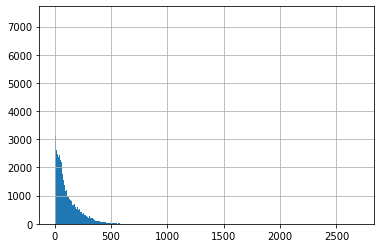

In [39]:
data_rain['Rainfall'].hist(bins='auto')
data_rain['Rainfall'].describe()

#### Year 

In [40]:
display(data_rain['Year'].describe())
data_rain['Year'].value_counts()

count    61152.000000
mean      2003.500000
std          7.500061
min       1991.000000
25%       1997.000000
50%       2003.500000
75%       2010.000000
max       2016.000000
Name: Year, dtype: float64

2016    2352
1991    2352
2014    2352
2013    2352
2012    2352
2011    2352
2010    2352
2009    2352
2008    2352
2007    2352
2006    2352
2005    2352
2004    2352
2003    2352
2002    2352
2001    2352
2000    2352
1999    2352
1998    2352
1997    2352
1996    2352
1995    2352
1994    2352
1993    2352
1992    2352
2015    2352
Name: Year, dtype: int64

#### Month

In [41]:
display(data_rain['Month'].describe())
data_rain['Month'].value_counts()

count     61152
unique       12
top         Feb
freq       5096
Name: Month, dtype: object

Feb    5096
Jan    5096
Apr    5096
Sep    5096
Aug    5096
Oct    5096
Jul    5096
May    5096
Mar    5096
Jun    5096
Dec    5096
Nov    5096
Name: Month, dtype: int64

#### Country

In [42]:
display(data_rain['Country'].describe())
data_rain['Country'].unique()

count     61152
unique      195
top       Korea
freq        624
Name: Country, dtype: object

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia',
       'Cameroon', 'Canada', 'Cape Verde', 'Central African Republic',
       'Chad', 'Chile', 'China', 'Colombia', 'Comoros',
       'Congo (Democratic Republic of the)', 'Congo (Republic of the)',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus',
       'Czech Republic', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia',
       'Faroe Islands', 'Federated States of Micronesia', 'Fiji',
       'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany',
       'G

In [43]:
# Check if data contains all Countries we have in our country list
set(get_country_list()).difference(set(data_rain['Country'].unique()))

{'Slovak Republic'}

In [44]:
# --> Slovakia has to be renamed to Slovak Republic
data_rain.loc[data_rain['Country'] == 'Slovakia', 'Country'] = 'Slovak Republic'
set(get_country_list()).difference(set(data_rain['Country'].unique()))

set()

### Merge Datasets
#### Check if Countries, Years and Months are identical

In [45]:
country_temp = set(data_temp['Country'].unique())
country_rain = set(data_rain['Country'].unique())
country_temp == country_rain

True

In [46]:
year_temp = set(data_temp['Year'].unique())
year_rain = set(data_rain['Year'].unique())
year_temp == year_rain

True

In [47]:
month_temp = set(data_temp['Month'].unique())
month_rain = set(data_rain['Month'].unique())
month_temp == month_rain

True

#### Merge

In [48]:
data_full = data_temp.merge(data_rain)

### Show change over time for all countries averaged
#### GroupBy Year and Country

In [49]:
by_year = data_full.groupby(['Year', 'Country']).agg(np.mean).reset_index()

#### Only show OECD Countries

In [50]:
by_year = by_year[by_year['Country'].isin(get_country_list())]

#### Plot Average Temperature by Country over Time

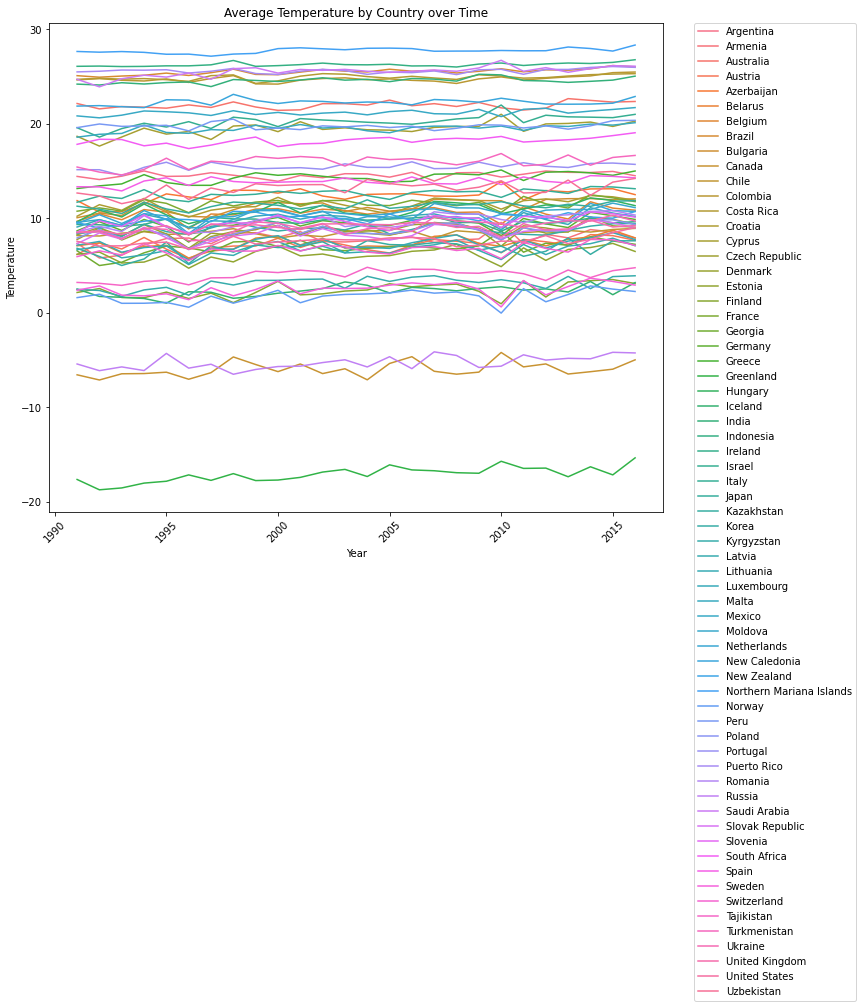

In [51]:
fig, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Average Temperature by Country over Time')

sns.lineplot(data=by_year.reset_index(),
             x='Year',
             y='Temperature',
             hue='Country')
plt.xticks(rotation=45)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

#### Plot Average Rainfall by Country over Time

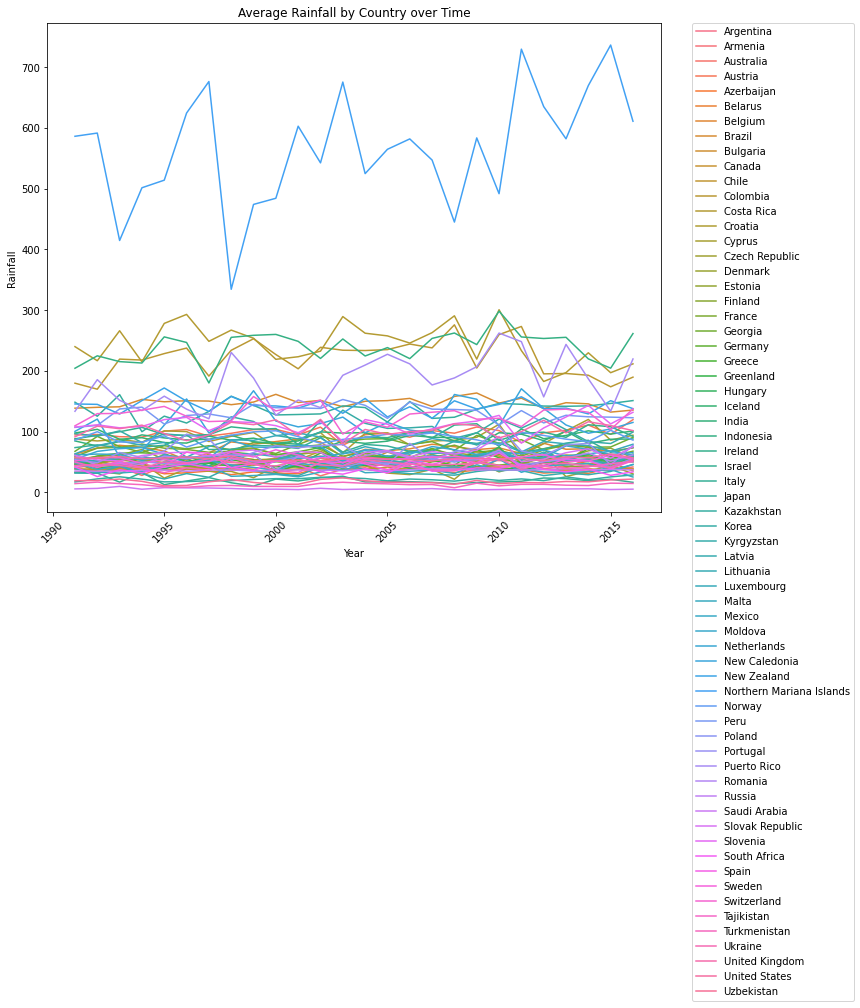

In [52]:
fig, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Average Rainfall by Country over Time')

sns.lineplot(data=by_year.reset_index(),
             x='Year',
             y='Rainfall',
             hue='Country')
plt.xticks(rotation=45)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

### Extract Temperature Features

In [53]:
features = pd.DataFrame(data_full['Country'].unique(), columns=['Country'])

def extract_slope(x, y):
    m, b = np.polyfit(x, y, 1)
    return m

def extract_gain_percentage(country_df, past_years=1):

    min_year = country_df['Year'].min()
    start_mean_temp = country_df[country_df['Year'] ==
                                 min_year]['Temperature'].mean()

    max_year = country_df['Year'].max()

    past_years_mean_temp = country_df[country_df['Year'] > (
        max_year - past_years)]['Temperature'].mean()

    return (past_years_mean_temp / start_mean_temp - 1) * 100

def extract_difference(country_df, past_years=1):
    min_year = country_df['Year'].min()
    start_mean_temp = country_df[country_df['Year'] ==
                                 min_year]['Temperature'].mean()

    max_year = country_df['Year'].max()

    past_years_mean_temp = country_df[country_df['Year'] > (
        max_year - past_years)]['Temperature'].mean()

    return past_years_mean_temp - start_mean_temp 

for country in features['Country'].unique():
    sel_c = data_full.loc[data_full['Country'] == country, :]
    
    ## extract temperature slope
    features.loc[features['Country'] == country,
                 'temp_slope'] = extract_slope(sel_c['Year'],
                                               sel_c['Temperature'])
    ## extract temperature gain percentage
    features.loc[features['Country'] == country,
                 'gain_percentage'] = extract_gain_percentage(sel_c)
    
    ## extract temperature difference
    features.loc[features['Country'] == country,
                 'temp_difference'] = extract_difference(sel_c)
    

In [54]:
ds_climate = features.copy()

## Greenhouse gasses
### Load Data

In [55]:
DATA_PATH = Path('./data')
AIR_GHG = DATA_PATH / 'OECD' / 'AIR_GHG.csv'

df = pd.read_csv(AIR_GHG)

### Data Exploration

In [56]:
df.columns

Index(['COU', 'Country', 'POL', 'Pollutant', 'VAR', 'Variable', 'YEA', 'Year',
       'Unit Code', 'Unit', 'PowerCode Code', 'PowerCode',
       'Reference Period Code', 'Reference Period', 'Value', 'Flag Codes',
       'Flags'],
      dtype='object')

In [57]:
df.head()

COU    Country  POL         Pollutant    VAR  \
0  AUS  Australia  GHG  Greenhouse gases  TOTAL   
1  AUS  Australia  GHG  Greenhouse gases  TOTAL   
2  AUS  Australia  GHG  Greenhouse gases  TOTAL   
3  AUS  Australia  GHG  Greenhouse gases  TOTAL   
4  AUS  Australia  GHG  Greenhouse gases  TOTAL   

                            Variable   YEA  Year   Unit Code  \
0  Total  emissions excluding LULUCF  1990  1990  T_CO2_EQVT   
1  Total  emissions excluding LULUCF  1991  1991  T_CO2_EQVT   
2  Total  emissions excluding LULUCF  1992  1992  T_CO2_EQVT   
3  Total  emissions excluding LULUCF  1993  1993  T_CO2_EQVT   
4  Total  emissions excluding LULUCF  1994  1994  T_CO2_EQVT   

                       Unit  PowerCode Code  PowerCode  Reference Period Code  \
0  Tonnes of CO2 equivalent               3  Thousands                    NaN   
1  Tonnes of CO2 equivalent               3  Thousands                    NaN   
2  Tonnes of CO2 equivalent               3  Thousands                    NaN   
3  Tonnes of CO2 equivalent               3  Thousands                    NaN   
4  Tonnes of CO2 equivalent               3  Thousands                    NaN   

   Reference Period       Value Flag Codes Flags  
0               NaN  424998.381        NaN   NaN  
1               NaN  426015.210        NaN   NaN  
2               NaN  430216.380        NaN   NaN  
3               NaN  430612.556        NaN   NaN  
4               NaN  430653.332        NaN   NaN

In [58]:
df.Country.unique()

array(['Australia', 'Austria', 'Belgium', 'Canada', 'Czech Republic',
       'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Hungary',
       'Iceland', 'Ireland', 'Italy', 'Japan', 'Korea', 'Luxembourg',
       'Mexico', 'Netherlands', 'New Zealand', 'Norway', 'Poland',
       'Portugal', 'Slovak Republic', 'Spain', 'Sweden', 'Switzerland',
       'Turkey', 'United Kingdom', 'United States', 'Chile', 'Estonia',
       'Israel', 'Russia', 'Slovenia', 'Latvia', 'Lithuania',
       'OECD - Total', 'OECD - Europe', 'Brazil',
       "China (People's Republic of)", 'Colombia', 'Costa Rica', 'India',
       'Indonesia', 'South Africa', 'Argentina',
       'European Union (28 countries)'], dtype=object)

In [59]:
df.describe()

YEA          Year  PowerCode Code  Reference Period Code  \
count  52578.000000  52578.000000    52578.000000                    0.0   
mean    2003.962741   2003.962741        1.434726                    NaN   
std        8.258551      8.258551        1.498593                    NaN   
min     1990.000000   1990.000000        0.000000                    NaN   
25%     1997.000000   1997.000000        0.000000                    NaN   
50%     2004.000000   2004.000000        0.000000                    NaN   
75%     2011.000000   2011.000000        3.000000                    NaN   
max     2018.000000   2018.000000        3.000000                    NaN   

       Reference Period         Value  
count               0.0  5.257800e+04  
mean                NaN  1.421543e+05  
std                 NaN  1.652310e+06  
min                 NaN -1.479158e+06  
25%                 NaN  1.718825e+01  
50%                 NaN  1.014720e+02  
75%                 NaN  7.697484e+03  
max                 NaN  9.731788e+07

### Resolve Power

In [60]:
df.Value = df.Value * 10 **  df['PowerCode Code']

### Filter only for totals

In [61]:
df = df[df['VAR'] == 'TOTAL']

### Drop Estimates

In [62]:
df = df[df['Flag Codes'].isnull()]

### Delete unneaded columns

In [63]:
df = df.drop(labels=['COU','Pollutant', 'VAR', 'Variable', 'Year', 'Unit Code', 'Unit', 'PowerCode Code', 'PowerCode', 'Reference Period Code', 'Reference Period', 'Flag Codes', 'Flags'], axis=1)

### Delete old Data (< 2005)

In [64]:
df = df[df.YEA > 2005]

### Normalize Data

In [65]:
DATA_PATH = Path('./data')
HISTPOP = DATA_PATH / 'OECD' / 'HISTPOP.csv'

pop = pd.read_csv(HISTPOP)
pop = pop[pop.SEX == 'T']
pop = pop[pop.AGE == 'TOTAL']

for i in df.index:
    ctr = df['Country'][i]
    yea = df['YEA'][i]
    norm = pop[(pop.Country == ctr) & (pop.Time == yea)].Value
    if norm.empty:
        norm = 1.0
    
    df['Value'][i]=  df['Value'][i] / norm

### Transform data into years

In [66]:
df = df.pivot(index=['Country', 'POL'], columns='YEA', values=['Value']).reset_index()

df['2019'] = np.NaN
df['2020'] = np.NaN

### Extract Polution Type

In [67]:
CH4 = df[df['POL'] == 'CH4']
CO2 = df[df['POL'] == 'CO2']
HFC = df[df['POL'] == 'HFC']
HFC_PFC = df[df['POL'] == 'HFC_PFC']
N2O = df[df['POL'] == 'N2O']
NF3 = df[df['POL'] == 'NF3']
PFC = df[df['POL'] == 'PFC']
SF6 = df[df['POL'] == 'SF6']

CH4 = CH4.drop(labels=['POL'], axis=1)
CO2 = CO2.drop(labels=['POL'], axis=1)
HFC = HFC.drop(labels=['POL'], axis=1)
HFC_PFC = HFC_PFC.drop(labels=['POL'], axis=1)
N2O = N2O.drop(labels=['POL'], axis=1)
NF3 = NF3.drop(labels=['POL'], axis=1)
PFC = PFC.drop(labels=['POL'], axis=1)
SF6 = SF6.drop(labels=['POL'], axis=1)

### Check if 2020 can be auto filled

<AxesSubplot:title={'center':'SF6'}, xlabel='None,YEA'>

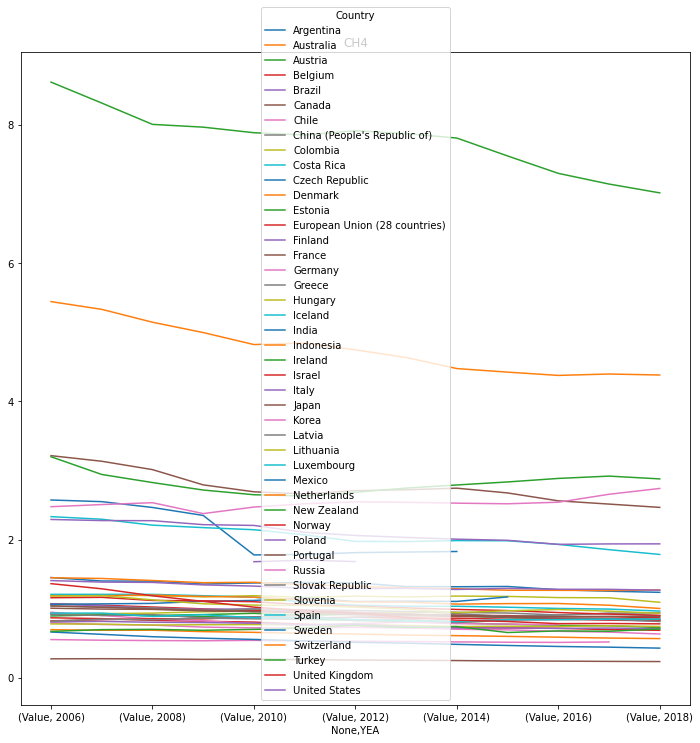

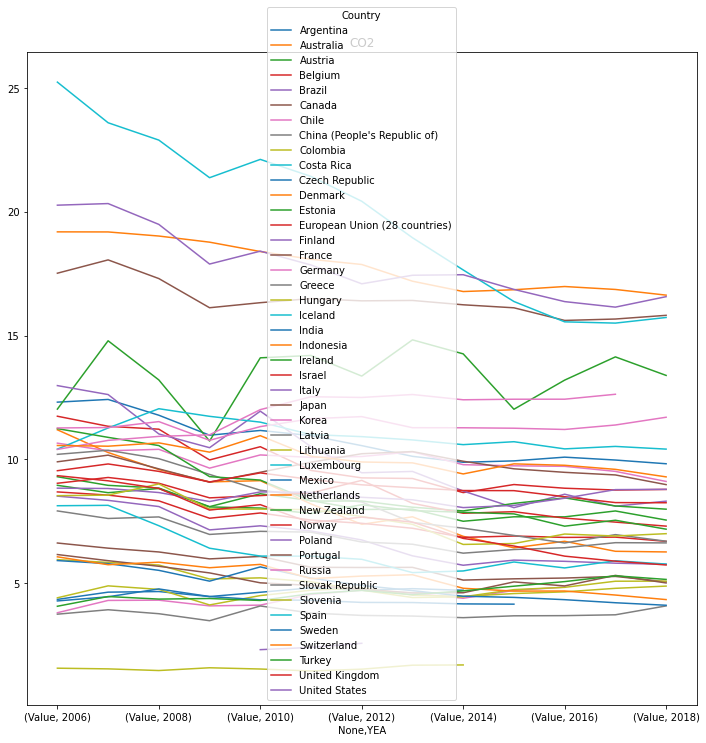

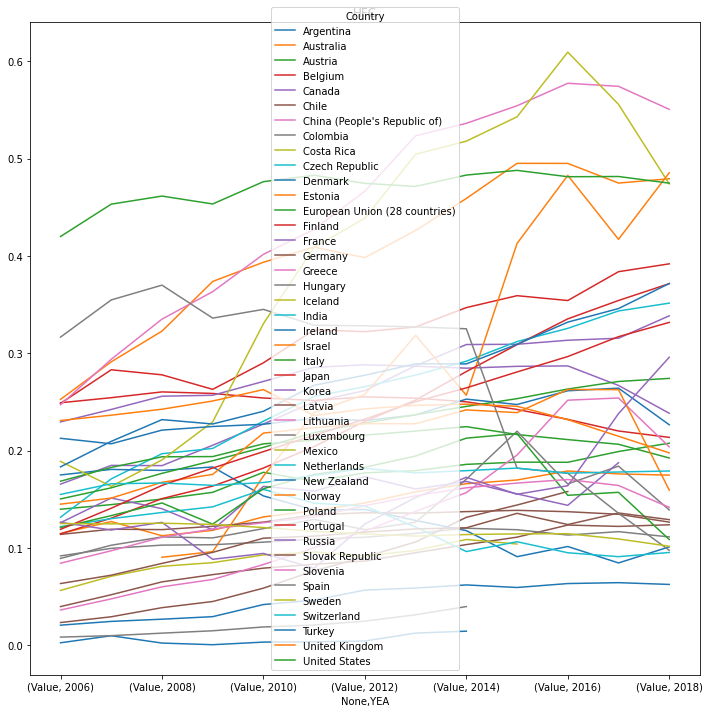

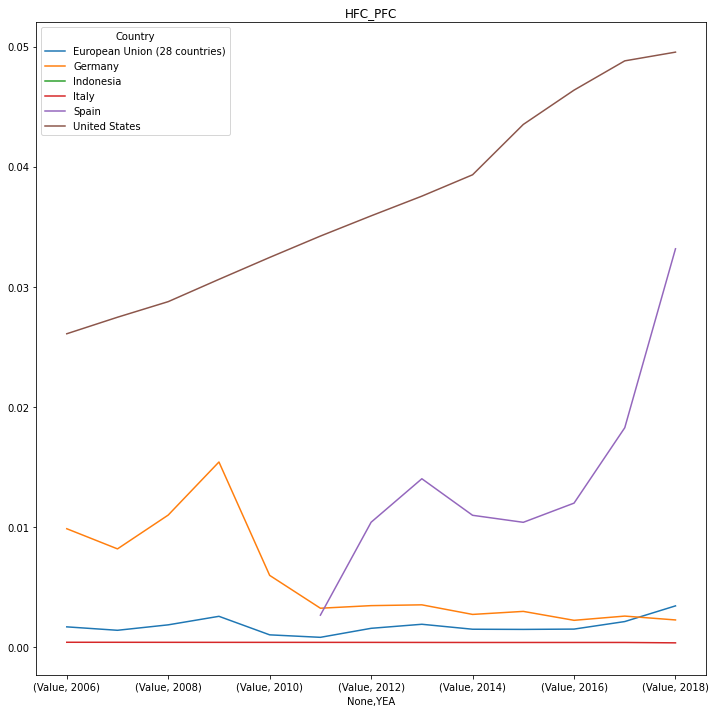

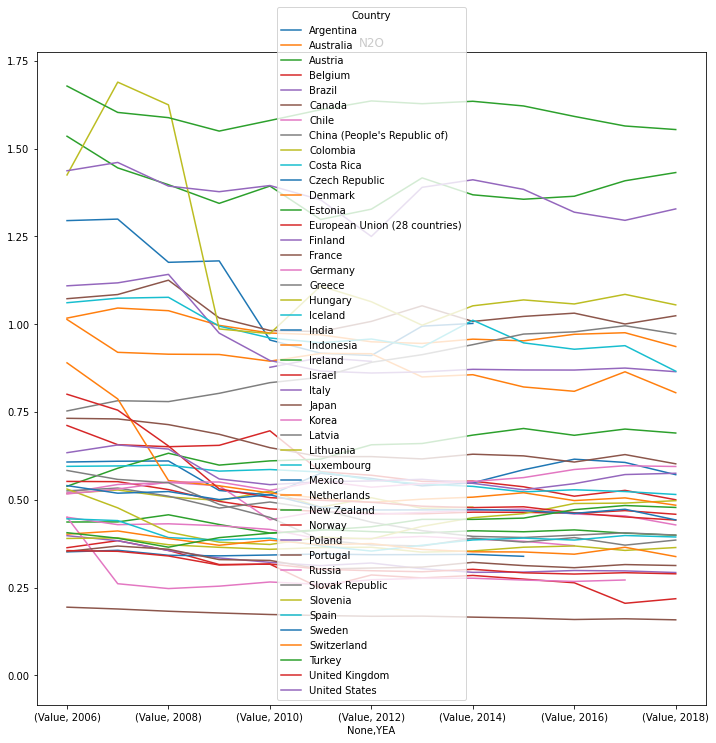

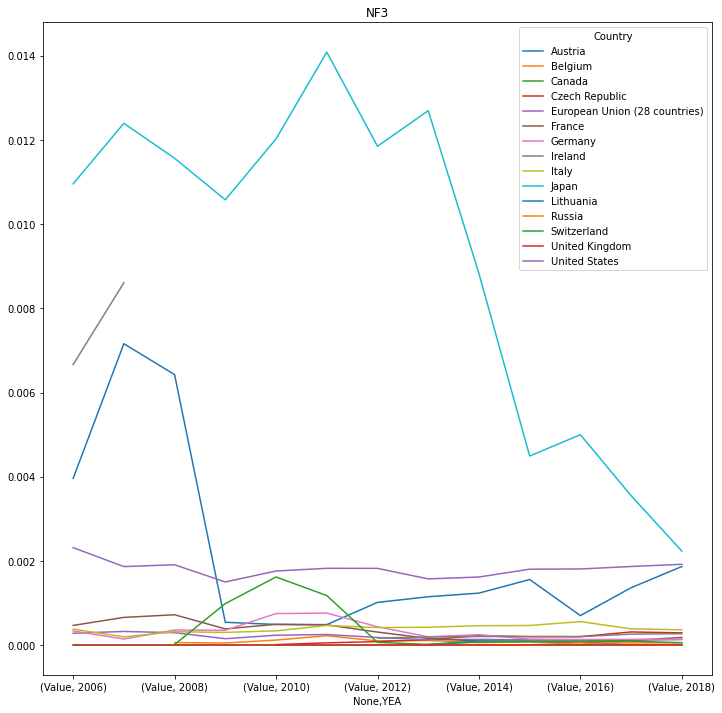

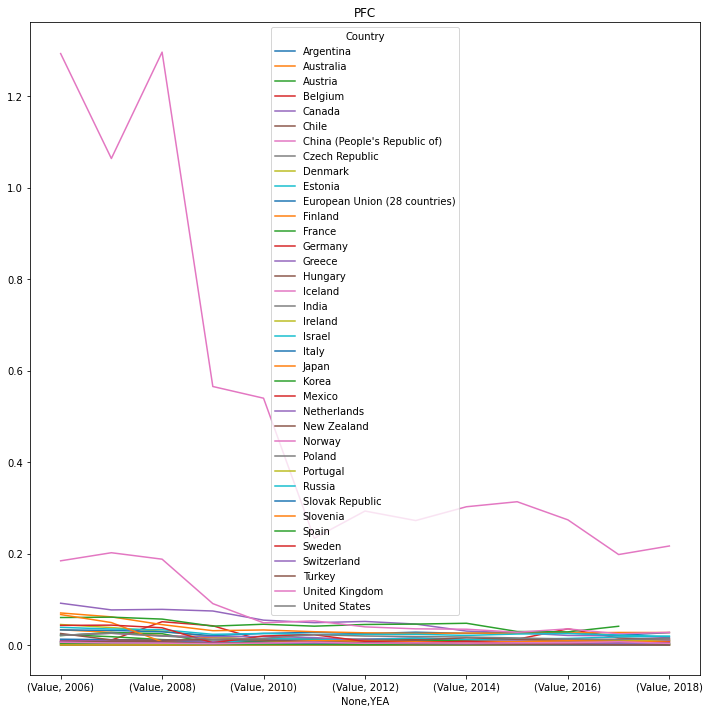

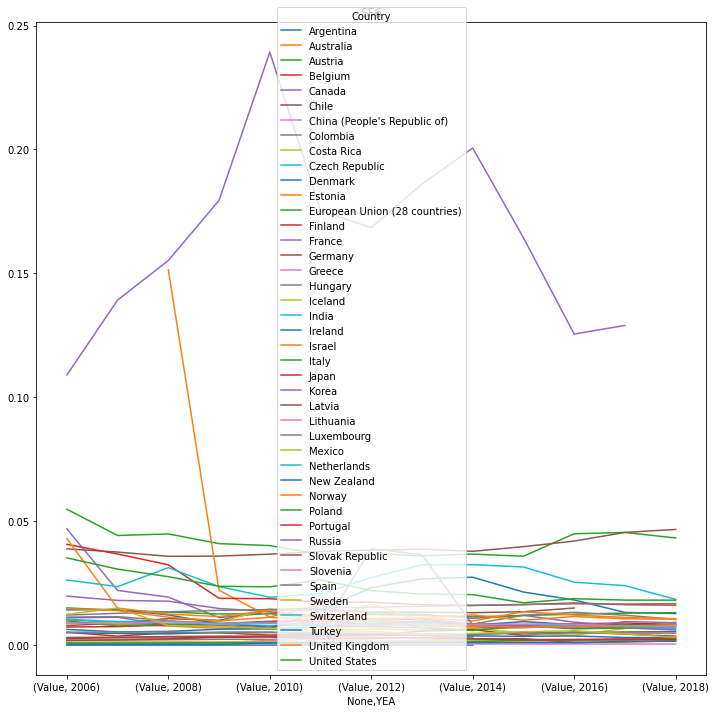

In [68]:
CH4.set_index('Country').transpose().plot(figsize=(12,12), title='CH4')
CO2.set_index('Country').transpose().plot(figsize=(12,12), title='CO2')
HFC.set_index('Country').transpose().plot(figsize=(12,12), title='HFC')
HFC_PFC.set_index('Country').transpose().plot(figsize=(12,12), title='HFC_PFC')
N2O.set_index('Country').transpose().plot(figsize=(12,12), title='N2O')
NF3.set_index('Country').transpose().plot(figsize=(12,12), title='NF3')
PFC.set_index('Country').transpose().plot(figsize=(12,12), title='PFC')
SF6.set_index('Country').transpose().plot(figsize=(12,12), title='SF6')

### Autofill 2020

In [69]:
CH4 = CH4.transpose().fillna(method='ffill').transpose()
CO2 = CO2.transpose().fillna(method='ffill').transpose()
HFC = HFC.transpose().fillna(method='ffill').transpose()
HFC_PFC = HFC_PFC.transpose().fillna(method='ffill').transpose()
N2O = N2O.transpose().fillna(method='ffill').transpose()
NF3 = NF3.transpose().fillna(method='ffill').transpose()
PFC = PFC.transpose().fillna(method='ffill').transpose()
SF6 = SF6.transpose().fillna(method='ffill').transpose()

conc = [
    CH4[['Country', '2020']].set_index('Country'),
    CO2[['Country', '2020']].set_index('Country'),
    HFC[['Country', '2020']].set_index('Country'),
    HFC_PFC[['Country', '2020']].set_index('Country'),
    N2O[['Country', '2020']].set_index('Country'),
    NF3[['Country', '2020']].set_index('Country'),
    PFC[['Country', '2020']].set_index('Country'),
    SF6[['Country', '2020']].set_index('Country'),
]

res = pd.concat(conc, axis=1, join='outer')
res.columns = ['CH4', 'CO2', 'HFC', 'HFC_PFC', 'N2O', 'NF3', 'PFC', 'SF6']

res

CH4        CO2       HFC   HFC_PFC  \
Country                                                                  
Argentina                      1.828861   4.710241   0.01437       NaN   
Australia                       4.38254  16.642911   0.47942       NaN   
Austria                        0.728541   7.549433  0.207606       NaN   
Belgium                         0.68826   8.787278  0.391962       NaN   
Brazil                         1.683181   2.566549       NaN       NaN   
Canada                         2.466998  15.826302  0.338527       NaN   
Chile                          0.767192   4.837817  0.157948       NaN   
China (People's Republic of)   0.853622   7.194057   0.11236       NaN   
Colombia                       0.946694   1.691487   0.03967       NaN   
Costa Rica                     0.820945   1.651245  0.125102       NaN   
Czech Republic                 1.237946   9.825615  0.351586       NaN   
Denmark                        1.272634   6.260186  0.101028       NaN   
Estonia                        0.845256  13.397323  0.174761       NaN   
European Union (28 countries)  0.869149   6.687756  0.192399  0.003425   
Finland                        0.823286   8.312781  0.213589       NaN   
France                         0.844018   5.054056  0.238381       NaN   
Germany                        0.634896    9.11017  0.126482  0.002254   
Greece                         0.940815   6.693887  0.550778       NaN   
Hungary                        0.744502    5.08093  0.139033       NaN   
Iceland                        1.786166  10.417635  0.474101       NaN   
India                          0.334763    1.27895  0.000014       NaN   
Indonesia                      0.711852   2.490887       NaN  0.000155   
Ireland                        2.879337   7.989144  0.226551       NaN   
Israel                         0.831843   7.303624  0.485538       NaN   
Italy                          0.712204   5.760918  0.274235  0.000346   
Japan                          0.236113   8.981805  0.371611       NaN   
Korea                          0.519825  12.634908  0.187555       NaN   
Latvia                         0.899544   4.078149  0.123763       NaN   
Lithuania                      1.093803   4.879276  0.203895       NaN   
Luxembourg                     0.966622  15.738992  0.111259       NaN   
Mexico                         1.171375   4.149015  0.103972       NaN   
Netherlands                    1.004478   9.295129  0.095269       NaN   
New Zealand                    7.017958   7.180502  0.371743       NaN   
Norway                         0.904485   8.248936  0.159356       NaN   
Poland                         1.269181   8.791412  0.108627       NaN   
Portugal                       0.887454   5.006162  0.331768       NaN   
Russia                         2.740886  11.705637  0.295945       NaN   
Slovak Republic                0.815535   6.625547  0.129025       NaN   
Slovenia                       0.935319   6.998789  0.141656       NaN   
Spain                          0.849984   5.770099  0.097526  0.033168   
Sweden                         0.430511   4.104698  0.101708       NaN   
Switzerland                    0.568525   4.333901  0.179021       NaN   
Turkey                         0.707261   5.149356  0.062426       NaN   
United Kingdom                 0.781754   5.732622  0.197676       NaN   
United States                  1.939243  16.581362  0.474912  0.049548   

                                    N2O       NF3       PFC       SF6  
Country                                                                
Argentina                      1.002114       NaN  0.003744  0.000042  
Australia                      0.804808       NaN  0.009443  0.009144  
Austria                        0.398982  0.001868   0.00368  0.043241  
Belgium                        0.500037  0.000057  0.011516  0.008337  
Brazil                         0.894033       NaN       NaN       NaN  
Canada                         1.023899  0.000003  0.

### Remove unclear columns (Columns with too many missing values)

In [70]:
res = res.drop('HFC_PFC', axis=1)
res = res.fillna(-1)

### Save Dataset

In [71]:
res = res.reset_index(drop=False)
res = res.rename(columns={'index':'Country'})

ds_ghg = res.copy()

## Land Cover
Data about land cover of several OECD and non OECD countries (https://stats.oecd.org/Index.aspx?DataSetCode=LAND_COVER#)

### Data Specifications
The obtained data set contains several variables about the land cover of given countries. The values are stored as relative numbers to the total area and as absolute numbers in square kilometers. The data is recorded for the years 1992, 2004, 2015 and 2018. We want to investigate whether we can use the latest record as an approximation of the 2020 data, as we expect that the texture of the land does not change significantly over a short period of time.

In [72]:
DATA_PATH = Path('./data')
LAND_COVER = DATA_PATH / 'OECD' / 'LAND_COVER_DATA.csv'
TOTAL_AREA =  DATA_PATH / 'Worldbank' / 'API_AG.SRF.TOTL.K2_DS2_en_csv_v2_1927208.csv'

land_cover = pd.read_csv(LAND_COVER)
land_cover.shape

(17694, 21)

In [73]:
land_cover.head()

COU    Country SMALL_SUBNATIONAL_REGION Small subnational region  \
0  AUS  Australia                    TOTAL                    Total   
1  AUS  Australia                    TOTAL                    Total   
2  AUS  Australia                    TOTAL                    Total   
3  AUS  Australia                    TOTAL                    Total   
4  AUS  Australia                    TOTAL                    Total   

  LARGE_SUBNATIONAL_REGION Large subnational region           MEAS  \
0                    TOTAL                    Total  THOUSAND_SQKM   
1                    TOTAL                    Total  THOUSAND_SQKM   
2                    TOTAL                    Total  THOUSAND_SQKM   
3                    TOTAL                    Total  THOUSAND_SQKM   
4                    TOTAL                    Total  THOUSAND_SQKM   

                     Measure VARIABLE Land cover class  ...  Year  Unit Code  \
0  Square kilometers (000's)   FOREST       Tree cover  ...  1992        NaN   
1  Square kilometers (000's)   FOREST       Tree cover  ...  2004        NaN   
2  Square kilometers (000's)   FOREST       Tree cover  ...  2015        NaN   
3  Square kilometers (000's)   FOREST       Tree cover  ...  2018        NaN   
4  Square kilometers (000's)     GRSL        Grassland  ...  1992        NaN   

   Unit  PowerCode Code  PowerCode Reference Period Code  Reference Period  \
0   NaN               0      Units                   NaN               NaN   
1   NaN               0      Units                   NaN               NaN   
2   NaN               0      Units                   NaN               NaN   
3   NaN               0      Units                   NaN               NaN   
4   NaN               0      Units                   NaN               NaN   

         Value  Flag Codes  Flags  
0   911.890687         NaN    NaN  
1   890.559607         NaN    NaN  
2   896.524077         NaN    NaN  
3   904.706598         NaN    NaN  
4  1205.405426         NaN    NaN  

[5 rows x 21 columns]

In [74]:
#number of unique values per column
land_cover.nunique()

COU                           246
Country                       246
SMALL_SUBNATIONAL_REGION        1
Small subnational region        1
LARGE_SUBNATIONAL_REGION        1
Large subnational region        1
MEAS                            2
Measure                         2
VARIABLE                        9
Land cover class                9
YEA                             4
Year                            4
Unit Code                       0
Unit                            0
PowerCode Code                  1
PowerCode                       1
Reference Period Code           0
Reference Period                0
Value                       12556
Flag Codes                      0
Flags                           0
dtype: int64

In [75]:
#for our analysis we use the relative data, to make it comparable across countries of different sizes
land_cover_rel = land_cover.copy()
land_cover_rel = land_cover_rel[land_cover_rel['MEAS'] == 'PCNT']
land_cover_rel.shape

(8838, 21)

In [76]:
#we look at the unique countries (246 as shown before) in our new data frame 
land_cover_rel.Country.unique()

array(['Australia', 'Belgium', 'Canada', 'Czech Republic', 'Denmark',
       'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland',
       'Ireland', 'Italy', 'Japan', 'Luxembourg', 'Mexico', 'New Zealand',
       'Norway', 'Poland', 'Portugal', 'Slovak Republic', 'Spain',
       'Sweden', 'Switzerland', 'Turkey', 'United Kingdom',
       'United States', 'Albania', 'Algeria', 'American Samoa', 'Andorra',
       'Angola', 'Argentina', 'Aruba', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cambodia', 'Cabo Verde', 'Cayman Islands', 'Chad',
       "China (People's Republic of)", 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Côte d'Ivoire", 'Croatia', 'Cuba', 'Cyprus',
       "Democratic People's Republic of Korea",
       'Democratic Republic of the Congo', 'Djibouti',
       'Dominica

In [77]:
#There are several entries that summarize a number of countries, which we remove
remove = ['OECD - Total','European Union (28 countries)','OECD - Europe','BRIICS economies - Brazil, Russia, India, Indonesia, China and South Africa','OECD Asia Oceania','OECD America','Latin America and Caribbean','Middle East and North Africa','G20']
land_cover_rel = land_cover_rel[~land_cover_rel['Country'].isin(remove)]
land_cover_rel.shape

(8514, 21)

In [78]:
#select subset of relevant columns Country, Year, Land cover class and Value
land_cover_rel = land_cover_rel[['Country', 'Year', 'Land cover class', 'Value']]
land_cover_rel.head()

Country  Year     Land cover class     Value
16  Australia  1992  Artificial surfaces  0.100015
17  Australia  2004  Artificial surfaces  0.136482
18  Australia  2015  Artificial surfaces  0.154930
19  Australia  2018  Artificial surfaces  0.159319
20  Australia  1992         Inland water  0.171305

In [79]:
#list of all land cover attributes
land_cover_rel['Land cover class'].unique()

array(['Artificial surfaces', 'Inland water', 'Bare area', 'Tree cover',
       'Shrubland', 'Sparse vegetation', 'Cropland', 'Wetland',
       'Grassland'], dtype=object)

In [80]:
#no missing values
land_cover_rel.isna().sum()
land_cover_rel

Country  Year     Land cover class      Value
16      Australia  1992  Artificial surfaces   0.100015
17      Australia  2004  Artificial surfaces   0.136482
18      Australia  2015  Artificial surfaces   0.154930
19      Australia  2018  Artificial surfaces   0.159319
20      Australia  1992         Inland water   0.171305
...           ...   ...                  ...        ...
17653       Sudan  2004             Cropland  20.276832
17658  Kazakhstan  1992         Inland water   6.825496
17659  Kazakhstan  2004         Inland water   6.486520
17660  Kazakhstan  2015         Inland water   6.214264
17661  Kazakhstan  2018         Inland water   6.247544

[8514 rows x 4 columns]

In [81]:
#setting year and country as index and our targets as columns
land_cover_rel = land_cover_rel.pivot_table(index=['Country','Year'],columns='Land cover class', values='Value')
land_cover_rel.columns.name = None
land_cover_rel.head()

Artificial surfaces  Bare area   Cropland  Grassland  \
Country     Year                                                         
Afghanistan 1992             0.052857  39.283534  12.584400  36.040998   
            2004             0.081033  39.527342  12.131194  37.041703   
            2015             0.125987  39.126500  12.227564  37.305171   
            2018             0.144171  39.153980  12.120421  37.161205   
Albania     1992             0.607273   1.840586  54.521300   5.444811   

                  Inland water  Shrubland  Sparse vegetation  Tree cover  \
Country     Year                                                           
Afghanistan 1992      0.405237   3.741778           6.647211    1.234941   
            2004      0.105870   3.547692           6.325024    1.229056   
            2015      0.099157   3.545375           6.330105    1.229056   
            2018      0.099181   3.545002           6.528826    1.236130   
Albania     1992      2.193421   3.337453           1.321790   30.452653   

                   Wetland  
Country     Year            
Afghanistan 1992  0.009044  
            2004  0.011085  
            2015  0.011085  
            2018  0.011085  
Albania     1992  0.280713

In [82]:
land_cover_rel.shape

(946, 9)

In [83]:
#descriptive statistics about our attributes
land_cover_rel.describe()

Artificial surfaces   Bare area    Cropland   Grassland  Inland water  \
count           946.000000  946.000000  946.000000  946.000000    946.000000   
mean              2.755982   12.296451   27.321687    8.841653      5.854319   
std               9.154760   26.426937   22.535251   15.258184     13.569271   
min               0.000000    0.000000    0.000000    0.000000      0.000000   
25%               0.093574    0.000000    7.722103    0.098573      0.780424   
50%               0.375240    0.072102   22.991964    2.734328      1.669853   
75%               1.551601    4.175463   44.169074   10.908914      4.478559   
max             100.000000   99.876168   88.623811   88.624788    100.000000   

        Shrubland  Sparse vegetation  Tree cover     Wetland  
count  946.000000         946.000000  946.000000  946.000000  
mean     5.421904           3.055943   33.070767    1.381294  
std     11.064224           6.577833   28.231326    3.682244  
min      0.000000           0.000000    0.000000    0.000000  
25%      0.000000           0.007788    5.430741    0.000967  
50%      0.412425           0.144333   30.987333    0.116634  
75%      5.560123           3.180561   57.711595    0.709425  
max     77.445749          46.969990   97.589857   33.226605

In [84]:
#for better visualization, we only plot the values for the countries in our country list 
OECD_COUNTRIES = get_country_list()
land_cover_OECD = land_cover_rel.loc[OECD_COUNTRIES]
land_cover_OECD.shape

(260, 9)

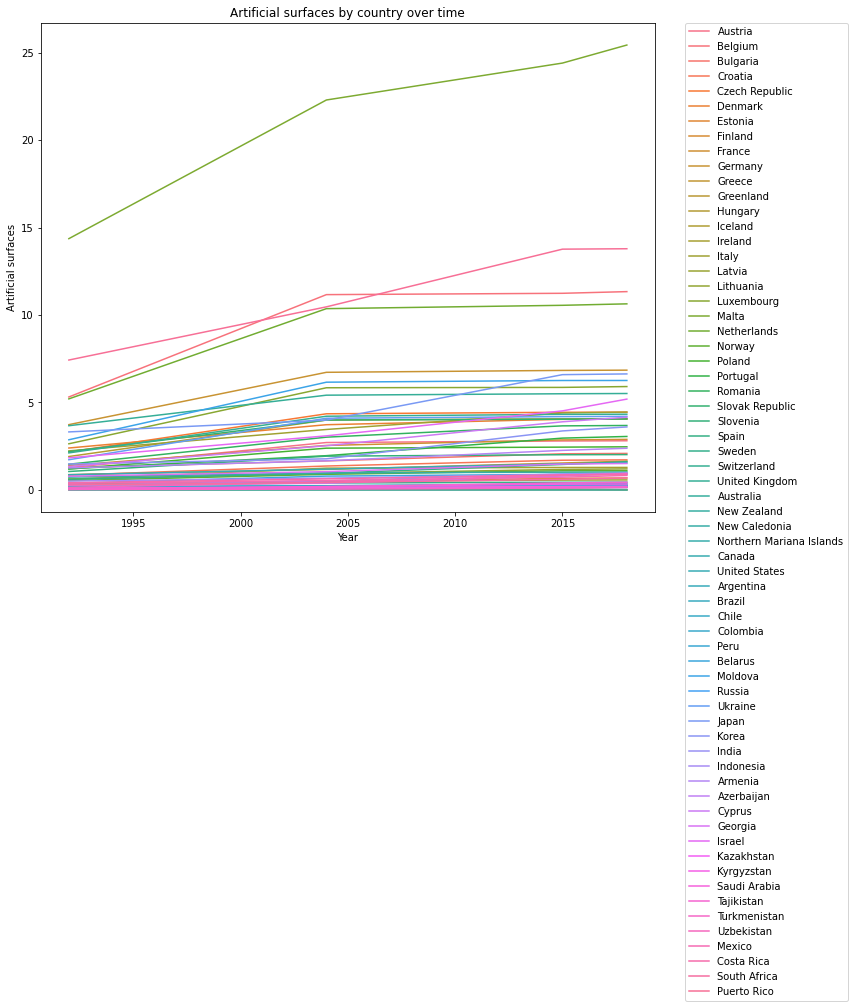

In [85]:
#plot the artifical surfaces over years by country
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Artificial surfaces by country over time')

sns.lineplot(
    data=land_cover_OECD.reset_index(),
    x='Year',
    y='Artificial surfaces',
    hue="Country")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

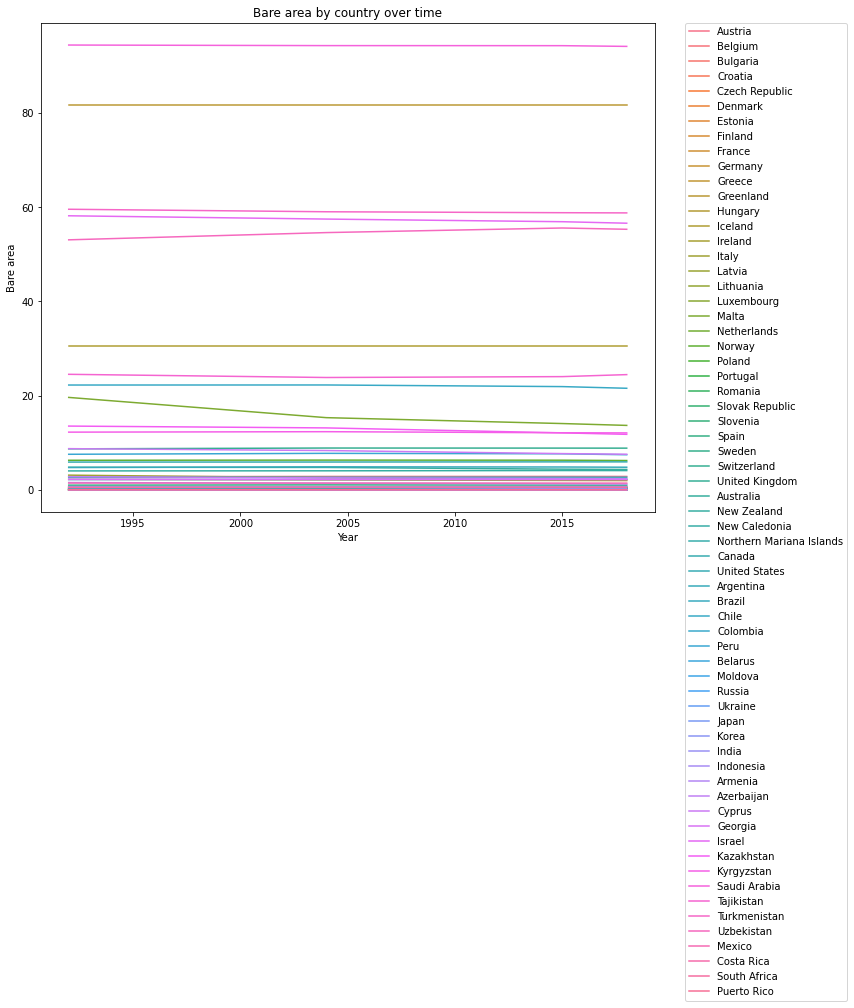

In [86]:
#plot the bare area over years by country
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Bare area by country over time')

sns.lineplot(
    data=land_cover_OECD.reset_index(),
    x='Year',
    y='Bare area',
    hue="Country")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

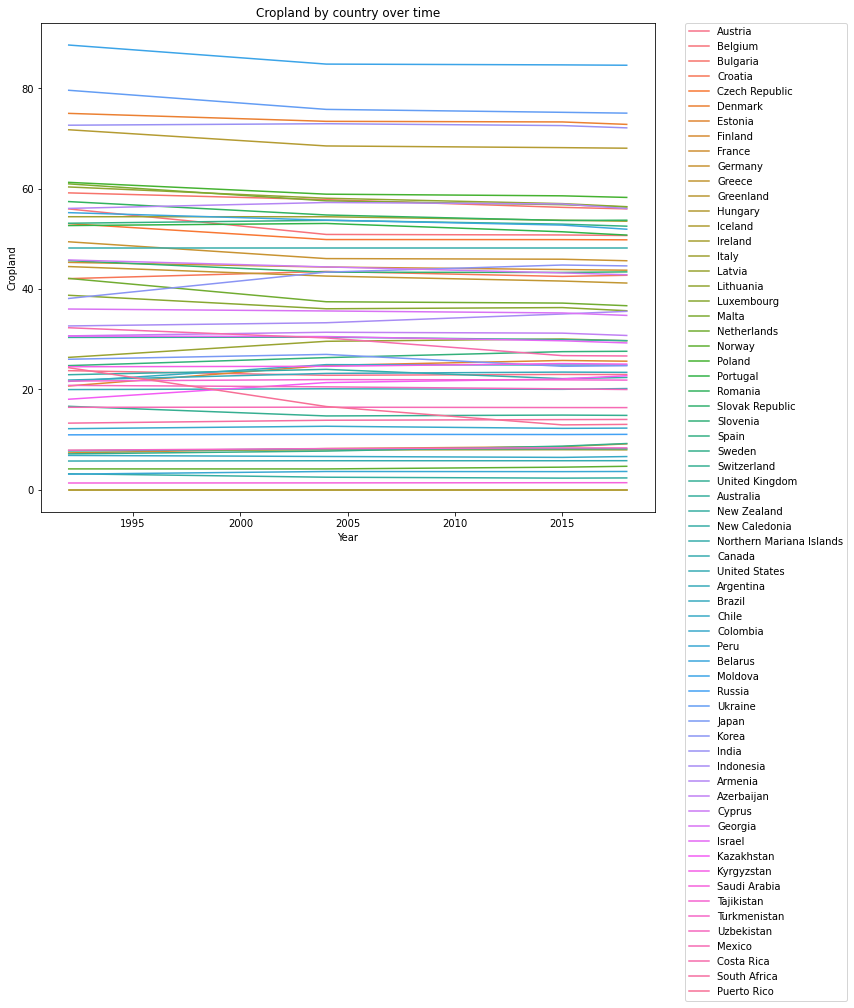

In [87]:
#plot the cropland over years by country
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Cropland by country over time')

sns.lineplot(
    data=land_cover_OECD.reset_index(),
    x='Year',
    y='Cropland',
    hue="Country")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

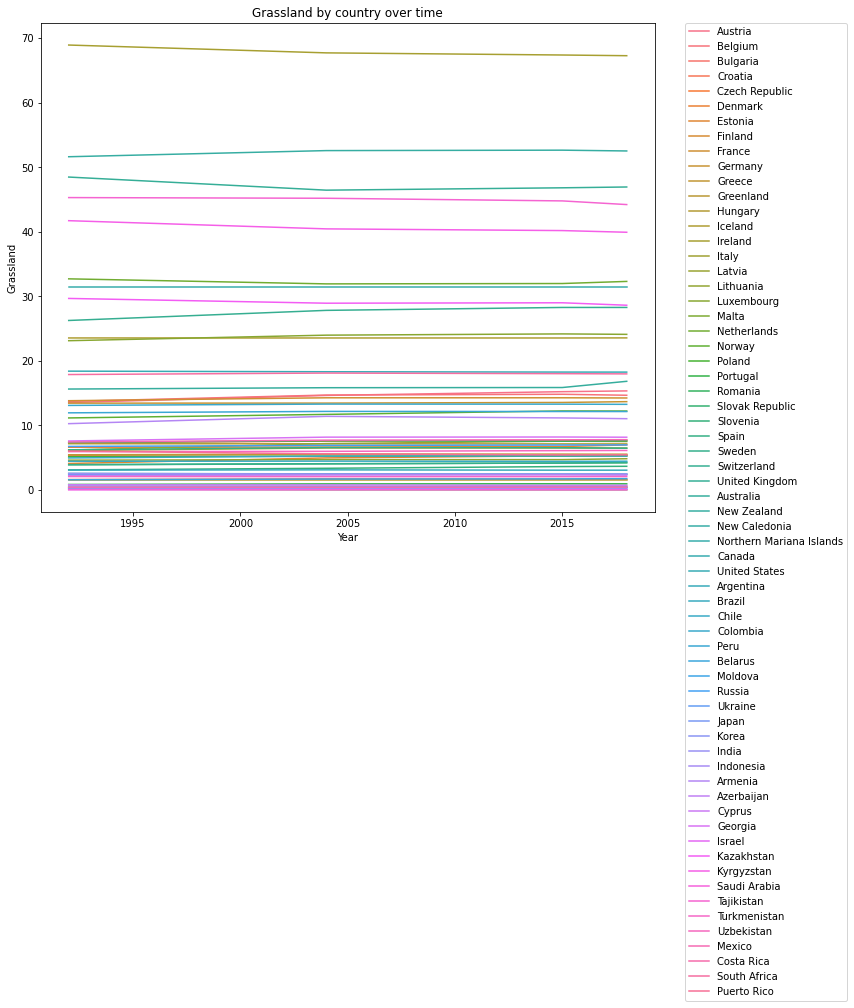

In [88]:
#plot the grassland over years by country
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Grassland by country over time')

sns.lineplot(
    data=land_cover_OECD.reset_index(),
    x='Year',
    y='Grassland',
    hue="Country")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

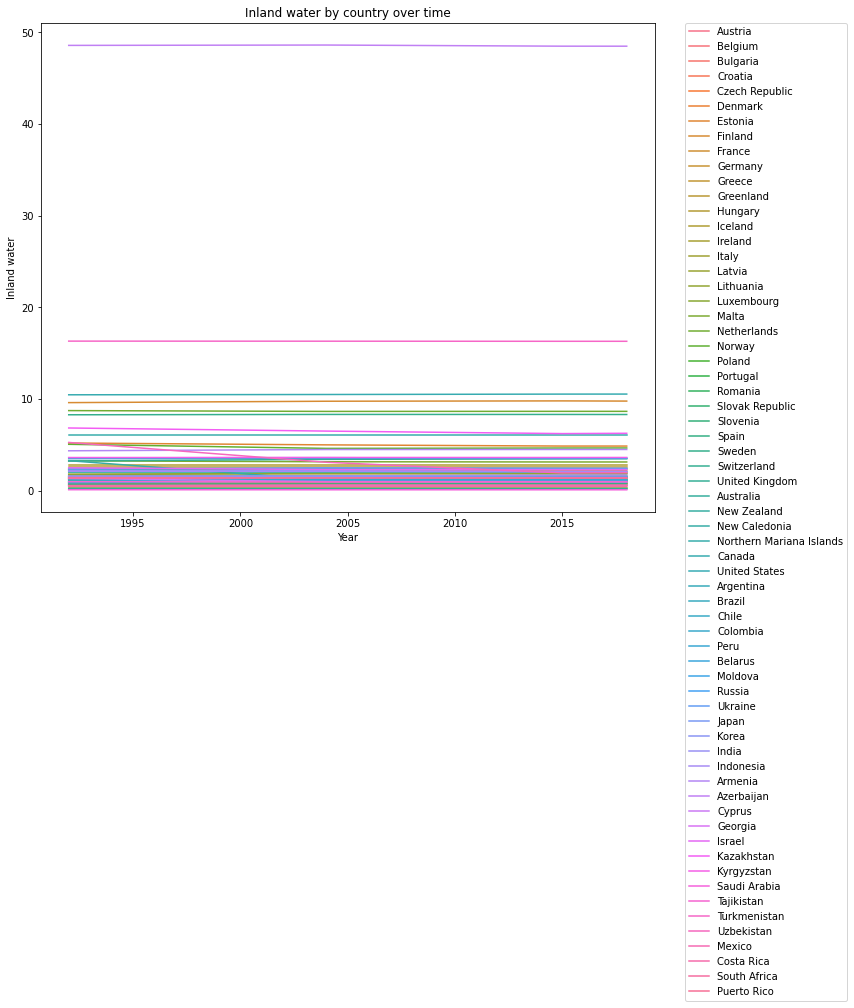

In [89]:
#plot the inland water over years by country
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Inland water by country over time')

sns.lineplot(
    data=land_cover_OECD.reset_index(),
    x='Year',
    y='Inland water',
    hue="Country")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

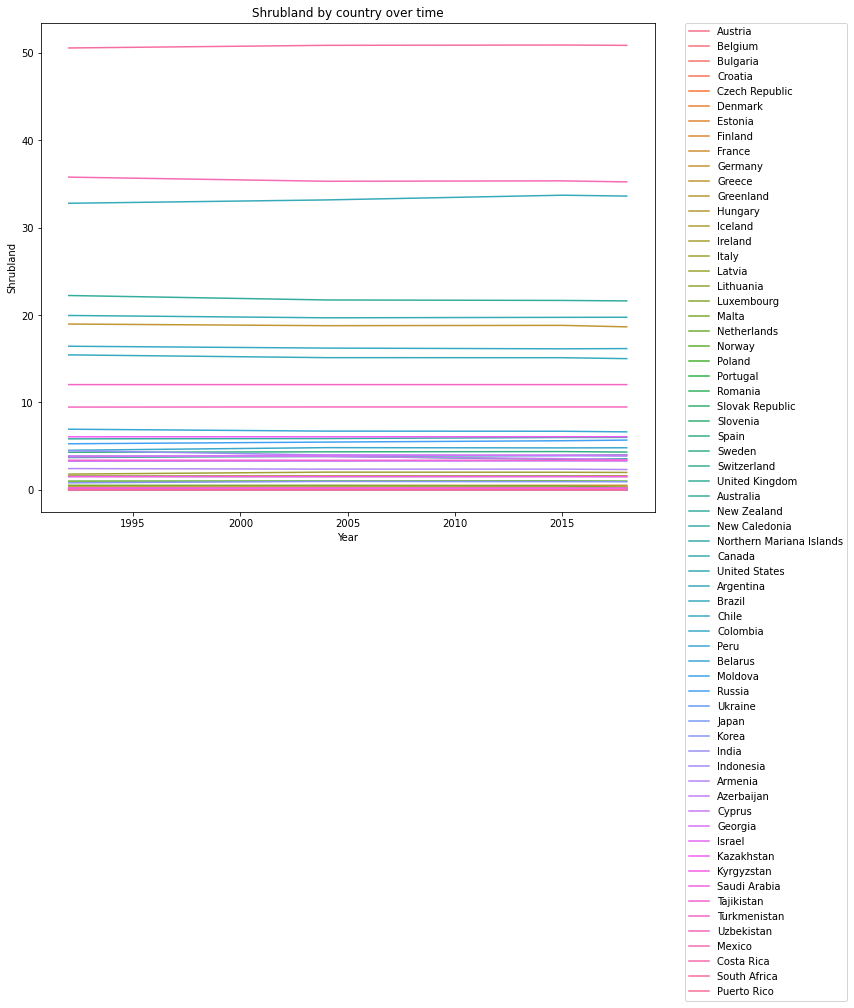

In [90]:
#plot the shrubland over years by country
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Shrubland by country over time')

sns.lineplot(
    data=land_cover_OECD.reset_index(),
    x='Year',
    y='Shrubland',
    hue="Country")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

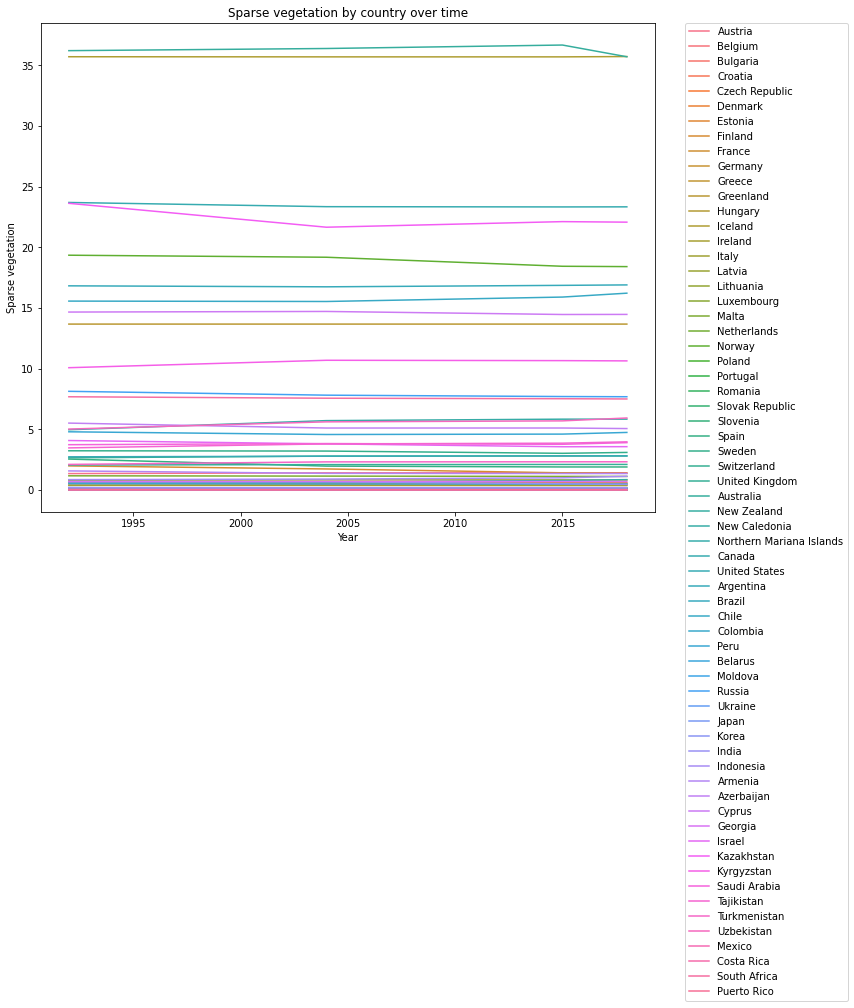

In [91]:
#plot the sparse vegetation over years by country
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Sparse vegetation by country over time')

sns.lineplot(
    data=land_cover_OECD.reset_index(),
    x='Year',
    y='Sparse vegetation',
    hue="Country")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

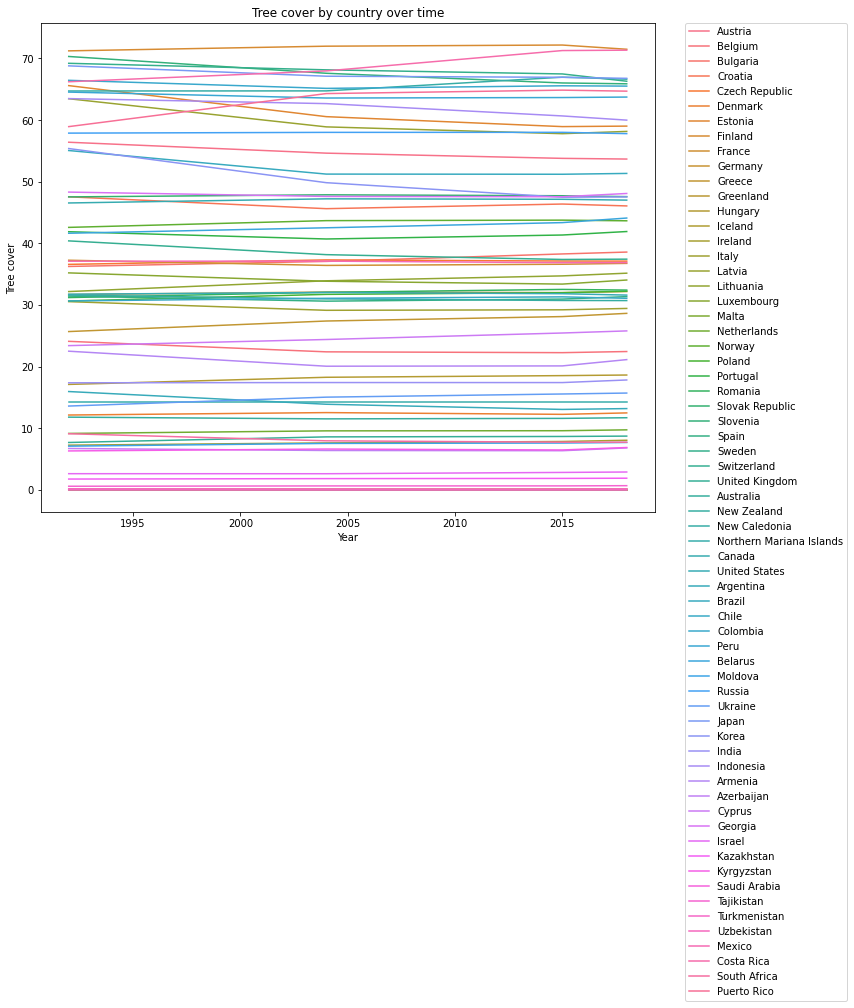

In [92]:
#plot the tree cover over years by country
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Tree cover by country over time')

sns.lineplot(
    data=land_cover_OECD.reset_index(),
    x='Year',
    y='Tree cover',
    hue="Country")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

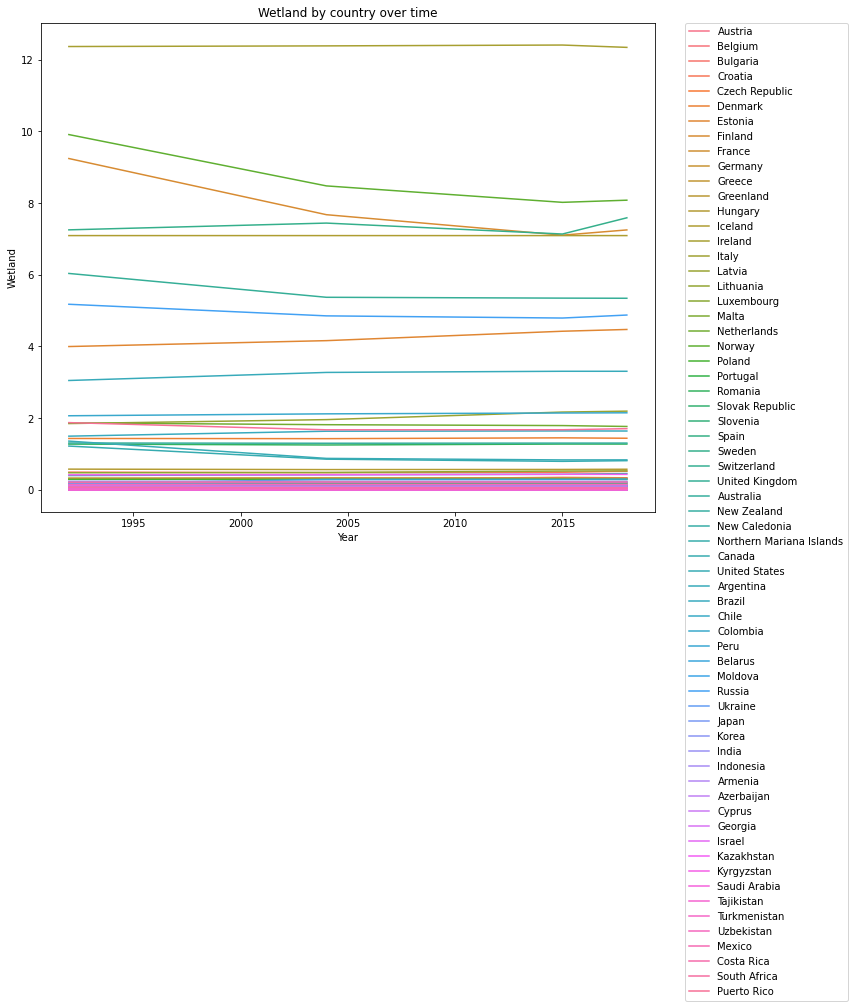

In [93]:
#plot the wetland over years by country
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Wetland by country over time')

sns.lineplot(
    data=land_cover_OECD.reset_index(),
    x='Year',
    y='Wetland',
    hue="Country")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Conclusions
For the artificial surfaces we can see a major change for our biggest timespan from 1992-2004 in some countries and for a few countries we can see a jump from 2004-2015. However for The shortest timespan from 2015-2018 we can hardly see any markable change across all variables. Excluding artificial surfaces, the data ist quite constant over the whole timespan, as we expected. Especially the ratio 2015/2018 suggests that one can use recent land cover data to approximate the data of the following years, as the properties don't significantly change over a short period of time. However a problem encountered is that for a few countries all entries of some values are 0 over all years. This can suggest that the data just isn't available for that country or that the % of given land cover is actually 0.

In [94]:
#extract our 2018 data
land_cover2018 =   land_cover_rel.iloc[land_cover_rel.index.get_level_values('Year') == 2018]
land_cover2018.shape

(236, 9)

In [95]:
#descriptive statistics
land_cover2018.describe()

Artificial surfaces   Bare area    Cropland   Grassland  Inland water  \
count           236.000000  236.000000  236.000000  236.000000    236.000000   
mean              3.274819   12.117159   27.178701    8.833833      5.794420   
std               9.807513   26.336930   22.388281   15.280070     13.562647   
min               0.000000    0.000000    0.000000    0.000000      0.000000   
25%               0.123466    0.000000    7.806774    0.096397      0.799938   
50%               0.569402    0.072513   23.364426    2.765517      1.674404   
75%               1.965186    4.094473   43.805507   10.689944      4.474193   
max             100.000000   99.871986   87.579618   88.624788    100.000000   

        Shrubland  Sparse vegetation  Tree cover     Wetland  
count  236.000000         236.000000  236.000000  236.000000  
mean     5.278640           3.060210   33.086850    1.375368  
std     10.848790           6.588589   28.104437    3.655866  
min      0.000000           0.000000    0.000000    0.000000  
25%      0.000000           0.008034    5.868930    0.001665  
50%      0.376116           0.139986   31.230774    0.118505  
75%      5.030730           3.081576   57.213742    0.700044  
max     76.679242          46.950629   97.392105   32.498908

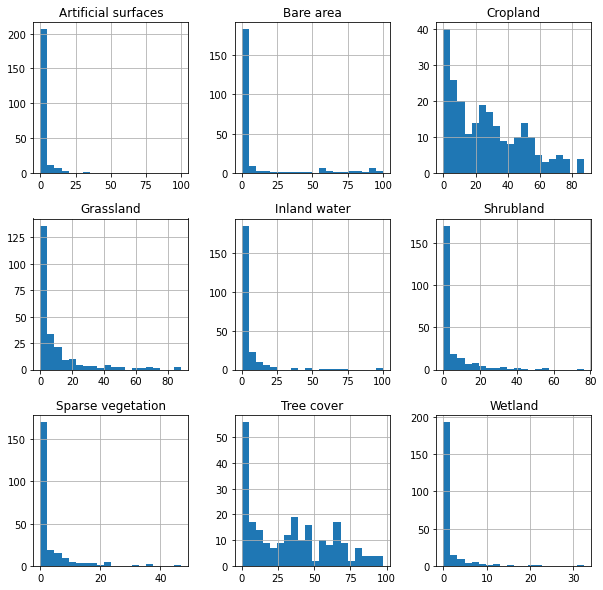

In [96]:
fig, axes = plt.subplots(len(land_cover2018.columns)//3, 3, figsize=(10, 10))

i = 0
for triaxis in axes:
    for axis in triaxis:
        land_cover2018.hist(column = land_cover2018.columns[i], bins = 20, ax=axis)
        i = i+1

In [97]:
land_cover2018.index = land_cover2018.index.droplevel('Year')
land_cover2018.head()

Artificial surfaces  Bare area   Cropland  Grassland  \
Country                                                                
Afghanistan                0.144171  39.153980  12.120421  37.161205   
Albania                    1.076736   1.682400  48.785857   5.348827   
Algeria                    0.123073  89.988986   4.599071   0.003802   
American Samoa             0.038506   0.000000  59.992299   0.000000   
Andorra                    0.877637   4.135021   1.012658  23.881857   

                Inland water  Shrubland  Sparse vegetation  Tree cover  \
Country                                                                  
Afghanistan         0.099181   3.545002           6.528826    1.236130   
Albania             2.259645   3.053523           1.328761   36.185951   
Algeria             0.064360   0.715815           3.637610    0.866315   
American Samoa      4.736234   0.000000           0.077012   35.155949   
Andorra             0.000000   0.033755          10.464135   59.594937   

                 Wetland  
Country                   
Afghanistan     0.011085  
Albania         0.278300  
Algeria         0.000967  
American Samoa  0.000000  
Andorra         0.000000

To test if the many 0 values are reasonable, we add a column that sums up all the percentages for each country and check if they rouhgly sum up to 1.

In [98]:
land_cover_sum = land_cover2018.copy()
land_cover_sum['Total'] = land_cover_sum.sum(axis=1)
land_cover_sum.head()

Artificial surfaces  Bare area   Cropland  Grassland  \
Country                                                                
Afghanistan                0.144171  39.153980  12.120421  37.161205   
Albania                    1.076736   1.682400  48.785857   5.348827   
Algeria                    0.123073  89.988986   4.599071   0.003802   
American Samoa             0.038506   0.000000  59.992299   0.000000   
Andorra                    0.877637   4.135021   1.012658  23.881857   

                Inland water  Shrubland  Sparse vegetation  Tree cover  \
Country                                                                  
Afghanistan         0.099181   3.545002           6.528826    1.236130   
Albania             2.259645   3.053523           1.328761   36.185951   
Algeria             0.064360   0.715815           3.637610    0.866315   
American Samoa      4.736234   0.000000           0.077012   35.155949   
Andorra             0.000000   0.033755          10.464135   59.594937   

                 Wetland  Total  
Country                          
Afghanistan     0.011085  100.0  
Albania         0.278300  100.0  
Algeria         0.000967  100.0  
American Samoa  0.000000  100.0  
Andorra         0.000000  100.0

In [99]:
land_cover_sum.describe()

Artificial surfaces   Bare area    Cropland   Grassland  Inland water  \
count           236.000000  236.000000  236.000000  236.000000    236.000000   
mean              3.274819   12.117159   27.178701    8.833833      5.794420   
std               9.807513   26.336930   22.388281   15.280070     13.562647   
min               0.000000    0.000000    0.000000    0.000000      0.000000   
25%               0.123466    0.000000    7.806774    0.096397      0.799938   
50%               0.569402    0.072513   23.364426    2.765517      1.674404   
75%               1.965186    4.094473   43.805507   10.689944      4.474193   
max             100.000000   99.871986   87.579618   88.624788    100.000000   

        Shrubland  Sparse vegetation  Tree cover     Wetland         Total  
count  236.000000         236.000000  236.000000  236.000000  2.360000e+02  
mean     5.278640           3.060210   33.086850    1.375368  1.000000e+02  
std     10.848790           6.588589   28.104437    3.655866  4.760214e-13  
min      0.000000           0.000000    0.000000    0.000000  1.000000e+02  
25%      0.000000           0.008034    5.868930    0.001665  1.000000e+02  
50%      0.376116           0.139986   31.230774    0.118505  1.000000e+02  
75%      5.030730           3.081576   57.213742    0.700044  1.000000e+02  
max     76.679242          46.950629   97.392105   32.498908  1.000000e+02

Our minimum and maximum value for the total column is 100, which means that the land coverage indeed sums up to 100%. But this is still no evidence that those types of land coverage are just not present in those cases. It could still be the case that this table is just derived from the absolute values and those have missing values.

This is why we inspect the absolute values in the next step and compare them to the total area of the countries and see if there are major differences

In [100]:
#for our analysis we use the relative data, to make it comparable across countries of different sizes
land_cover_abs = land_cover.copy()
land_cover_abs = land_cover_abs[land_cover_abs['MEAS'] == 'THOUSAND_SQKM']
land_cover_abs.shape

(8856, 21)

In [101]:
#getting the data in the same shape as our relative data
land_cover_abs = land_cover_abs[['Country', 'Year', 'Land cover class', 'Value']]
land_cover_abs = land_cover_abs.pivot_table(index=['Country','Year'],columns='Land cover class', values='Value')
land_cover_abs.columns.name = None
land_cover2018_abs =  land_cover_abs.iloc[land_cover_abs.index.get_level_values('Year') == 2018]
land_cover2018_abs.shape

(246, 9)

In [102]:
#sum up the land coverage
land_cover2018_abs_sum =  land_cover2018_abs.copy()
land_cover2018_abs_sum['Sum'] = land_cover2018_abs_sum.sum(axis=1)
land_cover2018_abs_sum.head()

Artificial surfaces    Bare area    Cropland   Grassland  \
Country        Year                                                             
Afghanistan    2018             0.927717   251.949704   77.993003  239.126511   
Albania        2018             0.310373     0.484957   14.062674    1.541816   
Algeria        2018             2.852011  2085.339874  106.575563    0.088104   
American Samoa 2018             0.000077     0.000000    0.120408    0.000000   
Andorra        2018             0.004019     0.018935    0.004637    0.109357   

                     Inland water  Shrubland  Sparse vegetation  Tree cover  \
Country        Year                                                           
Afghanistan    2018      0.638211  22.811532          42.011969    7.954301   
Albania        2018      0.651350   0.880187           0.383020   10.430712   
Algeria        2018      1.491427  16.587774          84.295359   20.075369   
American Samoa 2018      0.009506   0.000000           0.000155    0.070560   
Andorra        2018      0.000000   0.000155           0.047916    0.272890   

                      Wetland          Sum  
Country        Year                         
Afghanistan    2018  0.071333   643.484282  
Albania        2018  0.080221    28.825309  
Algeria        2018  0.022412  2317.327894  
American Samoa 2018  0.000000     0.200707  
Andorra        2018  0.000000     0.457908

In [103]:
#prepare for merging
land_cover_abs_mer = land_cover2018_abs_sum.copy()
land_cover_abs_mer = land_cover_abs_mer.reset_index()
land_cover_abs_mer = land_cover_abs_mer[['Country','Sum']]

In [104]:
#getting data for total country area and only keep the country name and the value for 2018 (and dividing them by 1000, 
#as this is the unit used for our data)
TOTAL_AREA = pd.read_csv(TOTAL_AREA)
total_area = TOTAL_AREA.copy()
total_area = total_area[['Country Name','2018']]
total_area = total_area.rename(columns={'Country Name': 'Country', '2018': 'Total'})
total_area['Total']=total_area['Total']/1000
total_area.head()

Country    Total
0        Aruba     0.18
1  Afghanistan   652.86
2       Angola  1246.70
3      Albania    28.75
4      Andorra     0.47

In [105]:
#merge country area data with land cover data, compute differences and show descriptive statistics (we reduce the inspected
#countries to the OECD countries again, as those are (almost all) relevant for our analysis and it gives a better overview)
area_merged = land_cover_abs_mer.merge(total_area, on='Country', how='inner')
area_merged['Difference'] = area_merged['Total']-area_merged['Sum']
#difference relative to the total area
area_merged['Relative_Difference'] = abs(area_merged['Difference'])/area_merged['Total']
area_merged_OECD = area_merged[area_merged['Country'].isin(OECD_COUNTRIES)]
area_merged_OECD.describe()

Sum        Total   Difference  Relative_Difference
count    62.000000    62.000000    62.000000            62.000000
mean   1038.169504  1027.662742   -10.506762             0.107145
std    2212.262495  2252.495884   240.247610             0.550100
min       0.314778     0.320000 -1742.914324             0.000160
25%      49.575097    49.547500    -0.455296             0.001853
50%     185.968682   174.490000     0.036203             0.004185
75%     628.771630   589.934248     0.610940             0.012500
max    9807.449189  9984.670000   435.199635             4.246350

We can see a huge outlier with our max value, where the total area is 4 times bigger than our OECD sum. This is the case for greendland, which is not present in our final data. We remove this entry and compute our stats again.

In [106]:
index = area_merged_OECD[area_merged_OECD['Country'] == 'Greenland'].index
area_merged_OECD.drop(index , inplace=True)
area_merged_OECD.describe()

Sum        Total  Difference  Relative_Difference
count    61.000000    61.000000   61.000000            61.000000
mean   1019.887622  1037.780984   17.893362             0.039289
std    2225.894497  2269.767989   88.545393             0.131991
min       0.314778     0.320000 -114.266445             0.000160
25%      48.978658    49.030000   -0.415003             0.001798
50%     164.954119   141.380000    0.051342             0.004162
75%     599.871684   603.550000    0.616755             0.012137
max    9807.449189  9984.670000  435.199635             0.904782

### Conclusion
The difference between the sum of land cover data and the total land area from the worldbank data has a mean of 3% (after removing our outlier) for our sample of countries. This leads to solid evidence for the assumption that those 0 values are natural and can be seen as valid features for our future model. The fact that there is a difference will most likely be based on different sources and different measurement criteria for the total area, as well as inaccuracies. 

Returning to our relevant data: As we have percentages for every value, we calculate the corresponding decimal value for the future work, which is also a benefit, because we then naturally have our values in a range from 0-1.

In [107]:
land_cover2018 = land_cover2018/100
land_cover2018

Artificial surfaces  Bare area  Cropland  Grassland  \
Country                                                                  
Afghanistan                   0.001442   0.391540  0.121204   0.371612   
Albania                       0.010767   0.016824  0.487859   0.053488   
Algeria                       0.001231   0.899890  0.045991   0.000038   
American Samoa                0.000385   0.000000  0.599923   0.000000   
Andorra                       0.008776   0.041350  0.010127   0.238819   
...                                ...        ...       ...        ...   
Wallis and Futuna             0.003272   0.000000  0.524537   0.000000   
Western Sahara                0.000089   0.998720  0.000267   0.000000   
Yemen                         0.000927   0.788603  0.047031   0.000966   
Zambia                        0.001160   0.000057  0.168463   0.015544   
Zimbabwe                      0.001771   0.002299  0.369198   0.037601   

                   Inland water  Shrubland  Sparse vegetation  Tree cover  \
Country                                                                     
Afghanistan            0.000992   0.035450           0.065288    0.012361   
Albania                0.022596   0.030535           0.013288    0.361860   
Algeria                0.000644   0.007158           0.036376    0.008663   
American Samoa         0.047362   0.000000           0.000770    0.351559   
Andorra                0.000000   0.000338           0.104641    0.595949   
...                         ...        ...                ...         ...   
Wallis and Futuna      0.227917   0.000000           0.000000    0.244275   
Western Sahara         0.000183   0.000000           0.000741    0.000000   
Yemen                  0.002263   0.034993           0.114995    0.010203   
Zambia                 0.018611   0.136371           0.000000    0.622014   
Zimbabwe               0.011432   0.270810           0.000460    0.305763   

                    Wetland  
Country                      
Afghanistan        0.000111  
Albania            0.002783  
Algeria            0.000010  
American Samoa     0.000000  
Andorra            0.000000  
...                     ...  
Wallis and Futuna  0.000000  
Western Sahara     0.000000  
Yemen              0.000019  
Zambia             0.037779  
Zimbabwe           0.000668  

[236 rows x 9 columns]

In [108]:
ds_land_cover = land_cover2018.reset_index(drop=False).copy()

## Protected Areas by management objective



### Problems

#### Why protected areas above 100%

Some countries have some protected areas recorded as points with a reported area. This point data is more uncertain than protected areas reported as polygons because overlaps cannot be identified or resolved. For this reason the total for countries is provided with and without the inclusion of the total reported area of protected areas recorded as points. The reported area of protected areas recorded as points can (individually or cumulatively) exceed the reference area used to calculate these indicators so coverages of greater than 100% can sometimes be reported.

#### Last update 

June 2020

#### Historical data

Not all protected areas have a designation date recorded. When there is no designation date the protected area is deemed to have always existed, therefore historical data maybe be overestimated.

### Load Data

#### Protected Area by management objective

Total for category is the total area protected under that IUCN management designation. Note that because overlaps among protected areas are relatively common, the total protected area for a country is typically less than the sum of the disaggregated areas.

Todo Markus
 - describe

In [159]:
# load data
def load_protected_area():
    PROTECTED_AREAS = DATA_PATH / 'OECD' / 'PROTECTED_AREAS_OBJECTIVE.csv'
    data = pd.read_csv(PROTECTED_AREAS)
    return data
protected_area_raw = load_protected_area()
protected_area_raw.shape

(71910, 23)

### Clean Protected Area data

(squer km make no sense by different sizes of countrys)

Todo Markus
- describe

In [162]:
# unique values per column
protected_area_raw.nunique()

COU                        127
Country                    127
DESIG                        9
Designation                  9
DOMAIN                       2
Domain                       2
MEASURE                      2
Measure                      2
CALCULATION                  1
Calculation method           1
SCOPE                        1
Scope                        1
YEA                         17
Year                        17
Unit Code                    2
Unit                         2
PowerCode Code               1
PowerCode                    1
Reference Period Code        0
Reference Period             0
Value                    10090
Flag Codes                   0
Flags                        0
dtype: int64

In [160]:
def clean_protected_area(raw_data):
    # filter only Terrestrial protected area
    data = raw_data[raw_data['Domain'] == 'Terrestrial']

    # filter only percentages 
    data = data[data['Unit'] == 'Percentage']

    # select subset of columns needed
    data = data[['Country', 'Year', 'Designation', 'Value']]

    return data
protected_area_cleaned = clean_protected_area(protected_area_raw)
protected_area_cleaned.shape

(18972, 4)

In [116]:
protected_area_cleaned.head()

Country  Year                Designation  Value
17  Australia  1970  Ia: Strict Nature Reserve   0.45
18  Australia  1980  Ia: Strict Nature Reserve   1.35
19  Australia  1990  Ia: Strict Nature Reserve   1.66
20  Australia  1995  Ia: Strict Nature Reserve   1.74
21  Australia  2000  Ia: Strict Nature Reserve   1.77

In [117]:
protected_area_cleaned.describe()

Year         Value
count  18972.000000  18972.000000
mean    2006.176471      4.924715
std       14.114342     39.171915
min     1970.000000      0.000000
25%     2000.000000      0.000000
50%     2012.000000      0.050000
75%     2016.000000      1.930000
max     2020.000000   1526.880000

## Feature preperation

Todo Markus
- describe

In [163]:
protected_area_cleaned['Designation'].unique()

array(['Ia: Strict Nature Reserve', 'Ib: Wilderness Area',
       'II: National Park', 'III: Natural Monument or Feature',
       'IV: Habitat or Species Management Area',
       'V: Protected Landscape or Seascape',
       'VI: Protected area with sustainable use of natural resources',
       'No IUCN category provided',
       'All, including data recorded as points'], dtype=object)

In [164]:
# check for missing values
protected_area_cleaned.isna().sum()

Country        0
Year           0
Designation    0
Value          0
dtype: int64

In [207]:
def transform_protected_area(cleaned_data, filter_year=None, filter_countries=None):

    # create DataFrame with all vealues per country and year
    data = cleaned_data.pivot_table(index=['Country', 'Year'], columns='Designation', values='Value')
    data.columns.name = None
    data = data.reset_index()

    # rename columns by management objective
    data = data.rename(columns={
        'Ia: Strict Nature Reserve': 'perc_area_protected_obj_1a',
        'Ib: Wilderness Area': 'perc_area_protected_obj_1b',
        'II: National Park': 'perc_area_protected_obj_2',
        'III: Natural Monument or Feature': 'perc_area_protected_obj_3',
        'IV: Habitat or Species Management Area': 'perc_area_protected_obj_4',
        'V: Protected Landscape or Seascape': 'perc_area_protected_obj_5',
        'VI: Protected area with sustainable use of natural resources': 'perc_area_protected_obj_6',
        'No IUCN category provided': 'perc_area_protected_no_obj',
        'All, including data recorded as points': 'perc_area_protected_all_obj'
    })

    if filter_year is not None:
        data = data[data['Year'] == filter_year]

    if filter_countries is not None:
       data = data[data['Country'].isin(filter_countries)]
    return data

# load all data for selected countries and all years
protected_area_all_years = transform_protected_area(
    protected_area_cleaned,
    filter_countries=SELECTED_COUNTRIES)
assert len(SELECTED_COUNTRIES) == protected_area_all_years['Country'].unique().shape[0]
protected_area_all_years.shape

(1105, 11)

In [209]:
protected_area_all_years.head()

Country  Year  perc_area_protected_all_obj  perc_area_protected_obj_2  \
68  Argentina  1970                         1.04                       0.66   
69  Argentina  1980                         2.49                       1.10   
70  Argentina  1990                         4.30                       1.22   
71  Argentina  1995                         5.21                       1.36   
72  Argentina  2000                         6.36                       1.52   

    perc_area_protected_obj_3  perc_area_protected_obj_4  \
68                       0.01                       0.00   
69                       0.01                       0.15   
70                       0.01                       0.15   
71                       0.03                       0.17   
72                       0.04                       0.18   

    perc_area_protected_obj_1a  perc_area_protected_obj_1b  \
68                        0.01                         0.0   
69                        0.01                         0.0   
70                        0.25                         0.0   
71                        0.26                         0.0   
72                        0.27                         0.0   

    perc_area_protected_no_obj  perc_area_protected_obj_5  \
68                        0.04                       0.00   
69                        0.04                       0.00   
70                        0.07                       0.00   
71                        0.08                       0.09   
72                        0.46                       0.30   

    perc_area_protected_obj_6  
68                       0.29  
69                       1.15  
70                       2.51  
71                       3.12  
72                       3.49

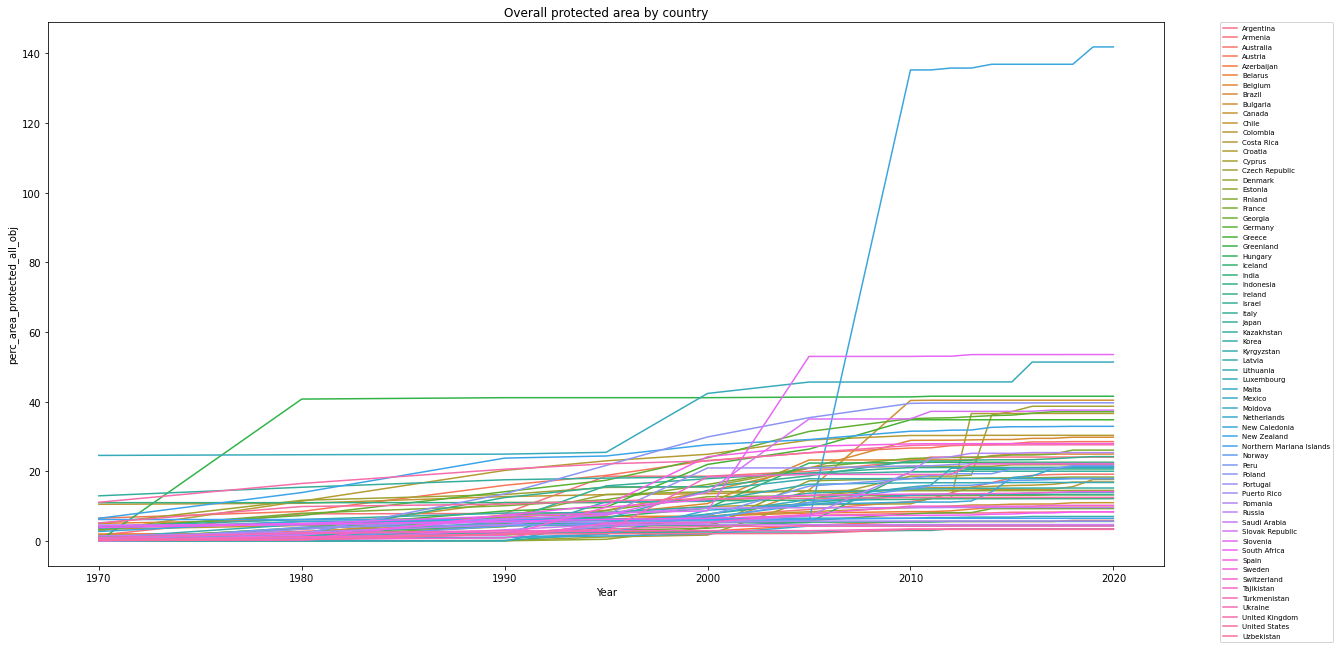

In [214]:
# plot changes over years in overall protected area
f, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Overall protected area by country')

sns.lineplot(
    data=protected_area_all_years,
    x='Year',
    y='perc_area_protected_all_obj',
    hue="Country")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=7)
plt.show()

Todo Markus
- describe what we see and why we can use values of 2020

In [215]:
# load all data for selected countries and all year 2020
ds_protected_areas = transform_protected_area(
    protected_area_cleaned,
    filter_year=2020,
    filter_countries=SELECTED_COUNTRIES)

# Dataset Merging
## General
### Constants

In [127]:
RANDOM_STATE = 42
PATH_IUCN = 'data/IUCN/scraped'

## IUCN Data
### Load and Concatenate

In [128]:
iucn_list = []
for _, _, files in os.walk(PATH_IUCN):
    for file in files:
        temp = pd.read_csv(PATH_IUCN + '/' + file)
        temp['Country'] = file.split('.csv')[0]
        iucn_list.append(temp)
iucn_data = pd.concat(iucn_list)

### Analysis
#### General Information

In [129]:
iucn_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136624 entries, 0 to 4731
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   kingdom_class    136624 non-null  object
 1   common_name      93221 non-null   object
 2   scientific_name  136624 non-null  object
 3   trend            133638 non-null  object
 4   region           136624 non-null  object
 5   threat_level     136624 non-null  object
 6   Country          136624 non-null  object
dtypes: object(7)
memory usage: 8.3+ MB


### Check Uniue Values

In [130]:
for c in iucn_data.columns:
    print('Column >>{}<< contains {} unique values.'.format(c, iucn_data[c].nunique()))

Column >>kingdom_class<< contains 32 unique values.
Column >>common_name<< contains 30138 unique values.
Column >>scientific_name<< contains 52327 unique values.
Column >>trend<< contains 4 unique values.
Column >>region<< contains 13 unique values.
Column >>threat_level<< contains 9 unique values.
Column >>Country<< contains 65 unique values.


### Explore Columns Containing NULL Values
#### trend

In [131]:
print('trend contains {} unique values, which are: {}.'.format(
    iucn_data['trend'].nunique(), iucn_data['trend'].unique()))

trend contains 4 unique values, which are: ['Stable' 'Decreasing' 'Unknown' 'Increasing' nan].


In [132]:
print('{} entries have missing values for the trend column.'.format(
    iucn_data['trend'].isna().sum()))

2986 entries have missing values for the trend column.


<AxesSubplot:>

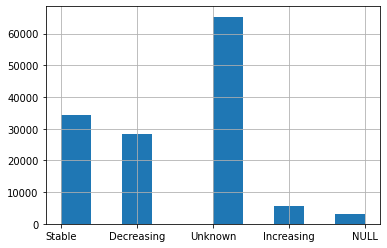

In [133]:
temp_iucn = iucn_data.copy()
temp_iucn.loc[temp_iucn['trend'].isna(), 'trend'] = 'NULL'
temp_iucn['trend'].hist()

In [134]:
print(
    'The dataset contains {} entries with available trend information (not Null or Unknown).'
    .format(
        len(iucn_data[(iucn_data['trend'].isna() == False)
                      & (iucn_data['trend'] != 'Unknown')])))

The dataset contains 68333 entries with available trend information (not Null or Unknown).


**NOTE: This is an issue and we have to think about a strategy how to deal with these missing/unknown values.**
Maybe we can check if these entries have some special characteristics.
## Country Characteristics Data
### Load and Merge

In [135]:
coun_list = []
country_sets = []

for ds in [ds_protected_areas, ds_land_cover, ds_climate, ds_ghg]:
    coun_list.append(ds)
    country_sets.append(set(ds['Country']))




In [136]:
intersect_countries = country_sets[0].intersection(
    country_sets[1], country_sets[2], country_sets[3])  ## add country_sets[3]
print(
    'The Country Characterisitcs Datasets contain {} intersecting countries, which are: {}'
    .format(len(intersect_countries), intersect_countries))

The Country Characterisitcs Datasets contain 42 intersecting countries, which are: {'Poland', 'Argentina', 'Czech Republic', 'Italy', 'Lithuania', 'Korea', 'Israel', 'Ireland', 'Sweden', 'Iceland', 'Brazil', 'Denmark', 'Germany', 'Portugal', 'Colombia', 'Slovenia', 'Switzerland', 'Slovak Republic', 'Australia', 'New Zealand', 'Chile', 'Netherlands', 'Russia', 'Latvia', 'Spain', 'Canada', 'Japan', 'Belgium', 'Estonia', 'Costa Rica', 'Austria', 'Indonesia', 'Luxembourg', 'Greece', 'Norway', 'Finland', 'India', 'Hungary', 'Mexico', 'United States', 'France', 'United Kingdom'}


--> Join Datasets on those countries.

In [137]:
coun_data = coun_list[0]
for coun in coun_list[1:]:
    coun_data = pd.merge(coun_data, coun, on='Country', how='inner')
coun_data.head()

Country  perc_area_protected_all_obj  perc_area_protected_obj_2  \
0  Argentina                         8.39                       1.84   
1  Australia                        19.20                       4.17   
2    Austria                        28.54                       2.38   
3    Belgium                        24.97                       0.07   
4     Brazil                        29.80                       4.13   

   perc_area_protected_obj_3  perc_area_protected_obj_4  \
0                       0.04                       0.19   
1                       0.24                       0.27   
2                       0.01                       5.80   
3                       0.00                       1.54   
4                       0.07                       0.03   

   perc_area_protected_obj_1a  perc_area_protected_obj_1b  \
0                        0.27                        0.03   
1                        2.01                        0.57   
2                        0.01                        0.12   
3                        0.00                        0.00   
4                        2.06                        0.00   

   perc_area_protected_no_obj  perc_area_protected_obj_5  \
0                        1.46                       0.33   
1                        0.34                       0.98   
2                        4.62                      15.35   
3                        9.19                      12.59   
4                       11.83                       4.58   

   perc_area_protected_obj_6  ...  temp_slope  gain_percentage  \
0                       4.09  ...    0.014949         0.500525   
1                      10.63  ...    0.017804         0.969423   
2                       0.20  ...    0.038525        24.241043   
3                       1.59  ...    0.028670        12.044550   
4                       6.78  ...    0.033281         3.703937   

   temp_difference       CH4        CO2       HFC       N2O       NF3  \
0         0.072246  1.828861   4.710241  0.014370  1.002114 -1.000000   
1         0.214683  4.382540  16.642911  0.479420  0.804808 -1.000000   
2         1.498389  0.728541   7.549433  0.207606  0.398982  0.001868   
3         1.167659  0.688260   8.787278  0.391962  0.500037  0.000057   
4         0.929317  1.683181   2.566549 -1.000000  0.894033 -1.000000   

        PFC       SF6  
0  0.003744  0.000042  
1  0.009443  0.009144  
2  0.003680  0.043241  
3  0.011516  0.008337  
4 -1.000000 -1.000000  

[5 rows x 29 columns]

### Analysis
#### General Information

In [138]:
coun_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 0 to 41
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Country                      42 non-null     object 
 1   perc_area_protected_all_obj  42 non-null     float64
 2   perc_area_protected_obj_2    42 non-null     float64
 3   perc_area_protected_obj_3    42 non-null     float64
 4   perc_area_protected_obj_4    42 non-null     float64
 5   perc_area_protected_obj_1a   42 non-null     float64
 6   perc_area_protected_obj_1b   42 non-null     float64
 7   perc_area_protected_no_obj   42 non-null     float64
 8   perc_area_protected_obj_5    42 non-null     float64
 9   perc_area_protected_obj_6    42 non-null     float64
 10  Artificial surfaces          42 non-null     float64
 11  Bare area                    42 non-null     float64
 12  Cropland                     42 non-null     float64
 13  Grassland             

There are no missing values in the dataset.

In [139]:
coun_data.describe()

perc_area_protected_all_obj  perc_area_protected_obj_2  \
count                    42.000000                  42.000000   
mean                     22.282857                   4.151667   
std                      10.766357                   5.984902   
min                       5.640000                   0.000000   
25%                      14.287500                   0.652500   
50%                      20.370000                   2.025000   
75%                      27.892500                   4.812500   
max                      53.530000                  32.610000   

       perc_area_protected_obj_3  perc_area_protected_obj_4  \
count                  42.000000                  42.000000   
mean                    0.362381                   2.964762   
std                     1.917474                   3.469978   
min                     0.000000                   0.010000   
25%                     0.000000                   0.440000   
50%                     0.020000                   1.555000   
75%                     0.070000                   3.877500   
max                    12.470000                  14.740000   

       perc_area_protected_obj_1a  perc_area_protected_obj_1b  \
count                   42.000000                   42.000000   
mean                     0.445714                    0.872619   
std                      0.676599                    1.827691   
min                      0.000000                    0.000000   
25%                      0.000000                    0.000000   
50%                      0.070000                    0.005000   
75%                      0.545000                    0.525000   
max                      2.180000                    7.530000   

       perc_area_protected_no_obj  perc_area_protected_obj_5  \
count                   42.000000                  42.000000   
mean                     6.900476                   4.782381   
std                      8.767212                   5.999103   
min                      0.000000                   0.000000   
25%                      0.472500                   0.110000   
50%                      3.375000                   1.430000   
75%                     11.290000                   7.780000   
max                     40.300000                  25.240000   

       perc_area_protected_obj_6  Artificial surfaces  ...  temp_slope  \
count                  42.000000            42.000000  ...   42.000000   
mean                    1.533333             0.026339  ...    0.032865   
std                     2.741055             0.027342  ...    0.013226   
min                     0.000000             0.000000  ...    0.006156   
25%                     0.000000             0.005924  ...    0.021700   
50%                     0.085000             0.015773  ...    0.034182   
75%                     1.552500             0.040661  ...    0.038667   
max                    10.630000             0.113337  ...    0.058883   

       gain_percentage  temp_difference        CH4        CO2        HFC  \
count        42.000000        42.000000  42.000000  42.000000  42.000000   
mean         10.864795         0.987359   1.284412   7.478007   0.164214   
std          12.305045         0.448411   1.194647   4.017188   0.297642   
min         -24.178355         0.072246   0.236113   1.278950  -1.000000   
25%           3.832235         0.659961   0.750174   4.848182   0.109285   
50%           9.547614         0.943211   0.893499   6.846338   0.176891   
75%          17.897105         1.382112   1.261372   9.078078   0.322812   
max          43.855657         1.852533   7.017958  16.642911   0.550778   

             N2O        NF3        PFC        SF6  
count  42.000000  42.000000  42.000000  42.000000  
mean    0.586226  -0.666490  -0.154093  -0.036179  
std     0.349903   0.477372   0.384327   0.219119  
min     0.092906  -1.000000  -1.000000  -1.000000  
25%     0.345235  -1.000000   0.000021   0.002429  
50%     0.481730  -1.00000

In [140]:
coun_data['Country'].nunique()

42

## Full Data
### Merge both datasets
#### Check Keys (countries)

In [141]:
iucn_countries = set(iucn_data['Country'].unique())
char_countries = set(coun_data['Country'].unique())
print('IUCN \ CHAR: {}'.format(iucn_countries.difference(char_countries)))
print('CHAR \ IUCN: {}'.format(char_countries.difference(iucn_countries)))

IUCN \ CHAR: {'Croatia', 'Turkmenistan', 'Ukraine', 'Puerto Rico', 'Bulgaria', 'Tajikistan', 'Greenland', 'Kyrgyzstan', 'New Caledonia', 'Uzbekistan', 'Romania', 'Moldova', 'Azerbaijan', 'Belarus', 'Peru', 'Malta', 'Georgia', 'South Africa', 'Saudi Arabia', 'Northern Mariana Islands', 'Cyprus', 'Kazakhstan', 'Armenia'}
CHAR \ IUCN: set()


In [142]:
oecd_list = [
    'AUSTRALIA', 'AUSTRIA', 'BELGIUM', 'CANADA', 'CHILE', 'COLOMBIA',
    'CZECH REPUBLIC', 'DENMARK', 'ESTONIA', 'FINLAND', 'FRANCE', 'GERMANY',
    'GREECE', 'HUNGARY', 'ICELAND', 'IRELAND', 'ISRAEL', 'ITALY', 'JAPAN',
    'KOREA', 'LATVIA', 'LITHUANIA', 'LUXEMBOURG', 'MEXICO', 'NETHERLANDS',
    'NEW ZEALAND', 'NORWAY', 'POLAND', 'PORTUGAL', 'SLOVAK REPUBLIC',
    'SLOVENIA', 'SPAIN', 'SWEDEN', 'SWITZERLAND', 'TURKEY', 'UNITED KINGDOM',
    'UNITED STATES'
]
oecd_list = [c.title() for c in oecd_list]
len(oecd_list)

37

In [143]:
set(oecd_list).difference(iucn_countries)

{'Turkey'}

In [144]:
set(oecd_list).difference(char_countries)

{'Turkey'}

In [145]:
iucn_diff_list = [c for c in iucn_countries.difference(char_countries)]
set(iucn_diff_list).intersection(set(oecd_list))

set()

#### Rename Country Data to Match IUCN Data

In [146]:
coun_data.loc[coun_data['Country'] == 'New Zealand', 'Country'] = 'New_Zealand'
coun_data.loc[coun_data['Country'] == 'Slovak Republic', 'Country'] = 'Slovakia'
coun_data.loc[coun_data['Country'] == 'United Kingdom', 'Country'] = 'United_Kingdom'
coun_data.loc[coun_data['Country'] == 'United States', 'Country'] = 'United_States'
coun_data.loc[coun_data['Country'] == 'Czech Republic', 'Country'] = 'Czechia'
coun_data.loc[coun_data['Country'] == 'Korea', 'Country'] = 'Korea,_Republic_of'

#### Merge 

In [147]:
full_data = iucn_data.merge(coun_data, on='Country', how='inner')
full_data['Country'].nunique()

36

In [148]:
full_data.columns.values

array(['kingdom_class', 'common_name', 'scientific_name', 'trend',
       'region', 'threat_level', 'Country', 'perc_area_protected_all_obj',
       'perc_area_protected_obj_2', 'perc_area_protected_obj_3',
       'perc_area_protected_obj_4', 'perc_area_protected_obj_1a',
       'perc_area_protected_obj_1b', 'perc_area_protected_no_obj',
       'perc_area_protected_obj_5', 'perc_area_protected_obj_6',
       'Artificial surfaces', 'Bare area', 'Cropland', 'Grassland',
       'Inland water', 'Shrubland', 'Sparse vegetation', 'Tree cover',
       'Wetland', 'temp_slope', 'gain_percentage', 'temp_difference',
       'CH4', 'CO2', 'HFC', 'N2O', 'NF3', 'PFC', 'SF6'], dtype=object)

#### Merge with the relative number of threatened species
For the prediction of the number of species per country relative to the number of total described species, we merge our coun_data with the relative number of threatened species per country. After those steps we have got 36 countries left, with 29 different characteristics for each one. We also have the relative number of threatened species by the taxonomic group for the major land living groups. Those are mammals, insects, amphibians, birds and reptiles. The maximum value for threatened species is 16.7%, while the minimum lies at 1.7% and there are on average 8.4% of the documented species threatened across all countries. The highest mean by taxonomic group can be seen for amphibians with 11.4% while the lowest can be seen for birds with  5.1%.

In [149]:
threatened_relative = ds_threatened_by_group.copy()
threatened_relative = threatened_relative.rename(columns={'Unnamed: 0': 'Country'})

In [150]:
threatened_countries = set(threatened_relative['Country'].unique())
print('THREAT \ CHAR: {}'.format(threatened_countries.difference(char_countries)))
print('CHAR \ THREAT: {}'.format(char_countries.difference(threatened_countries)))

KeyError: 'Country'

In [161]:
full_threatened = threatened_relative.merge(coun_data, on='Country', how='inner')
full_threatened.head()

Country  total_threatened  mammals_threatened  insects_threatened  \
0  Argentina            0.0791              0.1003              0.0744   
1  Australia            0.1120              0.1864              0.1403   
2    Austria            0.0628              0.0568              0.0867   
3    Belgium            0.0378              0.0417              0.0544   
4     Brazil            0.0861              0.1360              0.0807   

   reptiles_threatened  amphibians_threatened  birds_threatened  \
0               0.0771                 0.2061            0.0519   
1               0.0766                 0.2108            0.0716   
2               0.0769                 0.0000            0.0426   
3               0.0000                 0.0000            0.0303   
4               0.0766                 0.0430            0.0914   

   mammals_resident  insects_resident  reptiles_resident  ...  temp_slope  \
0              True              True               True  ...    0.014949   
1              True              True               True  ...    0.017804   
2              True              True               True  ...    0.038525   
3              True              True               True  ...    0.028670   
4              True              True               True  ...    0.033281   

   gain_percentage  temp_difference       CH4        CO2       HFC       N2O  \
0         0.500525         0.072246  1.828861   4.710241  0.014370  1.002114   
1         0.969423         0.214683  4.382540  16.642911  0.479420  0.804808   
2        24.241043         1.498389  0.728541   7.549433  0.207606  0.398982   
3        12.044550         1.167659  0.688260   8.787278  0.391962  0.500037   
4         3.703937         0.929317  1.683181   2.566549 -1.000000  0.894033   

        NF3       PFC       SF6  
0 -1.000000  0.003744  0.000042  
1 -1.000000  0.009443  0.009144  
2  0.001868  0.003680  0.043241  
3  0.000057  0.011516  0.008337  
4 -1.000000 -1.000000 -1.000000  

[5 rows x 40 columns]

In [162]:
#descriptive satistics for our final data frame
full_threatened.describe()

total_threatened  mammals_threatened  insects_threatened  \
count         36.000000           36.000000           36.000000   
mean           0.084056            0.101114            0.087264   
std            0.043261            0.070868            0.051773   
min            0.016700            0.000000            0.000000   
25%            0.047375            0.050100            0.060475   
50%            0.071400            0.089700            0.083700   
75%            0.121650            0.138025            0.100175   
max            0.166500            0.294000            0.234400   

       reptiles_threatened  amphibians_threatened  birds_threatened  \
count            36.000000              36.000000         36.000000   
mean              0.095097               0.114533          0.051697   
std               0.111864               0.156417          0.021114   
min               0.000000               0.000000          0.016000   
25%               0.000000               0.000000          0.037575   
50%               0.076750               0.032150          0.044300   
75%               0.153800               0.207275          0.062050   
max               0.500000               0.563000          0.111900   

       perc_area_protected_all_obj  perc_area_protected_obj_2  \
count                    36.000000                  36.000000   
mean                     21.890278                   4.285278   
std                      10.988145                   6.315960   
min                       5.640000                   0.000000   
25%                      14.135000                   0.642500   
50%                      19.625000                   2.025000   
75%                      26.577500                   4.935000   
max                      53.530000                  32.610000   

       perc_area_protected_obj_3  perc_area_protected_obj_4  ...  temp_slope  \
count                  36.000000                  36.000000  ...   36.000000   
mean                    0.058889                   2.898333  ...    0.032756   
std                     0.117492                   3.546239  ...    0.012915   
min                     0.000000                   0.010000  ...    0.006156   
25%                     0.000000                   0.397500  ...    0.022128   
50%                     0.015000                   1.555000  ...    0.034182   
75%                     0.050000                   3.712500  ...    0.038572   
max                     0.590000                  14.740000  ...    0.058883   

       gain_percentage  temp_difference        CH4        CO2        HFC  \
count        36.000000        36.000000  36.000000  36.000000  36.000000   
mean         10.010823         0.938828   1.156474   7.097104   0.144013   
std          12.942997         0.446922   0.820514   3.919144   0.313502   
min         -24.178355         0.072246   0.236113   1.278950  -1.000000   
25%           3.639039         0.603596   0.740512   4.616156   0.103406   
50%           8.858960         0.903967   0.893499   6.477036   0.158652   
75%          15.000800         1.220734   1.195826   8.839010   0.279662   
max          43.855657         1.852533   4.382540  16.642911   0.550778   

             N2O        NF3           PFC        SF6  
count  36.000000  36.000000  3.600000e+01  36.000000  
mean    0.561717  -0.694300 -1.818770e-01  -0.046840  
std     0.306269   0.467397  4.091898e-01   0.234670  
min     0.092906  -1.000000 -1.000000e+00  -1.000000  
25%     0.357740  -1.000000  9.067425e-07   0.002302  
50%     0.481730  -1.000000  3.587118e-03   0.007283  
75%     0.819767   0.000005  1.057792e-02   0.010420  
max     1.431682   0.002234  2.167259e-01   0.046683  

[8 rows x 34 columns]

## Trends
### Preprocessing
#### Transform Trends to [-1, 1]

In [163]:
full_data = full_data.dropna()
full_data = full_data[full_data['trend'] != 'Unknown']
full_data.loc[full_data['trend'] == 'Decreasing', 'trend_num'] = -1
full_data.loc[full_data['trend'] == 'Stable', 'trend_num'] = 0
full_data.loc[full_data['trend'] == 'Increasing', 'trend_num'] = 1
full_data.head()

kingdom_class                      common_name  \
1  animalia — mammalia                 Monito del Monte   
4  animalia — mammalia  Southern Three-banded Armadillo   
6  animalia — mammalia         Molina's Hog-nosed Skunk   
7  animalia — mammalia          South American Fur Seal   
9  animalia — mammalia                     Gray Brocket   

           scientific_name       trend  region     threat_level    Country  \
1     Dromiciops gliroides  Decreasing  Global  Near Threatened  Argentina   
4       Tolypeutes matacus  Decreasing  Global  Near Threatened  Argentina   
6         Conepatus chinga  Decreasing  Global    Least Concern  Argentina   
7  Arctocephalus australis  Increasing  Global    Least Concern  Argentina   
9       Mazama gouazoubira  Decreasing  Global    Least Concern  Argentina   

   perc_area_protected_all_obj  perc_area_protected_obj_2  \
1                         8.39                       1.84   
4                         8.39                       1.84   
6                         8.39                       1.84   
7                         8.39                       1.84   
9                         8.39                       1.84   

   perc_area_protected_obj_3  ...  gain_percentage  temp_difference       CH4  \
1                       0.04  ...         0.500525         0.072246  1.828861   
4                       0.04  ...         0.500525         0.072246  1.828861   
6                       0.04  ...         0.500525         0.072246  1.828861   
7                       0.04  ...         0.500525         0.072246  1.828861   
9                       0.04  ...         0.500525         0.072246  1.828861   

        CO2      HFC       N2O  NF3       PFC       SF6  trend_num  
1  4.710241  0.01437  1.002114 -1.0  0.003744  0.000042       -1.0  
4  4.710241  0.01437  1.002114 -1.0  0.003744  0.000042       -1.0  
6  4.710241  0.01437  1.002114 -1.0  0.003744  0.000042       -1.0  
7  4.710241  0.01437  1.002114 -1.0  0.003744  0.000042        1.0  
9  4.710241  0.01437  1.002114 -1.0  0.003744  0.000042       -1.0  

[5 rows x 36 columns]

In [164]:
def z_score_normalize(full_data):
    num_cols = []
    for col in full_data.columns.values:
        if full_data[col].dtype == float:
            num_cols.append(col)
    df_zscore = pd.DataFrame(zscore(full_data[num_cols], axis=1) , columns=num_cols)
    return df_zscore

### Analysis

<AxesSubplot:>

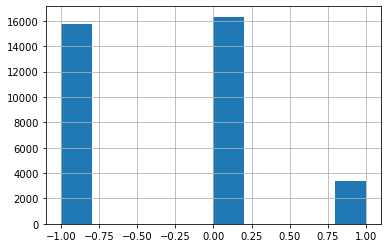

In [165]:
full_data['trend_num'].hist()

### Correlations
#### Logistic Regression on Trend per Feature

See: https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365#:~:text=A%20simple%20approach%20could%20be,variance%20of%20the%20continuous%20variable.&text=If%20the%20variables%20have%20no,similar%20to%20the%20original%20variance.

In [166]:
full_data = full_data.dropna()
full_data = full_data[full_data['trend'] != 'Unknown']

In [167]:
clf = LogisticRegression(random_state=RANDOM_STATE)
runs = []
for col in full_data.columns.values:
    if (full_data[col].dtype == 'int64') | (full_data[col].dtype == 'float64'):
        y = full_data['trend'].copy()
        #y[y.isna()] = 'NULL'
        X = full_data[col]
        X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33, stratify=y,
                                                    random_state=RANDOM_STATE, shuffle=True)
        X_train = np.array(X_train).reshape(-1,1)
        X_test =  np.array(X_test).reshape(-1,1)
        y_train = np.array(y_train)
        y_test = np.array(y_test)
        clf.fit(X_train, y_train)
        
        y_hat = clf.predict(X_test)
        acc = clf.score(X_test, y_test)
        
        entry = {'column': col, 'acc': acc, 'y': y_test, 'y_hat':y_hat}
        runs.append(entry)
        print('{} predictor accuracy: {}'.format(col, acc))
    # acc_per_col[col] = 

perc_area_protected_all_obj predictor accuracy: 0.4610639938319198
perc_area_protected_obj_2 predictor accuracy: 0.46140666495331106
perc_area_protected_obj_3 predictor accuracy: 0.46140666495331106
perc_area_protected_obj_4 predictor accuracy: 0.46140666495331106
perc_area_protected_obj_1a predictor accuracy: 0.46140666495331106
perc_area_protected_obj_1b predictor accuracy: 0.46140666495331106
perc_area_protected_no_obj predictor accuracy: 0.46346269168165855
perc_area_protected_obj_5 predictor accuracy: 0.4610639938319198
perc_area_protected_obj_6 predictor accuracy: 0.46140666495331106
Artificial surfaces predictor accuracy: 0.46140666495331106
Bare area predictor accuracy: 0.46140666495331106
Cropland predictor accuracy: 0.46354835946200634
Grassland predictor accuracy: 0.46140666495331106
Inland water predictor accuracy: 0.4398183843056626
Shrubland predictor accuracy: 0.46140666495331106
Sparse vegetation predictor accuracy: 0.47948256660669925
Tree cover predictor accuracy: 0.4

In [168]:
run_df = pd.DataFrame(runs) 
run_df.describe()

acc
count  29.000000
mean    0.482197
std     0.099845
min     0.439818
25%     0.461407
50%     0.461407
75%     0.468517
max     1.000000

#### Pearson Correlation


In [169]:
df_zscore = full_data.copy()
df_zscore['trend'] = full_data['trend']
df_zscore = z_score_normalize(df_zscore)
df_zscore.describe()


perc_area_protected_all_obj  perc_area_protected_obj_2  \
count                 35372.000000               35372.000000   
mean                      3.863935                   0.633454   
std                       0.798804                   1.017456   
min                       1.252741                  -0.478143   
25%                       3.684214                  -0.231736   
50%                       4.068604                   0.321042   
75%                       4.251886                   0.949740   
max                       4.828268                   2.826411   

       perc_area_protected_obj_3  perc_area_protected_obj_4  \
count               35372.000000               35372.000000   
mean                   -0.374514                   0.107266   
std                     0.082955                   0.652998   
min                    -0.493378                  -0.441130   
25%                    -0.422314                  -0.359443   
50%                    -0.393188                  -0.177959   
75%                    -0.354844                   0.357329   
max                    -0.078908                   2.092226   

       perc_area_protected_obj_1a  perc_area_protected_obj_1b  \
count                35372.000000                35372.000000   
mean                    -0.185459                   -0.303767   
std                      0.243561                    0.261845   
min                     -0.470334                   -0.496206   
25%                     -0.412375                   -0.421641   
50%                     -0.292885                   -0.382166   
75%                     -0.026156                   -0.342761   
max                      0.310026                    0.982270   

       perc_area_protected_no_obj  perc_area_protected_obj_5  \
count                35372.000000               35372.000000   
mean                     0.671807                   0.116631   
std                      0.999563                   0.765688   
min                     -0.469061                  -0.455669   
25%                     -0.083193                  -0.347876   
50%                      0.430748                  -0.260948   
75%                      1.627800                   0.392878   
max                      3.137823                   2.611471   

       perc_area_protected_obj_6  Artificial surfaces  ...  gain_percentage  \
count               35372.000000         35372.000000  ...     35372.000000   
mean                    0.330186            -0.385954  ...         0.759531   
std                     0.918041             0.079169  ...         1.721058   
min                    -0.474387            -0.492827  ...        -4.442765   
25%                    -0.401838            -0.430417  ...         0.248497   
50%                    -0.108998            -0.401872  ...         0.693937   
75%                     0.772253            -0.370646  ...         1.437444   
max                     2.521298            -0.094510  ...         4.929403   

       temp_difference           CH4           CO2           HFC  \
count     35372.000000  35372.000000  35372.000000  35372.000000   
mean         -0.179810     -0.079088      0.940382     -0.402970   
std           0.161897      0.261928      0.868702      0.149058   
min          -0.442305     -0.413320     -0.072342     -0.790252   
25%          -0.271937     -0.264322      0.456814     -0.427334   
50%          -0.223933     -0.114572      0.642612     -0.384616   
75%          -0.135230     -0.064728      1.133527     -0.349535   
max           0.247022      0.536868      3.014852     -0.035701   

                N2O           NF3           PFC           SF6     trend_num  
count  35372.000000  35372.000000  35372.000000  35372.000000  35372.000000  
mean      -0.265257     -0.612335     -0.471458     -0.434839     -0.489210  
std        0.126010      0.225011      0.148411      0.135863      0.214330  
min       -0.431720     -1.232174     -0.790252     -

##### Plot Correlation Matrix

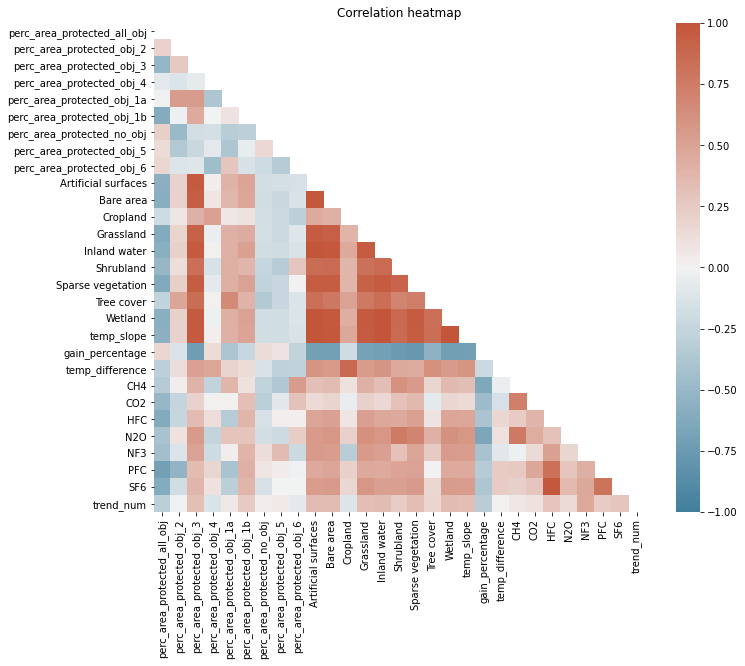

In [170]:
correlation_matrix =  df_zscore.corr(method= 'pearson')
#visualization of the correlation matrix as heatmap

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Correlation heatmap')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# create heatmap
sns.heatmap(correlation_matrix, mask=mask,  cmap=cmap, vmin=-1, vmax=1, center=0)
plt.show()

# Models
## Trend
### Group Data by Country and Kingdom. Mean aggregate

<AxesSubplot:>

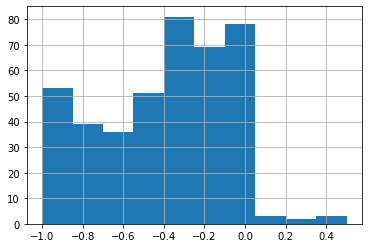

In [171]:
by_country_kingdom = full_data.groupby(['kingdom_class', 'Country']).mean()
by_country_kingdom = by_country_kingdom.reset_index(drop=False)
by_country_kingdom['trend_num'].hist()


#### Generate Country Labels (Integers) for LeaveGroupOutCV

In [172]:
country_encoder = LabelEncoder()
country_encoder.fit(by_country_kingdom['Country'])
country_labels = country_encoder.transform(by_country_kingdom['Country'])

#### One Hot Encode kingdom_class and Country

In [173]:
by_country_kingdom['kingdom_class'].unique()


array(['animalia — actinopterygii', 'animalia — amphibia',
       'animalia — anthozoa', 'animalia — arachnida',
       'animalia — asteroidea', 'animalia — aves', 'animalia — bivalvia',
       'animalia — cephalaspidomorphi', 'animalia — cephalopoda',
       'animalia — chondrichthyes', 'animalia — clitellata',
       'animalia — gastropoda', 'animalia — holothuroidea',
       'animalia — insecta', 'animalia — malacostraca',
       'animalia — mammalia', 'animalia — merostomata',
       'animalia — myxini', 'animalia — reptilia',
       'animalia — sarcopterygii'], dtype=object)

In [174]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(by_country_kingdom[['kingdom_class', 'Country']])
oht_features = enc.transform(by_country_kingdom[['kingdom_class', 'Country']])
col_names = [
    *by_country_kingdom['kingdom_class'].unique(),
    *by_country_kingdom['Country'].unique()
]
oht_features = pd.DataFrame(oht_features.todense(), columns=col_names)

In [175]:
y = by_country_kingdom['trend_num']
X = by_country_kingdom.drop(['kingdom_class', 'Country', 'trend_num'], axis=1)
X = pd.concat([X, oht_features], axis=1)
X.describe()

perc_area_protected_all_obj  perc_area_protected_obj_2  \
count                   415.000000                 415.000000   
mean                     21.535687                   3.870361   
std                      10.567392                   5.498231   
min                       5.640000                   0.000000   
25%                      13.940000                   0.650000   
50%                      19.200000                   2.020000   
75%                      26.110000                   4.870000   
max                      53.530000                  32.610000   

       perc_area_protected_obj_3  perc_area_protected_obj_4  \
count                 415.000000                 415.000000   
mean                    0.062964                   2.804217   
std                     0.119381                   3.408525   
min                     0.000000                   0.010000   
25%                     0.000000                   0.360000   
50%                     0.020000                   1.540000   
75%                     0.050000                   3.630000   
max                     0.590000                  14.740000   

       perc_area_protected_obj_1a  perc_area_protected_obj_1b  \
count                  415.000000                  415.000000   
mean                     0.491759                    0.807422   
std                      0.717463                    1.811209   
min                      0.000000                    0.000000   
25%                      0.000000                    0.000000   
50%                      0.070000                    0.000000   
75%                      0.570000                    0.365000   
max                      2.180000                    7.530000   

       perc_area_protected_no_obj  perc_area_protected_obj_5  \
count                  415.000000                 415.000000   
mean                     7.314602                   4.065880   
std                      8.942059                   5.690775   
min                      0.000000                   0.000000   
25%                      0.510000                   0.040000   
50%                      3.470000                   0.980000   
75%                     11.380000                   7.210000   
max                     40.300000                  25.240000   

       perc_area_protected_obj_6  Artificial surfaces  ...      Mexico  \
count                 415.000000           415.000000  ...  415.000000   
mean                    1.820892             0.024846  ...    0.036145   
std                     3.062601             0.028060  ...    0.186875   
min                     0.000000             0.000000  ...    0.000000   
25%                     0.000000             0.003982  ...    0.000000   
50%                     0.140000             0.011949  ...    0.000000   
75%                     2.480000             0.040459  ...    0.000000   
max                    10.630000             0.113337  ...    1.000000   

       Netherlands      Norway      Poland    Portugal      Russia  \
count   415.000000  415.000000  415.000000  415.000000  415.000000   
mean      0.026506    0.026506    0.026506    0.028916    0.031325   
std       0.160828    0.160828    0.160828    0.167772    0.174406   
min       0.000000    0.000000    0.000000    0.000000    0.000000   
25%       0.000000    0.000000    0.000000    0.000000    0.000000   
50%       0.000000    0.000000    0.000000    0.000000    0.000000   
75%       0.000000    0.000000    0.000000    0.000000    0.000000   
max       1.000000    1.000000    1.000000    1.000000    1.000000   

         Slovenia       Spain      Sweden  Switzerland  
count  415.000000  415.000000  415.000000   415.000000  
mean     0.028916    0.031325    0.026506     0.024096  
std      0.167772    0.174406    0.160828     0.153534  
min      0.000000    0.000000    0.000000     0.000000  
25%      0.000000    0.000000    0.000000     0.000000  
50%      0.000000    0.000000    0.000000     0.00

#### Train Models

In [176]:
# create pipeline for Model
def train_model(X, y, model='svr'):
    if model == 'svr':
        instance = SVR()
        params = {
        'svr__C': [0.1, 0.4, 1, 5, 10], # todo: inform on parameter ranges
        'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }
    elif model == 'knn':
        instance = KNeighborsRegressor()
        params = {
            'knn__n_neighbors': [1, 2, 3 , 4 , 5],
            'knn__weights': ['uniform', 'distance']
    }
    elif model == 'rf':
        instance = RandomForestRegressor(max_features = 'sqrt', random_state=RANDOM_STATE)
        params = {
        'rf__n_estimators': [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
    }
    
    
        
    pipeline = Pipeline([
         ('scaling', StandardScaler()), (model, instance)
    ])

    logo = LeavePGroupsOut(n_groups=2)

    grid_search = GridSearchCV(pipeline,
                                    cv=logo,
                                   
                                    param_grid=params,
                                    scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],
                                    refit='neg_root_mean_squared_error', verbose=2, n_jobs=-1)
    
    grid_search.fit(X, y, groups=country_labels)

    return pd.DataFrame(grid_search.cv_results_)


##### Support Vector Machine

In [177]:
svr_results = train_model(X, y, model='svr')

Fitting 630 folds for each of 20 candidates, totalling 12600 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 920 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 2052 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 5292 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 7400 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 8309 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 10885 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 12561 out of 12600 | elapsed:  1.6min remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 12600 out of 12600 | elapsed:  1.6min finished


##### K-NN

In [178]:
knn_results = train_model(X, y, model='knn')

Fitting 630 folds for each of 10 candidates, totalling 6300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1920 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 4184 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 6300 out of 6300 | elapsed:    6.9s finished


##### Random Forest

In [179]:
rf_results = train_model(X, y, model='rf')

Fitting 630 folds for each of 10 candidates, totalling 6300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 610 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1176 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 1906 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 2945 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3552 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 4241 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 5010 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 5861 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 6300 out of 6300 | elapsed:  4.1min finished


#### Show best scores and params

In [180]:
def extract_from_cv_results(cv_results, row_name=None):
    cv_results = pd.DataFrame(cv_results)
    best_scores = {}
    best_params = {}

    scores = [col.replace('mean_test_', '') for col in cv_results.columns if col.startswith('mean_test_')]
    params = [col for col in cv_results.columns if col.startswith('param_')]

    for score in scores:
        best_params[score] = {}
        # rank is 1 for multiple models if score is equal
        best_model_by_score = cv_results[cv_results[f'rank_test_{score}'] == 1].iloc[0]
        best_scores[f'mean_{score}'] = best_model_by_score[f'mean_test_{score}']
        best_scores[f'std_{score}'] = best_model_by_score[f'std_test_{score}']
        for param in params:
            p = param.split('__')[-1]
            best_params[score][p] = best_model_by_score[param]
    
    best_params = pd.DataFrame(best_params)
    if row_name is None:
        best_scores = pd.DataFrame(best_scores, index=['value'])
    else:
        best_scores = pd.DataFrame(best_scores, index=[row_name])
        best_params['target'] = row_name
        best_params = best_params.reset_index().set_index(['target', 'index'])
    return best_scores, best_params

##### Support Vector Machine

In [181]:
svr_best_scores, svr_best_params = extract_from_cv_results(svr_results)
display(svr_best_scores)
display(svr_best_params)

mean_neg_root_mean_squared_error  std_neg_root_mean_squared_error  \
value                         -0.249259                         0.056478   

       mean_neg_mean_absolute_error  std_neg_mean_absolute_error  
value                     -0.181656                     0.042763

neg_root_mean_squared_error neg_mean_absolute_error
C                               10                       1
kernel                      linear                  linear

##### K-NN

In [182]:
knn_best_scores, knn_best_params = extract_from_cv_results(knn_results)
display(knn_best_scores)
display(knn_best_params)

mean_neg_root_mean_squared_error  std_neg_root_mean_squared_error  \
value                         -0.241589                         0.058988   

       mean_neg_mean_absolute_error  std_neg_mean_absolute_error  
value                     -0.167614                     0.062488

neg_root_mean_squared_error neg_mean_absolute_error
n_neighbors                           3                       1
weights                        distance                 uniform

##### Random Forest

In [183]:
rf_best_scores, rf_best_params = extract_from_cv_results(rf_results)
display(rf_best_scores)
display(rf_best_params)

mean_neg_root_mean_squared_error  std_neg_root_mean_squared_error  \
value                         -0.247405                         0.050709   

       mean_neg_mean_absolute_error  std_neg_mean_absolute_error  
value                     -0.189801                     0.041119

neg_root_mean_squared_error  neg_mean_absolute_error
n_estimators                          450                      500

#### Comparision of classifiers

In [184]:
def boxplot_results(cv_result_list):
    score = 'neg_root_mean_squared_error'
    fig, axs = plt.subplots(3, figsize=(10, 5))
    fig.suptitle('RMSE Scores Leave2GroupsOut CV (group=Country)')
    max_x = 0
    for i, cv_res in enumerate(cv_result_list):
        results = cv_res
        best_results = results[results[f'rank_test_{score}'] == 1].iloc[0]
        cv_scores = [best_results[f'split{i}_test_{score}'] for i in range(by_country_kingdom['Country'].nunique())]
        cv_scores = [-val for val in cv_scores]
        temp_max = np.max(cv_scores)
        if temp_max > max_x:
            max_x = temp_max
        sns.boxplot(data=cv_scores, orient='h', ax=axs[i])
    axs[0].set_title('Support Vector Machine')
    axs[1].set_title('K-NN')
    axs[2].set_title('Random Forest')
    
    axs[0].set_xlim([0.05,max_x + 0.05])
    axs[1].set_xlim([0.05,max_x + 0.05])
    axs[2].set_xlim([0.05,max_x + 0.05])
    
    
    
    plt.tight_layout()
    plt.show()

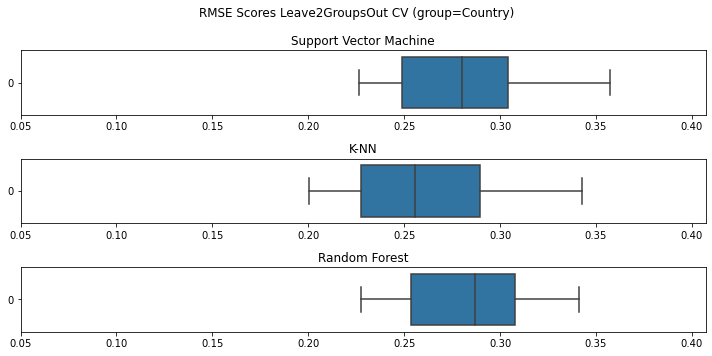

In [185]:
boxplot_results([svr_results, knn_results, rf_results])

## Relative Threatened Species
### Check correlation of our features and target values for the relative threatened species by country and group 
For our correlation analysis, we exclude our non continuous variables (the binary value whether a taxonomic group has records for that specific country)

In [186]:
full_threatened_corr = full_threatened.copy()
full_threatened_corr = full_threatened.drop(columns=['mammals_resident', 'insects_resident', "amphibians_resident", "birds_resident", "reptiles_resident"])

In [187]:
#full correlation matrix to also get an overview of correlations between different features
full_threatened_corr.corr(method= 'pearson')

perc_area_protected_obj_4             -0.033785             0.013010   
perc_area_protected_obj_1a             0.048049            -0.170222   
perc_area_protected_obj_1b            -0.204087            -0.226246   
perc_area_protected_no_obj             0.220617             0.113133   
perc_area_protected_obj_5              0.116599            -0.125528   
perc_area_protected_obj_6              0.118447            -0.063772   
Artificial surfaces                    0.038503            -0.122641   
Bare area                             -0.151139             0.123024   
Cropland                               0.254121            -0.094644   
Grassland                             -0.351841             0.261549   
Inland water                          -0.236959            -0.168664   
Shrubland                              0.226350             0.151074   
Sparse vegetation                     -0.106568            -0.056311   
Tree cover                             0.076214            -0.148923   
Wetland                               -0.421772             0.119531   
temp_slope                             0.033120            -0.348568   
gain_percentage                       -0.090725            -0.383717   
temp_difference                        0.214659            -0.062601   
CH4                                   -0.085329             0.199637   
CO2                                   -0.142365            -0.071803   
HFC                                    0.166304             0.138146   
N2O                                   -0.392401             0.008032   
NF3                                    0.053978             0.216389   
PFC                                    0.206650             0.228273   
SF6                                    0.040041             0.040442   

                             amphibians_threatened  birds_threatened  \
total_threatened                          0.780868          0.688018   
mammals_threatened                        0.483242          0.783615   
insects_threatened                        0.314565          0.192471   
reptiles_threatened                       0.420404          0.420726   
amphibians_threatened                     1.000000          0.456921   
birds_threatened                          0.456921          1.000000   
perc_area_protected_all_obj              -0.138516         -0.353233   
perc_area_protected_obj_2                 0.085890         -0.067479   
perc_area_protected_obj_3                 0.069787          0.102690   
perc_area_protected_obj_4                -0.055111         -0.187105   
perc_area_protected_obj_1a                0.056411          0.421984   
perc_area_protected_obj_1b               -0.249485         -0.162613   
perc_area_protected_no_obj               -0.133317         -0.251556   
perc_area_protected_obj_5                -0.255866         -0.173002   
perc_area_protected_obj_6                 0.352722          0.176887   
Artificial surfaces                      -0.189753         -0.288874   
Bare area                                 0.138933          0.061288   
Cropland                                 -0.110511         -0.174032   
Grassland                                -0.268581         -0.258580   
Inland water                             -0.280541         -0.127803   
Shrubland                                 0.582266          0.308445   
Sparse vegetation                         0.047150          0.193678   
Tree cover                                0.032722          0.135339   
Wetland                                  -0.354566         -0.063319   
temp_slope                               -0.471431         -0.270901   
gain_percentage                          -0.234124         -0.331767   
temp_difference                          -0.151020         -0.220272   
CH4                                      -0.104334          0.142518   
CO2                                      -0.345070         -0.195325   
HFC                                    

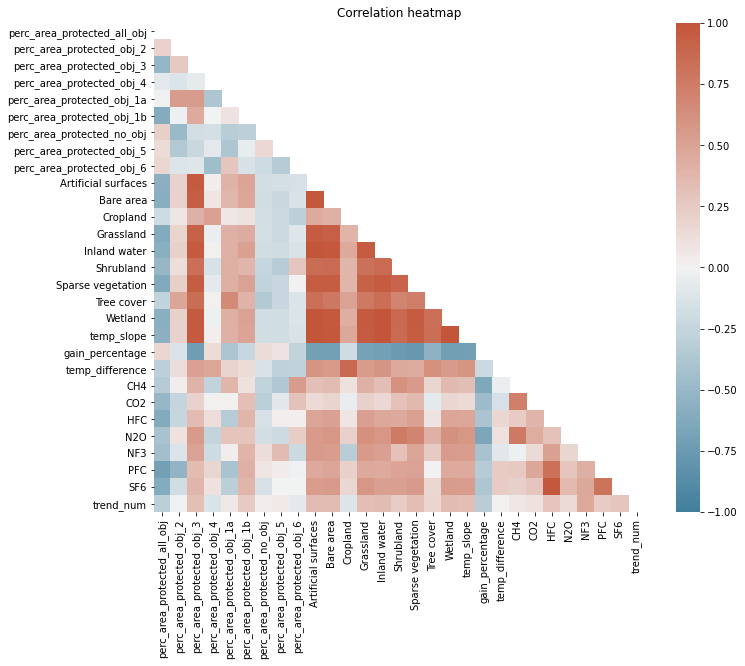

In [188]:
#visualization of the correlation matrix as heatmap

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Correlation heatmap')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# create heatmap
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0)
plt.show()

To get a better overview of our targets we calculate the correlation of the features with each target separately

In [189]:
#pearsons rho for the correlation of the values for all groups with our features
for col in full_threatened_corr:
    target = 'total_threatened'
    exclude =  ['Country','total_threatened', 'mammals_threatened', 'insects_threatened', 'amphibians_threatened','birds_threatened', 'reptiles_threatened']
    correlations = {}
    if col not in exclude:
        correlations[col + ' pearsons correlation with ' + target] = round(full_threatened_corr[col].corr(full_threatened_corr[target]),5)
        print(correlations)

{'perc_area_protected_all_obj pearsons correlation with total_threatened': -0.1907}
{'perc_area_protected_obj_2 pearsons correlation with total_threatened': -0.08343}
{'perc_area_protected_obj_3 pearsons correlation with total_threatened': 0.15863}
{'perc_area_protected_obj_4 pearsons correlation with total_threatened': -0.13393}
{'perc_area_protected_obj_1a pearsons correlation with total_threatened': 0.15326}
{'perc_area_protected_obj_1b pearsons correlation with total_threatened': -0.30394}
{'perc_area_protected_no_obj pearsons correlation with total_threatened': -0.04981}
{'perc_area_protected_obj_5 pearsons correlation with total_threatened': -0.14856}
{'perc_area_protected_obj_6 pearsons correlation with total_threatened': 0.22206}
{'Artificial surfaces pearsons correlation with total_threatened': -0.20413}
{'Bare area pearsons correlation with total_threatened': 0.0886}
{'Cropland pearsons correlation with total_threatened': -0.00962}
{'Grassland pearsons correlation with total_

In [190]:
#pearsons rho for the correlation of the threatened mammals with our features
for col in full_threatened_corr:
    target = 'mammals_threatened'
    exclude =  ['Country','total_threatened', 'mammals_threatened', 'insects_threatened', 'amphibians_threatened','birds_threatened', 'reptiles_threatened']
    correlations = {}
    if col not in exclude:
        correlations[col + ' pearsons correlation with ' + target] = round(full_threatened_corr[col].corr(full_threatened_corr[target]),5)
        print(correlations)

{'perc_area_protected_all_obj pearsons correlation with mammals_threatened': -0.24262}
{'perc_area_protected_obj_2 pearsons correlation with mammals_threatened': -0.00879}
{'perc_area_protected_obj_3 pearsons correlation with mammals_threatened': 0.23462}
{'perc_area_protected_obj_4 pearsons correlation with mammals_threatened': -0.18982}
{'perc_area_protected_obj_1a pearsons correlation with mammals_threatened': 0.27588}
{'perc_area_protected_obj_1b pearsons correlation with mammals_threatened': -0.27868}
{'perc_area_protected_no_obj pearsons correlation with mammals_threatened': -0.11295}
{'perc_area_protected_obj_5 pearsons correlation with mammals_threatened': -0.18159}
{'perc_area_protected_obj_6 pearsons correlation with mammals_threatened': 0.14515}
{'Artificial surfaces pearsons correlation with mammals_threatened': -0.2399}
{'Bare area pearsons correlation with mammals_threatened': 0.2669}
{'Cropland pearsons correlation with mammals_threatened': -0.10852}
{'Grassland pearsons

In [191]:
#pearsons rho for the correlation of the threatened insects with our features
for col in full_threatened_corr:
    target = 'insects_threatened'
    exclude =  ['Country','total_threatened', 'mammals_threatened', 'insects_threatened', 'amphibians_threatened','birds_threatened', 'reptiles_threatened']
    correlations = {}
    if col not in exclude:
        correlations[col + ' pearsons correlation with ' + target] = round(full_threatened_corr[col].corr(full_threatened_corr[target]),5)
        print(correlations)

{'perc_area_protected_all_obj pearsons correlation with insects_threatened': 0.06377}
{'perc_area_protected_obj_2 pearsons correlation with insects_threatened': -0.2742}
{'perc_area_protected_obj_3 pearsons correlation with insects_threatened': 0.18263}
{'perc_area_protected_obj_4 pearsons correlation with insects_threatened': -0.03378}
{'perc_area_protected_obj_1a pearsons correlation with insects_threatened': 0.04805}
{'perc_area_protected_obj_1b pearsons correlation with insects_threatened': -0.20409}
{'perc_area_protected_no_obj pearsons correlation with insects_threatened': 0.22062}
{'perc_area_protected_obj_5 pearsons correlation with insects_threatened': 0.1166}
{'perc_area_protected_obj_6 pearsons correlation with insects_threatened': 0.11845}
{'Artificial surfaces pearsons correlation with insects_threatened': 0.0385}
{'Bare area pearsons correlation with insects_threatened': -0.15114}
{'Cropland pearsons correlation with insects_threatened': 0.25412}
{'Grassland pearsons corr

In [192]:
#pearsons rho for the correlation of the threatened amphibians with our features
for col in full_threatened_corr:
    target = 'amphibians_threatened'
    exclude =  ['Country','total_threatened', 'mammals_threatened', 'insects_threatened', 'amphibians_threatened','birds_threatened', 'reptiles_threatened']
    correlations = {}
    if col not in exclude:
        correlations[col + ' pearsons correlation with ' + target] = round(full_threatened_corr[col].corr(full_threatened_corr[target]),5)
        print(correlations)

{'perc_area_protected_all_obj pearsons correlation with amphibians_threatened': -0.13852}
{'perc_area_protected_obj_2 pearsons correlation with amphibians_threatened': 0.08589}
{'perc_area_protected_obj_3 pearsons correlation with amphibians_threatened': 0.06979}
{'perc_area_protected_obj_4 pearsons correlation with amphibians_threatened': -0.05511}
{'perc_area_protected_obj_1a pearsons correlation with amphibians_threatened': 0.05641}
{'perc_area_protected_obj_1b pearsons correlation with amphibians_threatened': -0.24949}
{'perc_area_protected_no_obj pearsons correlation with amphibians_threatened': -0.13332}
{'perc_area_protected_obj_5 pearsons correlation with amphibians_threatened': -0.25587}
{'perc_area_protected_obj_6 pearsons correlation with amphibians_threatened': 0.35272}
{'Artificial surfaces pearsons correlation with amphibians_threatened': -0.18975}
{'Bare area pearsons correlation with amphibians_threatened': 0.13893}
{'Cropland pearsons correlation with amphibians_threat

In [193]:
#pearsons rho for the correlation of the threatened birds with our features
for col in full_threatened_corr:
    target = 'birds_threatened'
    exclude =  ['Country','total_threatened', 'mammals_threatened', 'insects_threatened', 'amphibians_threatened','birds_threatened', 'reptiles_threatened']
    correlations = {}
    if col not in exclude:
        correlations[col + ' pearsons correlation with ' + target] = round(full_threatened_corr[col].corr(full_threatened_corr[target]),5)
        print(correlations)

{'perc_area_protected_all_obj pearsons correlation with birds_threatened': -0.35323}
{'perc_area_protected_obj_2 pearsons correlation with birds_threatened': -0.06748}
{'perc_area_protected_obj_3 pearsons correlation with birds_threatened': 0.10269}
{'perc_area_protected_obj_4 pearsons correlation with birds_threatened': -0.18711}
{'perc_area_protected_obj_1a pearsons correlation with birds_threatened': 0.42198}
{'perc_area_protected_obj_1b pearsons correlation with birds_threatened': -0.16261}
{'perc_area_protected_no_obj pearsons correlation with birds_threatened': -0.25156}
{'perc_area_protected_obj_5 pearsons correlation with birds_threatened': -0.173}
{'perc_area_protected_obj_6 pearsons correlation with birds_threatened': 0.17689}
{'Artificial surfaces pearsons correlation with birds_threatened': -0.28887}
{'Bare area pearsons correlation with birds_threatened': 0.06129}
{'Cropland pearsons correlation with birds_threatened': -0.17403}
{'Grassland pearsons correlation with birds_

In [194]:
#pearsons rho for the correlation of the threatened reptiles with our features
for col in full_threatened_corr:
    target = 'reptiles_threatened'
    exclude =  ['Country','total_threatened', 'mammals_threatened', 'insects_threatened', 'amphibians_threatened','birds_threatened', 'reptiles_threatened']
    correlations = {}
    if col not in exclude:
        correlations[col + ' pearsons correlation with ' + target] = round(full_threatened_corr[col].corr(full_threatened_corr[target]),5)
        print(correlations)

{'perc_area_protected_all_obj pearsons correlation with reptiles_threatened': -0.13841}
{'perc_area_protected_obj_2 pearsons correlation with reptiles_threatened': -0.17275}
{'perc_area_protected_obj_3 pearsons correlation with reptiles_threatened': 0.09332}
{'perc_area_protected_obj_4 pearsons correlation with reptiles_threatened': 0.01301}
{'perc_area_protected_obj_1a pearsons correlation with reptiles_threatened': -0.17022}
{'perc_area_protected_obj_1b pearsons correlation with reptiles_threatened': -0.22625}
{'perc_area_protected_no_obj pearsons correlation with reptiles_threatened': 0.11313}
{'perc_area_protected_obj_5 pearsons correlation with reptiles_threatened': -0.12553}
{'perc_area_protected_obj_6 pearsons correlation with reptiles_threatened': -0.06377}
{'Artificial surfaces pearsons correlation with reptiles_threatened': -0.12264}
{'Bare area pearsons correlation with reptiles_threatened': 0.12302}
{'Cropland pearsons correlation with reptiles_threatened': -0.09464}
{'Gras

### Conclusion
We can see many major difference between the groups regarding the correlation to each feature. One thing that can be seen is that sparse vegetation correlates stronger with the number of threatened mammals than with any other group. Overall we can see the highest positive correlation for the amount of shrubland of a country and the highest negative correlation for nitrous oxide. As we divided the features into four groups (protected areas, land cover, temperature and greenhouse gases), we can see that for every group we have at least some variables that contributed to the prediction of our targets, so we decide to keep those four groups for our model building process and start with the full model.

## Relative Number of Threatened Species
### Modeling the data

The target values that we are intersted in are the relative number of threatened species per group and the relative numbers of the trend.
For this we create a model for each target value und capture the RMSE and MAE for each model. As the goal is to see the predicitve power of the models we do not perform exhaustive hyperparameter optimization but only run a Grid Search by model and use the model with the best observed RMSE. The best params per target are reported.

We use Leave on Out CV for the model because we are limited in the number of observations (countries)

In [195]:
data = pd.concat([
        ds_climate.set_index('Country'), 
        ds_ghg.set_index('Country'), 
        ds_land_cover.set_index('Country'),
        ds_protected_areas.set_index('Country'), 
        ds_threatened_by_group.set_index('Country'), 
        ds_trend_by_group], 
        join='inner', 
        axis=1)
data.shape


(42, 43)

In [196]:
data.columns

Index(['temp_slope', 'gain_percentage', 'temp_difference', 'CH4', 'CO2', 'HFC',
       'N2O', 'NF3', 'PFC', 'SF6', 'Artificial surfaces', 'Bare area',
       'Cropland', 'Grassland', 'Inland water', 'Shrubland',
       'Sparse vegetation', 'Tree cover', 'Wetland',
       'perc_area_protected_all_obj', 'perc_area_protected_obj_2',
       'perc_area_protected_obj_3', 'perc_area_protected_obj_4',
       'perc_area_protected_obj_1a', 'perc_area_protected_obj_1b',
       'perc_area_protected_no_obj', 'perc_area_protected_obj_5',
       'perc_area_protected_obj_6', 'total_threatened', 'mammals_threatened',
       'insects_threatened', 'reptiles_threatened', 'amphibians_threatened',
       'birds_threatened', 'mammals_resident', 'insects_resident',
       'reptiles_resident', 'amphibians_resident', 'birds_resident',
       'Decreasing', 'Increasing', 'Stable', 'Unknown'],
      dtype='object')

In [197]:
data.describe()

temp_slope  gain_percentage  temp_difference        CH4        CO2  \
count   42.000000        42.000000        42.000000  42.000000  42.000000   
mean     0.032865        10.864795         0.987359   1.284412   7.478007   
std      0.013226        12.305045         0.448411   1.194647   4.017188   
min      0.006156       -24.178355         0.072246   0.236113   1.278950   
25%      0.021700         3.832235         0.659961   0.750174   4.848182   
50%      0.034182         9.547614         0.943211   0.893499   6.846338   
75%      0.038667        17.897105         1.382112   1.261372   9.078078   
max      0.058883        43.855657         1.852533   7.017958  16.642911   

             HFC        N2O        NF3        PFC        SF6  ...  \
count  42.000000  42.000000  42.000000  42.000000  42.000000  ...   
mean    0.164214   0.586226  -0.666490  -0.154093  -0.036179  ...   
std     0.297642   0.349903   0.477372   0.384327   0.219119  ...   
min    -1.000000   0.092906  -1.000000  -1.000000  -1.000000  ...   
25%     0.109285   0.345235  -1.000000   0.000021   0.002429  ...   
50%     0.176891   0.481730  -1.000000   0.003712   0.007283  ...   
75%     0.322812   0.849686   0.000009   0.012341   0.010464  ...   
max     0.550778   1.554079   0.002234   0.216726   0.128989  ...   

       total_threatened  mammals_threatened  insects_threatened  \
count         42.000000           42.000000           42.000000   
mean           0.090214            0.101226            0.093860   
std            0.059176            0.069002            0.059323   
min            0.016700            0.000000            0.000000   
25%            0.050675            0.051750            0.065525   
50%            0.071400            0.089700            0.086850   
75%            0.124150            0.142075            0.103925   
max            0.357500            0.294000            0.304300   

       reptiles_threatened  amphibians_threatened  birds_threatened  \
count            42.000000              42.000000         42.000000   
mean              0.113638               0.127510          0.058579   
std               0.150635               0.179915          0.042883   
min               0.000000               0.000000          0.016000   
25%               0.000000               0.000000          0.038250   
50%               0.077000               0.032150          0.044300   
75%               0.158400               0.209625          0.064075   
max               0.750000               0.750000          0.290000   

       Decreasing  Increasing     Stable    Unknown  
count   42.000000   42.000000  42.000000  42.000000  
mean     0.325095    0.110214   0.310885   0.253806  
std      0.039627    0.046089   0.060754   0.069007  
min      0.195591    0.015253   0.175182   0.129121  
25%      0.313731    0.080191   0.278904   0.216273  
50%      0.335039    0.121524   0.302402   0.239331  
75%      0.349774    0.144481   0.323285   0.267075  
max      0.372725    0.233577   0.485924   0.418588  

[8 rows x 38 columns]

In [198]:
# are there any missing numbers
data.isna().any().sum()

0

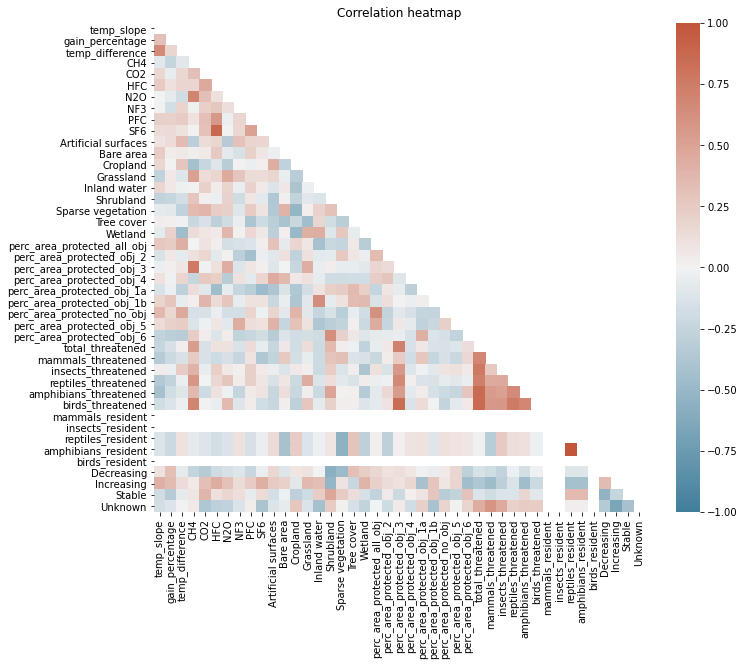

In [199]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Correlation heatmap')

# Compute the correlation matrix
corr = data.corr()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# create heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0)
plt.show()

### Logistic regression

In [200]:
def knn_by_target(data):
    cv_results = {}

    # iterate all tartget veriables
    target_columns = [col for col in data.columns if col.endswith('threatened') or col.endswith('trend')]
    for target in target_columns:
        y = data[target]
        X = data.drop(columns=target_columns)

        # create pipeline for Model
        svr = Pipeline([
            ('scaling', StandardScaler()),
            ('knn', KNeighborsRegressor())
        ])

        # define grid search parameters
        params = {
            'knn__n_neighbors': [1, 2, 3 , 4 , 5],
            'knn__weights': ['uniform', 'distance']
        }

        svm_grid_search = GridSearchCV(
            svr,
            cv=LeaveOneOut(),
            param_grid=params,
            scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],
            refit='neg_root_mean_squared_error')
    
        svm_grid_search.fit(X, y)

        cv_results[target] = svm_grid_search.cv_results_

    return cv_results

knn_cv_results = knn_by_target(data)

In [201]:
knn_best_scores, knn_best_params = results_by_target(data, knn_cv_results)
knn_best_scores

RMSE  RMSE_var       MAE   MAE_var
total_threatened       0.032593  0.001850  0.032593  0.001850
mammals_threatened     0.043627  0.001571  0.043627  0.001571
insects_threatened     0.038502  0.001455  0.038502  0.001455
reptiles_threatened    0.081186  0.014803  0.081186  0.014803
amphibians_threatened  0.101738  0.019913  0.101738  0.019913
birds_threatened       0.019454  0.001428  0.019454  0.001428

In [202]:
knn_best_params

neg_root_mean_squared_error  \
target                index                                     
total_threatened      n_neighbors                           5   
                      weights                        distance   
mammals_threatened    n_neighbors                           4   
                      weights                         uniform   
insects_threatened    n_neighbors                           4   
                      weights                         uniform   
reptiles_threatened   n_neighbors                           1   
                      weights                         uniform   
amphibians_threatened n_neighbors                           1   
                      weights                         uniform   
birds_threatened      n_neighbors                           5   
                      weights                        distance   

                                  neg_mean_absolute_error  
target                index                                
total_threatened      n_neighbors                       5  
                      weights                    distance  
mammals_threatened    n_neighbors                       4  
                      weights                     uniform  
insects_threatened    n_neighbors                       4  
                      weights                     uniform  
reptiles_threatened   n_neighbors                       1  
                      weights                     uniform  
amphibians_threatened n_neighbors                       1  
                      weights                     uniform  
birds_threatened      n_neighbors                       5  
                      weights                    distance

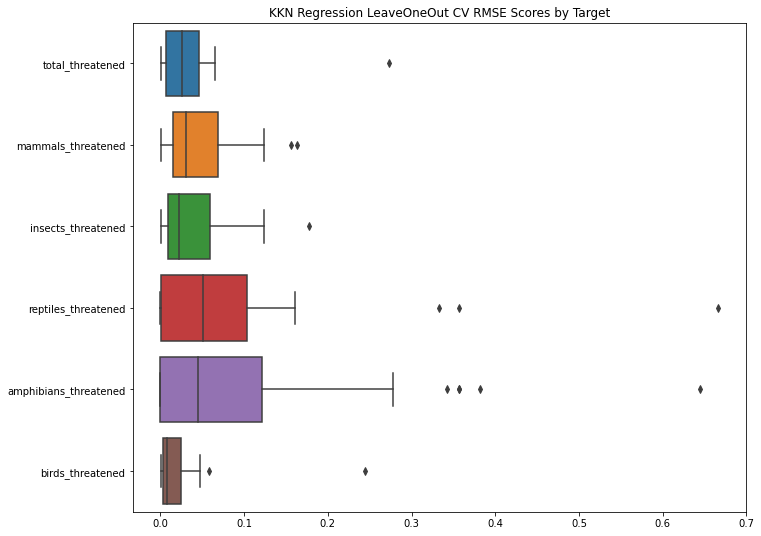

In [203]:
# get data
vis_knn_scores = extract_cv_scores(data, knn_cv_results, 'neg_root_mean_squared_error')

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('KKN Regression LeaveOneOut CV RMSE Scores by Target')

sns.boxplot(data=vis_knn_scores, orient='h')
plt.show()

### Support Vector Regression

We select support vector regression mainly because they are:
- Effective in high dimensional spaces.
- Still effective in cases where number of dimensions is greater than the number of samples.

In [204]:
def svr_by_target(data):
    cv_results = {}

    # iterate all tartget veriables
    target_columns = [col for col in data.columns if col.endswith('threatened') or col.endswith('trend')]
    for target in target_columns:
        y = data[target]
        X = data.drop(columns=target_columns)

        # create pipeline for Model
        svr = Pipeline([
            ('scaling', StandardScaler()),
            ('svr', SVR())
        ])

        # define grid search parameters
        params = {
            'svr__C': [0.1, 0.3, 0.5, 0.8, 1, 2, 5],
            'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
        }

        svm_grid_search = GridSearchCV(
            svr,
            cv=LeaveOneOut(),
            param_grid=params,
            scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],
            refit='neg_root_mean_squared_error')
    
        svm_grid_search.fit(X, y)

        cv_results[target] = svm_grid_search.cv_results_

    return cv_results

svr_cv_results = svr_by_target(data)

In [205]:
svr_best_scores, svr_best_params = results_by_target(data, svr_cv_results)
svr_best_scores

RMSE  RMSE_var       MAE   MAE_var
total_threatened       0.059855  0.002927  0.059855  0.002927
mammals_threatened     0.057087  0.001489  0.057087  0.001489
insects_threatened     0.055406  0.001679  0.055406  0.001679
reptiles_threatened    0.099888  0.009495  0.099888  0.009495
amphibians_threatened  0.105392  0.007807  0.105392  0.007807
birds_threatened       0.074630  0.001378  0.074630  0.001378

In [206]:
svr_best_params

neg_root_mean_squared_error  \
target                index                                
total_threatened      C                              0.5   
                      kernel                     sigmoid   
mammals_threatened    C                              0.1   
                      kernel                      linear   
insects_threatened    C                              0.1   
                      kernel                     sigmoid   
reptiles_threatened   C                              0.1   
                      kernel                     sigmoid   
amphibians_threatened C                              0.5   
                      kernel                     sigmoid   
birds_threatened      C                              0.3   
                      kernel                     sigmoid   

                             neg_mean_absolute_error  
target                index                           
total_threatened      C                          0.5  
                      kernel                 sigmoid  
mammals_threatened    C                          0.1  
                      kernel                  linear  
insects_threatened    C                          0.1  
                      kernel                 sigmoid  
reptiles_threatened   C                          0.1  
                      kernel                 sigmoid  
amphibians_threatened C                          0.5  
                      kernel                 sigmoid  
birds_threatened      C                          0.3  
                      kernel                 sigmoid

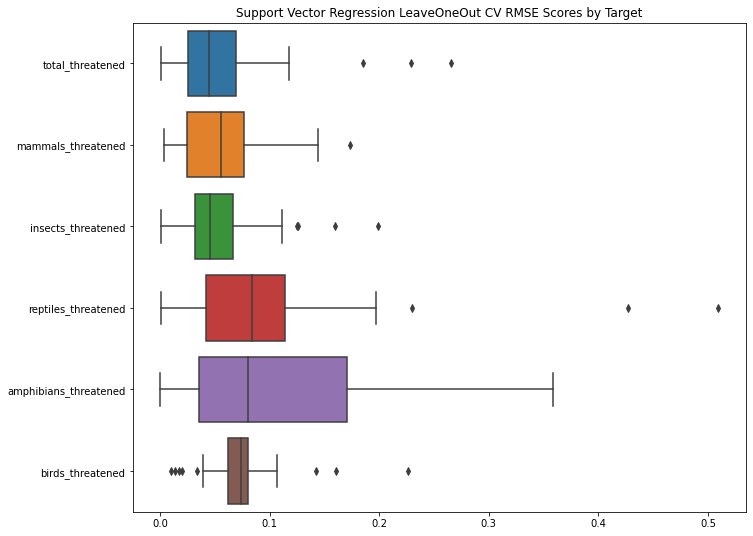

In [207]:
# get data
vis_knn_scores = extract_cv_scores(data, svr_cv_results, 'neg_root_mean_squared_error')

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Support Vector Regression LeaveOneOut CV RMSE Scores by Target')

sns.boxplot(data=vis_knn_scores, orient='h')
plt.show()

### Random Forest Regression
We perform random forest regression here to predict the outcome of our relative threatened species for all groups combined and for each group separately, as well as the trends. As a random forest is a tree partitioning algorithm it does by nature not need any scaling of the data beforehand. After the results of our correlation analysis we start with the full model here.
As the number of samples in our remaining data frame is quite limited, we use leave one out cross validation to measure the performance of our regressor rather than a train/test split.Because of the high dimension of the data, we take the square root of the total number of features to pick for every split.

In [208]:
complete_data = pd.concat([
        ds_climate.set_index('Country'), 
        ds_ghg.set_index('Country'), 
        ds_land_cover.set_index('Country'),
        ds_protected_areas.set_index('Country'), 
        ds_threatened_by_group.set_index('Country'), 
        ds_trend_by_group], 
        join='inner', 
        axis=1)

In [209]:
rf_data = complete_data.copy()
rf_data.shape

(42, 43)

In [210]:
def rf_predict_threatened_relative(data):
    cv_results = {}

    # iterate all target variables
    columns_threatened = [col for col in data.columns if col.endswith('threatened') or col.endswith('trend')]
    for target in columns_threatened:
        y = data[target]
        X = data.drop(columns=columns_threatened)

        # n_estimator(number of trees) is the hyperparameter that we try to optimize here
        n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
        grid = random_grid = {'n_estimators': n_estimators}
        rf=RandomForestRegressor(max_features = 'sqrt', random_state=0)
        rf_grid = GridSearchCV(estimator = rf, param_grid = random_grid,  cv = LeaveOneOut(),  scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],
            refit='neg_root_mean_squared_error')
        rf_grid.fit(X,y)    
        cv_results[target] = rf_grid.cv_results_

    return cv_results
rf_cv_results = rf_predict_threatened_relative(complete_data)

In [211]:
rf_best_scores, rf_best_params = results_by_target(complete_data, rf_cv_results)
rf_best_scores

RMSE  RMSE_var       MAE   MAE_var
total_threatened       0.028757  0.001750  0.028757  0.001750
mammals_threatened     0.039672  0.001398  0.039672  0.001398
insects_threatened     0.035185  0.001806  0.035185  0.001806
reptiles_threatened    0.087681  0.010589  0.087681  0.010589
amphibians_threatened  0.104817  0.013813  0.104817  0.013813
birds_threatened       0.020420  0.001258  0.020420  0.001258

In [212]:
rf_data

temp_slope  gain_percentage  temp_difference       CH4  \
Argentina          0.014949         0.500525         0.072246  1.828861   
Australia          0.017804         0.969423         0.214683  4.382540   
Austria            0.038525        24.241043         1.498389  0.728541   
Belgium            0.028670        12.044550         1.167659  0.688260   
Brazil             0.033281         3.703937         0.929317  1.683181   
Canada             0.037969       -24.178355         1.583368  2.466998   
Chile              0.014697         9.319080         0.761799  0.767192   
Colombia           0.020083         3.383376         0.833692  0.946694   
Costa Rica         0.018108         2.447034         0.604383  0.820945   
Czech Republic     0.047428        20.586324         1.598151  1.237946   
Denmark            0.036901         9.699569         0.800735  1.272634   
Estonia            0.037562         4.866007         0.301582  0.845256   
Finland            0.049607        43.855657         0.946397  0.823286   
France             0.026566         9.395659         1.010464  0.844018   
Germany            0.034688        13.837223         1.201279  0.634896   
Greece             0.050600        14.083415         1.852533  0.940815   
Hungary            0.057306        17.752956         1.710039  0.744502   
Iceland            0.042999        27.490863         0.691358  1.786166   
India              0.023121         3.484826         0.843200  0.334763   
Indonesia          0.013825         2.671550         0.696717  0.711852   
Ireland            0.006156         3.196774         0.298907  2.879337   
Israel             0.058883         7.233207         1.416450  0.831843   
Italy              0.038715        12.180835         1.425786  0.712204   
Japan              0.022342         5.224242         0.589587  0.236113   
Korea              0.013117        12.654444         1.061609  0.519825   
Latvia             0.035525         6.075607         0.406742  0.899544   
Lithuania          0.037384         8.398839         0.601233  1.093803   
Luxembourg         0.029807        12.243670         1.112161  0.966622   
Mexico             0.020896         4.217127         0.878617  1.171375   
Netherlands        0.032691        13.518773         1.279099  1.004478   
New Zealand        0.029854        12.086625         1.156237  7.017958   
Norway             0.038105        40.227732         0.649496  0.904485   
Poland             0.048945        17.945155         1.421874  1.269181   
Portugal           0.021486         3.690444         0.559011  0.887454   
Russia             0.052953       -21.630035         1.168926  2.740886   
Slovak Republic    0.055742        22.755623         1.667737  0.815535   
Slovenia           0.042709        18.825714         1.604571  0.935319   
Spain              0.027007         7.044876         0.940025  0.849984   
Sweden             0.034578        22.476843         0.538604  0.430511   
Switzerland        0.033786        19.951503         1.186882  0.568525   
United Kingdom     0.019055         8.485272         0.722540  0.781754   
United States      0.035890        19.363436         1.465005  1.939243   

                       CO2       HFC       N2O       NF3       PFC  \
Argentina         4.710241  0.014370  1.002114 -1.000000  0.003744   
Australia        16.642911  0.479420  0.804808 -1.000000  0.009443   
Austria           7.549433  0.207606  0.398982  0.001868  0.003680   
Belgium           8.787278  0.391962  0.500037  0.000057  0.011516   
Brazil            2.566549 -1.000000  0.894033 -1.000000 -1.000000   
Canada           15.826302  0.338527  1.023899  0.000003  0.016758   
Chile             4.837817  0.157948  0.369279 -1.000000  0.000000   
Colombia          1.691487  0.039670  0.478937 -1.000000 -1.000000   
Costa Rica        1.651245  0.125102  0.224534 -1.000000 -1.000000   
Czech Republic    9.825615  0.351586  0.571438  0.000293  0.000125   
Denmark           6.2

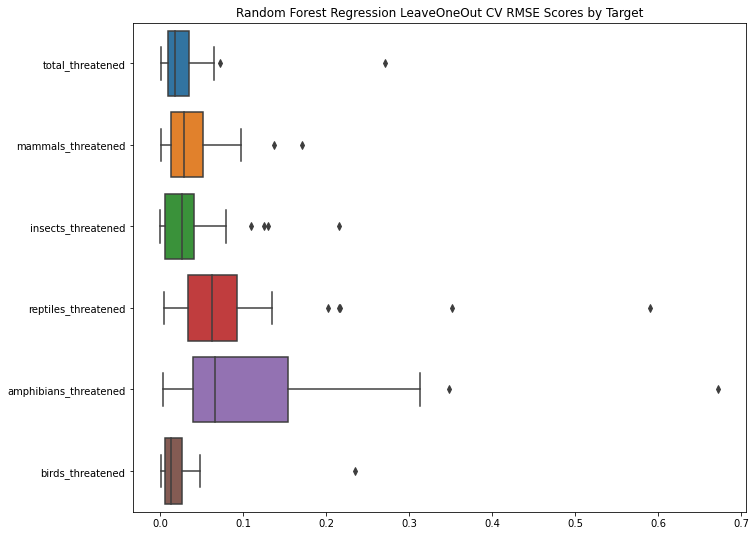

In [213]:
# get data
vis_rf_scores = extract_cv_scores(complete_data, rf_cv_results, 'neg_root_mean_squared_error')

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Random Forest Regression LeaveOneOut CV RMSE Scores by Target')

sns.boxplot(data=vis_rf_scores, orient='h')
plt.show()

#### Conclusion
As performance metric we used the RMSE here. As the range of our threatened species percentage of all groups is from 1.7%-16.7%, a RMSE of 5% is a pretty big offset. For amphibians the RMSE even suggests a mean 16% offset (maximum for all targets). These values indicate rather bad predictions that suggest that our model is not very well suited to predict the percentage of threatened animals in a country.

### Compare Models

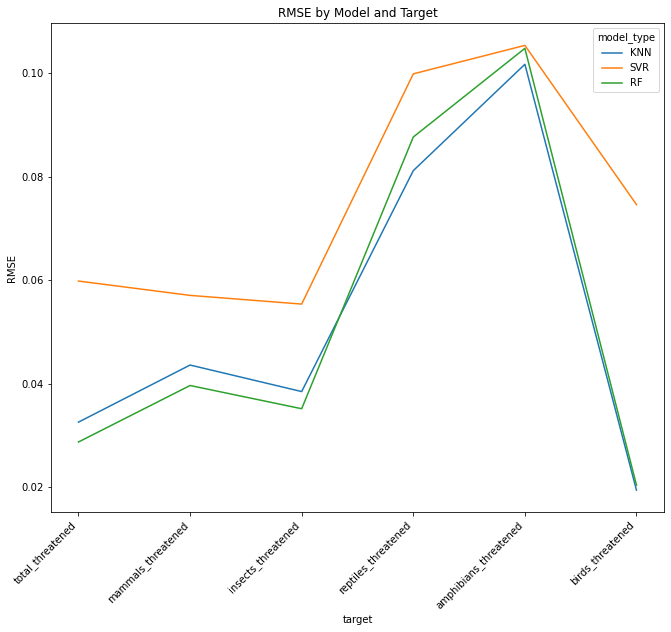

In [214]:
# prepare data for visualization
vis_knn = knn_best_scores.reset_index().rename(columns={'index': 'target'})
vis_knn['model_type'] = 'KNN'
vis_svr = svr_best_scores.reset_index().rename(columns={'index': 'target'})
vis_svr['model_type'] = 'SVR'
vis_rf = rf_best_scores.reset_index().rename(columns={'index': 'target'})
vis_rf['model_type'] = 'RF'
df =pd.concat([vis_knn, vis_svr, vis_rf])

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('RMSE by Model and Target')

# create heatmap
sns.lineplot(data=df, x='target', y='RMSE', hue='model_type')
plt.xticks(rotation=45, ha='right')
plt.show()